In [14]:
# load the libraries required
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import time
import glob
import os
from matplotlib import gridspec
from matplotlib.patches import Polygon ## for polygons
from matplotlib.collections import PatchCollection ## for polygons too
from matplotlib.colors import LinearSegmentedColormap ## for colour maps
from descartes import PolygonPatch
from itertools import islice
import math
from itertools import product
from sklearn import preprocessing
from scipy.stats import gaussian_kde
import requests as rs
import re

from scipy import stats
from scipy.stats import gaussian_kde

%matplotlib inline

# image ploting
from matplotlib.lines import Line2D
import matplotlib.patches as patches

# dictionary of epoc (key) and time range (value) in million years ago
geol_time_dict={'Holocene':(0,0.011700),
               'Pleistocene':(0.011700,2.58),
               'Pliocene':(2.58,5.333),
               'Miocene':(5.333,23.03),
               'Oligocene':(23.0,33.9),
               'Eocene':(33.9,56.0),
               'Paleocene':(56.0,66.0),
               'Late Cretaceous':(66.0,100.5),
               'Early Cretaceous':(100.5,145.0),
               'Jurassic':(145.0,201.3)}
# dictionary of epoc name (key) and list of colour and name abbreviation (value)
geol_col_dict={'Holocene':['#d6d6d6','Hol'], # dark grey
               'Pleistocene':['#ffffff','Ple'], # light grey
               'Pliocene':['#d6d6d6','Pli'],
               'Miocene':['#ffffff','Mio'],
               'Oligocene':['#d6d6d6','Oli'],
               'Eocene':['#ffffff','Eoc'],
               'Paleocene':['#d6d6d6','Pal'],
               'Late Cretaceous':['#ffffff','late Cret'],
              'Early Cretaceous':['#d6d6d6','early Cret'],
              'Jurassic':['#ffffff','Jur']}

# function to create colour dictionaries from a colour map and a list of items
def colourDict(data,cmap=mpl.cm.viridis,sort=False):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name. If sort = False, the function takes an ordered list of unique elements
    """
    cmap=cmap # default viridis
    data_unique=data if sort == False else list(set(data)) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

----

# 1. Fossil data 

----

## 1.1. Data and fossil age calculations

In [2]:
# def get_data():
#     return pd.read_csv('./pbdb_data_allcc.csv', skiprows=17, delimiter=',')
# try:
#     df = get_data()
# except:
# #     url = "https://paleobiodb.org/data1.2/occs/list.csv?datainfo&rowcount&cc=MG&show=full,genus"
#     url = "https://paleobiodb.org/data1.2/occs/list.csv?datainfo&rowcount&show=full,genus"
#     print("Downloading from the Paleobiology database...")
#     res = rs.get(url=url)
# #     with open('./pbdb_data_MG.csv', 'wb') as fp:
#     with open('./pbdb_data_allcc.csv', 'wb') as fp:
#         fp.write(res.content)
#     df = get_data()

# reads the fossil data downloaded by Daniel Edler using the code above
df = pd.read_csv('./Fossils-Madagascar/Genera_records_world.csv', sep=',')
df.columns
# replace no data with zero
df[['early_age', 'late_age']] = df[['early_age', 'late_age']].replace(np.nan,0)
# selects the fossil records from 160 Mya inclusive
df = df[df['early_age'] <= 160].reset_index()
# early age: towards past; late age: towards present
df[['early_age', 'late_age']].describe()

early_age      late_age
count  13126.000000  13126.000000
mean      41.446046     35.972068
std       45.011763     40.978979
min        0.011700      0.000000
25%        0.781000      0.011700
50%       15.970000     13.600000
75%       83.500000     70.600000
max      145.000000    140.200000

In [3]:
# fossils are dated with a range rather than a single year to accomodate uncertainty on time estimates
# plotting the fossil data either using the early or late ages means that most points will have the same age and visualizing the data as that is uninformative
# to plot fossil data so it is informative, we took the mean age of the fossil and added it to the late_age if the difference between early and late ages is >=1
# if the difference between early and late ages is <1 we simply assigned a random age between the early and late age estimates
# that is to add a sort of "jitter" to the age estimates that is closer to the mean age than to a random number (in case the age range is wide)
def enhance_ma(df):
    df['delta_ma'] = df['early_age'] - df['late_age']
    df['mean_ma'] = df['late_age'] + 0.5*df['delta_ma']
    df['rand_ma'] = df.apply(lambda row: row['mean_ma'] if row['delta_ma'] < 1 else np.random.randint(row['late_age'], row['early_age']), axis=1)

enhance_ma(df)
df[['early_age', 'late_age', 'delta_ma', 'mean_ma', 'rand_ma']]

early_age  late_age  delta_ma    mean_ma    rand_ma
0       113.0000   100.500   12.5000  106.75000  103.00000
1       132.9000   129.400    3.5000  131.15000  129.00000
2       139.8000   132.900    6.9000  136.35000  133.00000
3       113.0000   100.500   12.5000  106.75000  105.00000
4        59.2000    56.000    3.2000   57.60000   58.00000
...          ...       ...       ...        ...        ...
13121     0.0117     0.000    0.0117    0.00585    0.00585
13122    15.9700    13.600    2.3700   14.78500   13.00000
13123    13.0000   125.450 -112.4500   69.22500   69.22500
13124     0.7810     0.126    0.6550    0.45350    0.45350
13125     0.7810     0.126    0.6550    0.45350    0.45350

[13126 rows x 5 columns]

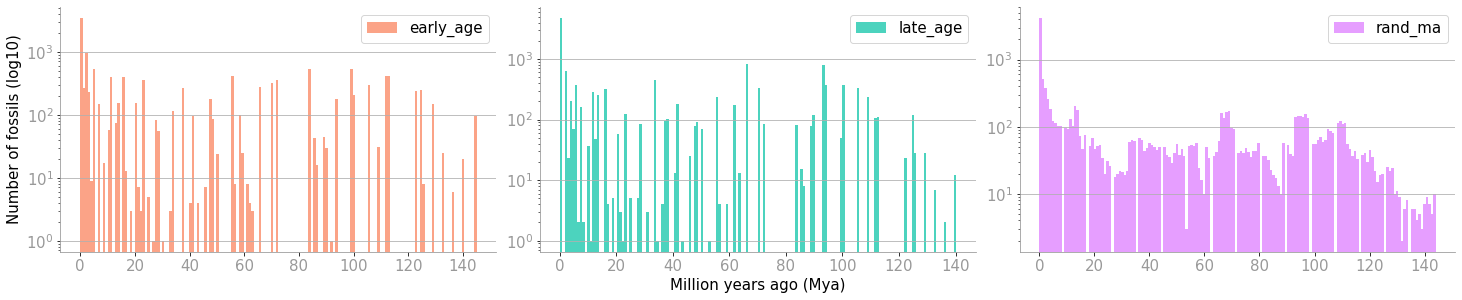

In [4]:
# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,1.5*3),facecolor='w')
G = gridspec.GridSpec(1,3,hspace=0.0,wspace=0.1)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'
for index,data in enumerate(ages):
    ax=plt.subplot(G[0,index])
    ax.hist(df[ages[index]],bins=160,lw=3,color=colours[index],alpha=0.7,label=ages[index], # 160 bins, 160 Mya
       histtype='stepfilled')
    [ax.spines[loc].set_visible(False) for loc in ['right','top']]
    for spine in ax.spines.values():
        spine.set_edgecolor(spinescol)
    if index == 0:
        plt.ylabel('Number of fossils (log10)',fontsize=15)
    if index == 1:
        plt.xlabel('Million years ago (Mya)',fontsize=15)
    plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
    plt.grid(axis='y')
    plt.yscale('log') # to see the data better
    plt.legend(fontsize=15)
plt.show()

## 1.2. Standardising fossil taxa

In [5]:

print('Example of the information in columns taxon_name, phylum, class, family\n',df[['taxon_name','phylum','class','family']])
print('\n','-'*100,'\n')
print('Unique values in the class column:\n',df['class'].unique())

# creates dictionary with the names we need to correct
# we chose these names because they make more sense for a broader public
common_name_dict = {'Mammalia':'Mammals',
                    'Aves':'Birds',
                    'Magnoliopsida':'Flowering plants',
                    'Reptilia':'Reptiles',
                    'Ginkgoopsida':'Other plants',
                    'Saurischia':'Dinosaurs',
                    'Osteichthyes':'Bony fishes'}
# creates new column of common names and maps the chages using the dictionary
df['common_name'] = df['class'].map(common_name_dict)

# adding missing data in the common_name column depending on the value of the phylum column and in whether the class column is empty
for row in df[df['class'].isna()].itertuples():
    if row.phylum == 'Angiospermae':
        df.loc[row.Index,'common_name'] = 'Magnoliopsida'
    if row.phylum == 'Coniferophyta':
        df.loc[row.Index,'common_name'] = 'Other plants'

print('\n','-'*100,'\n')
print('Unique values in the common name column:\n',df['common_name'].unique())

Example of the information in columns taxon_name, phylum, class, family
                     taxon_name    phylum           class             family
0        Otodus appendiculatus  Chordata  Chondrichthyes        Otodontidae
1           Odontaspis studeri  Chordata  Chondrichthyes     Odontaspididae
2           Odontaspis studeri  Chordata  Chondrichthyes     Odontaspididae
3               Corax falcatus  Chordata  Chondrichthyes       Anacoracidae
4            Isurus acuminatus  Chordata  Chondrichthyes           Lamnidae
...                        ...       ...             ...                ...
13121  Coturnix novaezelandiae  Chordata            Aves        Phasianidae
13122    Phalacrocorax auritus  Chordata            Aves  Phalacrocoracidae
13123        Lepidotus cf. sp.  Chordata     Actinopteri                NaN
13124           Ardea herodias  Chordata            Aves           Ardeidae
13125        Casmerodius albus  Chordata            Aves           Ardeidae

[13126 rows x 

In [12]:
# we are only mapping class of land lineages, including bony fishes. Anything else is nan.
cleandf = df[df['common_name'].isin(list(common_name_dict.values()))].copy(deep=True)
print('Number of unique names in common_name column: ',len(cleandf['common_name'].unique()))

# curating taxon_name
cleandf['taxon_corrected'] = cleandf['taxon_name'].str.replace('[^a-zA-Z \d]','') # keeps lower case, upper case, espaces
print('Number of unique names in common_name column after removing non-standard characters: ',len(cleandf['common_name'].unique()))
print('Taxon corrected unique (example):\n',cleandf['taxon_corrected'].unique())

Number of unique names in common_name column:  7
Number of unique names in common_name column after removing non-standard characters:  7
Taxon corrected unique (example):
 ['Mus  sp' 'Sus erymanthius' 'Sus gadarensis' ... 'Puffinus holei'
 'Dendrocygna eversa n sp' 'Anhinga malagurala n sp']


In [13]:
print('Before and after removing non-standard characers and other signs')
cleandf[['taxon_name','taxon_corrected']]

Before and after removing non-standard characers and other signs


taxon_name          taxon_corrected
38                   Mus ? sp.                  Mus  sp
39             Sus erymanthius          Sus erymanthius
40              Sus gadarensis           Sus gadarensis
41      Hippopotamus amphibius   Hippopotamus amphibius
50                  Sus scrofa               Sus scrofa
...                        ...                      ...
13120           Puffinus gavia           Puffinus gavia
13121  Coturnix novaezelandiae  Coturnix novaezelandiae
13122    Phalacrocorax auritus    Phalacrocorax auritus
13124           Ardea herodias           Ardea herodias
13125        Casmerodius albus        Casmerodius albus

[8500 rows x 2 columns]

## 1.3. Colour dictionaries for common names

In [19]:
# common_names_col = colourDict(cleandf['common_name'].unique(), cmap=mpl.cm.Set2, sort = True)

# using the muted qualitative in https://personal.sron.nl/~pault/
# common_names_col = {'Reptiles': '#88CCEE',
#  'Flowering plants': '#117733',
#  'Bony fishes': '#332288',
#  'Mammals': '#CC6677',
#  'Birds': '#999933',
#  'Dinosaurs': '#999933',
#  'Other plants': '#44AA99'}

# costum
orcoldict = {'Flatworms': '#DDDDDD',
    'Molluscs': '#A3A3A3',
    'Bony fishes': '#2F4858',
    'Arthropods': '#287990',
    'Amphibians': '#26A390',
    'Reptiles': '#BBCC76',
    'Birds': '#FFC4A8',
    'Dinosaurs': '#FFC4A8',
    'Mammals': '#F58A6F',
    'Flowering plants': '#BD5943',
    'Ferns': '#980F06',
    'Other plants': '#980F06'}

## 1.4. Pre-visualise the fossil data by common name

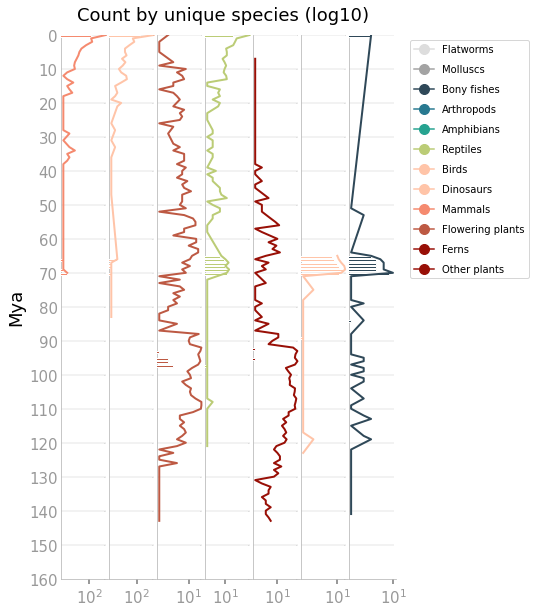

In [45]:
plt.figure(figsize=(6,10),facecolor='w')
G = gridspec.GridSpec(1,len(cleandf['common_name'].unique()),hspace=0.0,wspace=0.02)
# fig, axes = plt.subplots(nrows=1, ncols=len(fossil['common_name'].unique()), figsize=(5,10), sharex=False, sharey=True)

ylim = 160 # from 160 Mya
unit = 'taxon_name' # unique taxon name for the fossils, closest to species name for the fossils (taxon because fossils are often not identified to species)
height = 0.6 # height of the endemic Madagascar fossil count bars
yticklabels=[mya for mya in range(0,int(ax.get_ylim()[0]+10),10)]
# binning fossils by ingtenger random age and adding a column with the information.
cleandf['timebin'] = pd.cut(cleandf['rand_ma'],labels = False, bins = round(cleandf['rand_ma'].max()))
# dataframe of endemic Madagascar fossils (fossil taxa not found anywhere else but Madagascar as per 2021)
endemicdb = cleandf[cleandf['cc']=='MG'].copy(deep=True)

# creates a subplot in the grid per unique common name
for index,phy in enumerate(cleandf['common_name'].unique()):
    # creates temporary dataframe with fossils from the common name used at each loop
    # then groups by time bin and counts the number of unique taxon names (equivalent to counting num. of unique species in described taxa)
    temp = cleandf[cleandf['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    # temporary dataframe with fossils only found in Madagascar, groups by time bin and counts unique taxa
    endtemp = endemicdb[endemicdb['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    # initiates subplot and assigns to axis
    ax=plt.subplot(G[0,index])
    ax.set_ylim(ylim,0) # from 160 Mya to present
    # number of unique taxa per timebin (how many fossil taxa are dated every million year)
    ax.plot(temp[unit], temp['timebin'], color = orcoldict[phy], zorder = 10, lw = 2)
    # creating individual bars to plot endemic fossil counts
    for timebin in endtemp['timebin'].unique():
        endtemp1 = endtemp[endtemp['timebin'] == timebin]
        bottom = 0
        widthend = endtemp1[unit] # fossil count 
        ax.barh(y = timebin, width = widthend, height = height, left = bottom, align = 'edge', 
                facecolor = orcoldict[phy], edgecolor = 'w',zorder = 10, lw = 1, alpha = 1)
    ax.tick_params(axis='y',length=0); ax.tick_params(axis='x',length=5, direction='out',width=2,color=spinescol); 
    ax.set_yticks([mya for mya in range(0,int(ax.get_ylim()[0]+10),10)])
    [ax.spines[loc].set_visible(False) for loc in ['top','right']] 
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
    plt.xscale('log') # otherwise is biased towards the present and the rest of the fossils by My becomes invisible
    plt.yticks(fontsize = 15 if index == 0 else 0, color=spinescol); # prints labels only in the first subplot
    plt.xticks(fontsize = 15, color=spinescol)
    if index == 0:
        plt.ylabel('Mya', fontsize=18) 
    for spine in ax.spines.values():
        spine.set_edgecolor('#bababa')
legend_elements=[]
for key,value in orcoldict.items():
    legend_elements.append(Line2D([0],[0],marker='o',color=value,label=key,markersize=10))
ax.legend(handles = legend_elements, loc = 'best', bbox_to_anchor=(1.2, 0.5, 0.5, 0.5),labelspacing=1)
plt.suptitle('Count by unique species (log10)',y = 0.92, fontsize=18)

# plt.savefig('./fossilall.svg',dpi=300)
plt.show()

----

# Extant data

----

In [10]:
extant=pd.read_csv('./lineage_data_clean_v3.csv',sep='\t')
extant.columns
# geological/environmental events 
eventspre=pd.read_csv('./mada_paleo_events.tsv',sep='\t') # 'time_Ma_from','time_Ma_to','short','location','type',
# # events[['time_Ma_from','time_Ma_to','short','location','type']]

# # sorting the data
extant.sort_values(by='crown_age_plot', ascending = False, inplace = True); extant.reset_index(inplace=True)
extant[['crown_age_plot','stem_age_plot']]=extant[['crown_age_plot','stem_age_plot']].astype('float')
extant[['crown_age_plot','stem_age_plot']].describe()

crown_age_plot  stem_age_plot
count      206.000000     213.000000
mean        17.392233      29.247371
std         19.915088      28.400954
min          0.100000       1.000000
25%          4.000000       8.500000
50%         10.000000      19.500000
75%         23.202500      40.400000
max        151.000000     177.000000

In [11]:
extant.columns

Index(['index', 'Group', 'Family', 'Lineage', 'origin_plot',
       'Origin_or_sister_distribution', 'Mad_endemics', 'Non_Mad_endemics',
       'Crown_age', 'crown_age_plot', 'Stem_age', 'stem_age_plot',
       'Source_short', 'Source_DOI_URL'],
      dtype='object')

In [12]:
extant['Group'].unique()

array(['Arthropods', 'Bony fishes', 'Reptiles', 'Amphibians',
       'Flowering plants', 'Flatworms', 'Mammals', 'Birds', 'Molluscs',
       'Ferns'], dtype=object)

In [13]:
events = eventspre[eventspre['plot'] == 'y']
events['type'].unique()

array(['arid belt', 'dispersal', 'landbridges', 'major', 'submerged',
       'uplift', 'volcanism'], dtype=object)

In [14]:
# lineage origin color dictionary
origins = ['Africa', 'Eurasia', 'Indopacific', 'Neotropics', 'North America']
# # orclist=[(0.0,'#d4b9da'),(1.0,'#67001f')] # purples
# orclist=[(0.0,'#ffeda0'),(1.0,'#e31a1c')] # reds
# orcmap=mpl.colors.LinearSegmentedColormap.from_list('orcmap',orclist)
# orcoldict = colourDict(['Multiple', 'America', 'Oceania', 'Africa', 'Asia', 'Eurasia', 'Madagascar'], cmap = orcmap, sort=False)
# orcoldict = colourDict(extant['origin_plot'].unique(), cmap=mpl.cm.Dark2, sort = False)
orcoldictunique = colourDict(origins, cmap=mpl.cm.Dark2, sort = False)

# orcoldict['Unknown'] = '#ffffff'
orcoldictunique['Unknown'] = '#ffffff'
edgecolordict = dict(zip(origins,['w' if loc != 'Unknown' else '#bababa' for loc in origins]))

In [15]:
# counting total lineages for each common_names and adding them across datasets
# these counts will be used as "bottoms" and "left edges" for plotting
extant_span = {}
for name in extant['Group'].unique():
    count = len(extant[extant['Group'] == name])
    # take the largest number to set the xaxis span (ple will be plot on top of holo and we want the groups to correspond)
    extant_span[name] = count
extant_span

{'Arthropods': 45,
 'Bony fishes': 6,
 'Reptiles': 18,
 'Amphibians': 5,
 'Flowering plants': 111,
 'Flatworms': 1,
 'Mammals': 11,
 'Birds': 12,
 'Molluscs': 1,
 'Ferns': 7}

In [16]:
# orcoldict = {'Arthropods': '#AA4499',
#  'Bony fishes': '#332288',
#  'Reptiles': '#88CCEE',
#  'Amphibians': '#bdbdbd',
#  'Flowering plants': '#117733',
#  'Flatworms': '#DDCC77',
#  'Mammals': '#CC6677',
#  'Birds': '#999933',
#  'Molluscs': '#882255',
#  'Ferns': '#44AA99'}

# costum
orcoldict = {'Flatworms': '#DDDDDD',
	'Molluscs': '#A3A3A3',
	'Bony fishes': '#2F4858',
	'Arthropods': '#287990',
	'Amphibians': '#26A390',
	'Reptiles': '#BBCC76',
 	'Birds': '#FFC4A8',
 	'Dinosaurs': '#FFC4A8',
 	'Mammals': '#F58A6F',
 	'Flowering plants': '#BD5943',
 	'Ferns': '#980F06',
	'Other plants': '#980F06'}

extant_order = ['Flatworms','Molluscs','Bony fishes','Arthropods','Amphibians','Reptiles','Birds','Mammals','Flowering plants','Ferns']

----

# Plotting functions

----  


In [17]:
def addvolcanos(data, ax = '', holocene = False, offset = 0.5, color = '#a30000', levels = 3):
    """
    adds shades to denote long events
    data is a list of tuples, with data[0] == earliest (to the past) and data[1] == most recent dates
    """
    x = 0
    track = 0
    xlist = []
    while track <= len(volcanism):
        for i in range(levels):
            xlist.append(i); track += 1
    for index,pair in enumerate(data):
        if holocene == False:
            if pair[1] > 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                ymin = pair[0]
                ymax = pair[1]
        elif holocene == True:
            if pair[1] <= 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                ymin = pair[0]
                ymax = pair[1]
        else:
            ymin = pair[0]
            ymax = pair[1]
        ax.bar(x = xlist[index] * offset, height = ymax - ymin, width = offset, bottom = ymin, align = 'center', edgecolor = 'w', lw = 1.5, alpha = 1, color = 'w', zorder = 10)
        ax.bar(x = xlist[index] * offset, height = ymax - ymin, width = offset, bottom = ymin, align = 'center', edgecolor = 'none', lw = 1, alpha = 1, color = color, zorder = 11)       
    return ax

def addshade(data, x = 0, holocene = False, lines = False, offset = 1, lw = 1, ax = '', darkcol = '#a8a8a8', lightcol = '#d9d9d9'):
    """
    adds shades to denote long events
    data is a list of tuples, with data[0] == earliest (to the past) and data[1] == most recent dates
    """
    x = x
    for index,pair in enumerate(data):
        if holocene == False:
            if pair[1] > 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                ymin = pair[0]
                ymax = pair[1]
        elif holocene == True:
            if pair[1] <= 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                ymin = pair[0]
                ymax = pair[1]
        else:
                ymin = pair[0]
                ymax = pair[1]
        ax.axhspan(ymin = ymin, ymax = ymax, alpha=0.2, facecolor= darkcol if (index % 2) == 0 else lightcol, edgecolor = 'none',zorder = 10)
        if lines == True:
            ax.vlines(x = x, ymin = ymin, ymax = ymax, lw = lw, color = 'k')
        x += offset
    return ax

def lineevents(data, holocene = False, lw = 1, ax = '', color = 'k', ls = '-'):
    """
    adds lines for point events
    data is a list of tuples, with data[0] == earliest (to the past) and data[1] == most recent dates
    """
    xmin = ax.get_xlim()[0]
    xmax = ax.get_xlim()[1]
    for index,date in enumerate(data):
        if holocene == False:
            if date > 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                y = date
        elif holocene == True:
            if date <= 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                y = date
        else:
                y = date
        ax.hlines(y = date, xmin = xmin, xmax = xmax, lw = lw, color = color, ls = ls)
    return ax

def lineageplot(dataset,ax,colby='sister_lineage_plot',colbydict=orcoldict,by='common_name',byorder='',unit='name', crown='mean_crown_plot',stem='mean_stem_plot',
          width=1,bottom=0,xbase=0,offset=2,span='',tickrange=20,lw=1, zorder = 100, hlines = 10, edgecolor = 'none'):
    """
    plots lineage ages from left (earliest crown age) to right (crown ages closest to present)
    dataset=dataframe object
    colby=column name (str) by which the colour is applied
    colbydict=dictionary for colby with values == colors
    by=column name (str) by which separate the lineage groups
    byorder=ordered list of names if random order is not desired
    unit=column name (str) that represent lineage units (plotted as a vertical bar)
    crown=column name (str) with the crown ages
    stem=column name (str) with the stem ages
    span=dictionary name:distance with the span on the x axis between each 'by' group
    """
    plt.gca().invert_yaxis()
    names=[]
    if byorder!= '':
        names=byorder
    else:
        names=dataset[by].unique()
    for phy in names:
        temp = dataset[dataset[by] == phy].drop_duplicates(subset=[by,unit])  # the original list has duplicated entries when two papers had different 95% age ranges. We are using the 
        x = [i + xbase for i,x in enumerate(temp[unit].unique())]
        height = temp[crown].values
        ax.bar(x = x, height = height, width = width, bottom = bottom, align = 'center', edgecolor = edgecolor, lw = lw, alpha = 1, # [edgecolordict[x] for x in temp[colby]]
               color = [colbydict[x] for x in temp[colby]], zorder = zorder)
        # plotting stem ages when available
        ax.vlines(x = [(i + xbase) for i,x in enumerate(temp[unit].unique())], ymin = temp[crown], ymax = temp[stem], color = [colbydict[x] for x in temp[colby]], lw = 0.5, zorder = 5)
        # adds an extra space to separate lineages from each 'common name'
        xbase +=  offset + (span[phy]  if span != '' else len(temp[stem].values)) # len(temp[crown].values) # (len(temp[crown].values) + len(temp[stem].values))/2

    # set xlims using the last xbase value set
    ax.set_xlim(-5,xbase)
    ax.set_xticks([])

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    return ax

In [18]:
events[events['do_as'] == 'bar']['type'].unique()
bars = events[events['do_as'] == 'bar']
bars

index  time_Ma_from_plot  time_Ma_to  duration priority     type_old  \
12     36             56.000      20.000    36.000      NaN        biota   
13     40             12.000       5.000     7.000      low  landbridges   
14     39             36.000      30.000     6.000      low  landbridges   
15     38             66.000      60.000     6.000      low  landbridges   
27     22             72.100      33.900    38.200      low    landscape   
28     18             23.030       0.000    23.030     high    landscape   
29     20             33.900       0.000    33.900     high    landscape   
30      2              5.333       2.580     2.753      NaN    volcanism   
31      7             21.030       0.000    21.030      NaN    volcanism   
32     10             33.900       5.333    28.567      NaN    volcanism   
33     12             92.000      84.000     8.000      NaN    volcanism   
34      9             33.900       5.333    28.567      NaN    volcanism   
35      1              5.333       2.580     2.753      NaN    volcanism   
36      6             15.000      10.000     5.000      NaN    volcanism   
37      8             27.820      23.030     4.790      NaN    volcanism   
38      3             10.600         NaN       NaN      NaN    volcanism   
39      5             12.100      12.100     0.000      NaN    volcanism   
40      0              2.580       0.000     2.580      NaN    volcanism   
41     11             47.800      41.200     6.600      NaN    volcanism   

   layout       priority.1 plot do_as         type  \
12  shade              low    y   bar    dispersal   
13  shade       landbridge    y   bar  landbridges   
14  shade       landbridge    y   bar  landbridges   
15  shade       landbridge    y   bar  landbridges   
27   barb             high    y   bar    submerged   
28   line  iconinvolcanism    y   bar       uplift   
29   line  iconinvolcanism    y   bar       uplift   
30   bara        volcanism    y   bar    volcanism   
31   bara        volcanism    y   bar    volcanism   
32   bara        volcanism    y   bar    volcanism   
33   bara        volcanism    y   bar    volcanism   
34   bara        volcanism    y   bar    volcanism   
35   bara        volcanism    y   bar    volcanism   
36   bara        volcanism    y   bar    volcanism   
37   bara        volcanism    y   bar    volcanism   
38   bara        volcanism    y   bar    volcanism   
39   bara        volcanism    y   bar    volcanism   
40   bara        volcanism    y   bar    volcanism   
41   bara        volcanism    y   bar    volcanism   

                                 description_original  \
12  Africa-to-Madgascar surface currents favourabl...   
13  short-lived landbridge between Africa and Mada...   
14  short-lived landbridge between Africa and Mada...   
15  short-lived landbridge between Africa and Mada...   
27  substantial part of western Madagascar submerg...   
28                          uplift in north of island   
29                          uplift in south of island   
30                                    Ambre volcanism   
31      basaltic magmatism in north, centre and south   
32          E-W extension with volcanism in Ankaratra   
33  formation of large igneous Basalt province acr...   
34                              growth of Tsaratanana   
35                  last phase of Ankaratra volcanism   
36   mantel plume with volcanism beneath N Madagascar   
37                       start of Ankaratra volcanism   
38            volcanic activity at Bobaomby peninsula   
39              volcanic activity at Montagne d’Ambre   
40                      volcanism in Ankaratra, Itasy   
41  volcanism in Tsaratanana, Manongarivo, Ampasin...   

                                          description  \
12  Africa-to-Madgascar surface currents favourabl...   
13  short-lived landbridge between Africa and Mada...   
14  short-lived landbridge between Africa and Mada...   
15  short-lived landbridge betwee

In [19]:
bars['type'].unique()

array(['dispersal', 'landbridges', 'submerged', 'uplift', 'volcanism'],
      dtype=object)

In [20]:
# shades
# events.loc[40,'time_Ma_to']=float(9.6) # it is originally nan but we need it to be at least a unit big to plot it visibly
# events
bars.sort_values(by = 'time_Ma_to', inplace = True)

dispersal = list(zip(bars[bars['type'] == 'dispersal']['time_Ma_to'], bars[bars['type'] == 'dispersal']['time_Ma_from_plot']))
landbridges = list(zip(bars[bars['type'] == 'landbridges']['time_Ma_to'], bars[bars['type'] == 'landbridges']['time_Ma_from_plot']))
submerged = list(zip(bars[bars['type'] == 'submerged']['time_Ma_to'], bars[bars['type'] == 'submerged']['time_Ma_from_plot']))
uplift = list(zip(bars[bars['type'] == 'uplift']['time_Ma_to'], bars[bars['type'] == 'uplift']['time_Ma_from_plot']))
volcanism = list(zip(bars[bars['type'] == 'volcanism']['time_Ma_to'], bars[bars['type'] == 'volcanism']['time_Ma_from_plot']))
# # volcanism
# landscape = list(zip(bars[bars['type'] == '']['time_Ma_to'], bars[bars['type'] == '']['time_Ma_from_plot']))
# # landscape
# pointevents=events[events['layout'].isin(['line','point'])]['time_Ma_from_plot'].values


# warmer=list(zip(bars[bars['priority.1']=='warmer']['time_Ma_from_plot'],bars[bars['priority.1']=='landbridge']['time_Ma_to']))
# colder=list(zip(bars[bars['priority.1']=='colder']['time_Ma_from_plot'],bars[bars['priority.1']=='landbridge']['time_Ma_to']))
# # pointevents

C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [21]:
pd.set_option('display.max_colwidth', -1)
lineevents = {'Eocene-Oligocene boundary climate shif':34, 'Cretaceous-Paleogene boundary':66}
# shadeevents = {'Western plateau below sea':[33.9,72.1], 'Split from India':[84,91],'Split from Africa':[23,140],'Southernmost position at 50\u00b0':[150,160]}
# events[events['priority.1'] == 'high'][['time_Ma_from_plot','time_Ma_to','short']]

In [22]:
# events plotting... first shades
events[events['do_as'] == 'shade']#[['time_Ma_to','time_Ma_from_plot']]

index  time_Ma_from_plot  time_Ma_to  duration priority   type_old layout  \
0   29     65.00              27.820      37.180    NaN      climate    shade   
23  4      11.63              5.333       6.297     NaN      volcanism  bara    
24  14     160.00             150.000     10.000    high     tectonics  shade   
25  24     140.00             23.000      117.000   low      landscape  barb    
26  13     91.00              84.000      7.000     high     tectonics  shade   

   priority.1 plot  do_as       type  \
0   warmer     y    shade  arid belt   
23  low        y    shade  major       
24  high       y    shade  major       
25  high       y    shade  major       
26  high       y    shade  major       

                                                              description_original  \
0   Madagascar passes thorugh subtropical arid belt                                  
23  Indian monsoon hits N-most Madagascar                                            
24  Madagascar may have reached most S position (52° lat) then reversed northwards   
25  separation from Africa                                                           
26  separation from India-Seychelles block                                           

                                                                       description  \
0   Madagascar passes thorugh subtropical arid belt                                  
23  Indian monsoon hits N-most Madagascar                                            
24  Madagascar may have reached most S position (52° lat) then reversed northwards   
25  separation from Africa                                                           
26  separation from India-Seychelles block                                           

                            short      location  
0   arid conditions across island  NaN           
23  monsoons start to hit north    north         
24  southernmost position at 50°   whole island  
25  separation from Africa         whole island  
26  separation from India          whole island

In [23]:
shadeevents = {'Madagascar passes thorugh subtropical arid belt':[27.82, 65.0,'#fcd144'], # #e3d36b --? lighter #f0b800 --> brigther #f2e172 super bright--
 'Indian monsoon hits N-most Madagascar':[5.332999999999999, 11.63,'#fcd144'],
 'Madagascar may have reached most S position':[150.0, 160.0,'#fcd144'],
 'Separation from Africa':[23.0, 140.0,'#faeb87'],
 'Separation from India-Seychelles block':[84.0, 91.0,'#fcd144']}

In [24]:
cleandf['common_name'].unique()
fossil_order = ['Bony fishes','Reptiles','Birds','Dinosaurs','Mammals','Flowering plants', 'Other plants']

['Flatworms', 'Molluscs', 'Bony fishes', 'Arthropods', 'Amphibians', 'Reptiles', 'Birds', 'Mammals', 'Flowering plants', 'Ferns']
0 Bony fishes
1 Reptiles
2 Birds
3 Dinosaurs
4 Mammals
5 Flowering plants


C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6 Other plants


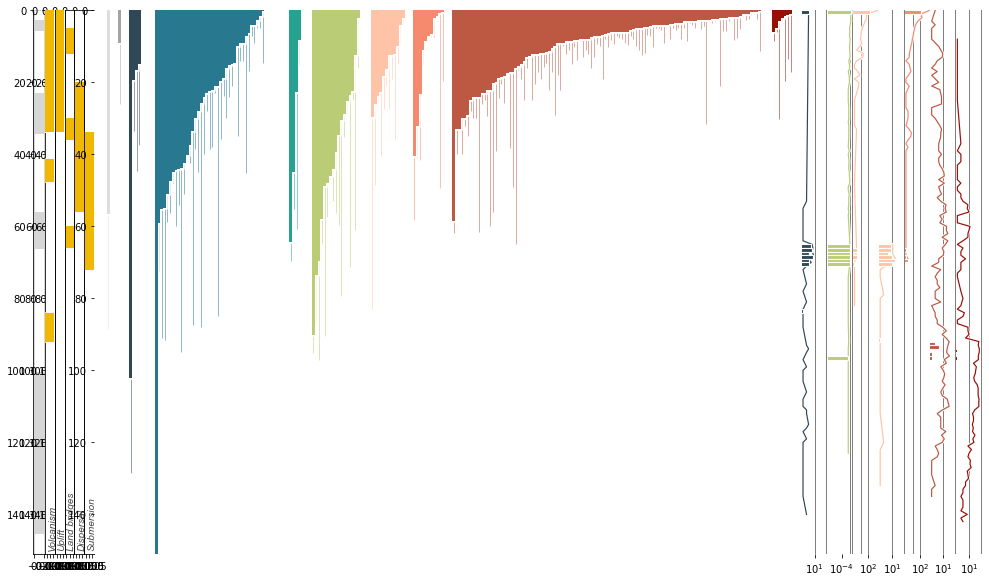

In [57]:
plt.figure(figsize=(17,10),facecolor='w')
ratio_events = 0.031
ratio_fossils = 0.08
G = gridspec.GridSpec(1,14,hspace=0.0,wspace=0.0, width_ratios =[0.035,ratio_events,ratio_events,ratio_events,ratio_events,ratio_events,2.2,
                                                                  ratio_fossils,ratio_fossils,ratio_fossils,ratio_fossils,ratio_fossils,ratio_fossils,ratio_fossils])
text_color='#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
# ------------------------------------------------------------------------- epochs
ax1=plt.subplot(G[0,0])
ax1.set_ylim(round(extant['crown_age_plot'].max()),0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax1.bar(x = 0, height = value[1] - value[0], width = 2, bottom = epochbase, align = 'edge', edgecolor = '#d6d6d6', facecolor = geol_col_dict[key][0], lw = 1, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
#     ax1.text(x = ax1.get_xlim()[1]*0.2, y = epochbase + (value[1] - value[0])*0.5, s = geol_col_dict[key][1], fontsize = 8, color = 'k', rotation = 90, zorder = 100)
# ax1.set_yticks(ticks = [mya for mya in range(0,int(ax1.get_ylim()[0]),50)]); plt.yticks(color = '#787878', fontsize = 12)

# ------------------------------------------------------------------------- submerged
ax4=plt.subplot(G[0,5])
ax4.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(submerged, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax4, levels = 1)
ax4.text(x=(ax4.get_xlim()[1]/2),y=ax4.get_ylim()[0]-1,s='Submersion',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')
# ------------------------------------------------------------------------- dispersal
ax2=plt.subplot(G[0,4])
ax2.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(dispersal, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax2, levels = 1)
ax2.text(x=(ax2.get_xlim()[1]/2),y=ax2.get_ylim()[0]-1,s='Dispersal',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')
# ------------------------------------------------------------------------- landbridges
ax3=plt.subplot(G[0,3])
ax3.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(landbridges, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax3, levels = 1)
ax3.text(x=(ax3.get_xlim()[1]/2),y=ax3.get_ylim()[0]-1,s='Land bridges',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')

# ------------------------------------------------------------------------- uplift
ax5=plt.subplot(G[0,2])
ax5.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(uplift, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax5, levels = 1)
ax5.text(x=(ax5.get_xlim()[1]/2),y=ax5.get_ylim()[0]-1,s='Uplift',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')

# ------------------------------------------------------------------------- volcanism
ax6=plt.subplot(G[0,1])
ax6.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(volcanism, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax6, levels = 1)
ax6.text(x=(ax6.get_xlim()[1]/2),y=ax6.get_ylim()[0]-1,s='Volcanism',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')

# ------------------------------------------------------------------------- extant
whitedict = {key:'#ffffff' for key in orcoldict.keys()}
# greydict = {key:'#787878' for key in orcoldict.keys()}
ax7=plt.subplot(G[0,6])
ax7.set_ylim(round(extant['crown_age_plot'].max()),0);plt.gca().invert_yaxis() # extant_order # sorted(extant_span.keys())
lineageplot(extant, ax = ax7, colby = 'Group', colbydict = whitedict, by = 'Group', byorder = extant_order, unit = 'Lineage', crown = 'crown_age_plot', stem = 'crown_age_plot',
          width = 1.05, bottom = 0, xbase = 0, offset = 3,span = '', tickrange = 50, lw = 2.5, edgecolor = 'w');plt.gca().invert_yaxis() # extant_span
lineageplot(extant, ax = ax7, colby = 'Group', colbydict = orcoldict, by = 'Group', byorder = extant_order, unit = 'Lineage', crown = 'crown_age_plot', stem = 'stem_age_plot',
          width = 1.06, bottom = 0, xbase = 0, offset = 3,span = '', tickrange = 50, lw = 0.3, edgecolor = 'none') # extant_span
print(extant_order)
# for key,value in shadeevents.items():
#         ax.vlines(x = 200, ymin = value[0], ymax = value[1], lw = 1, color ='k')
# ------------------------------------------------------------------------- fossil

ylim = 150
unit = 'taxon_name'
height = 1
cleandf['timebin'] = pd.cut(cleandf['rand_ma'],labels = False, bins = round(cleandf['rand_ma'].max()))
endemicdb = cleandf[cleandf['cc']=='MG']
xbase = 0
for index,phy in enumerate(fossil_order):
    print(index,phy)
    temp = cleandf[cleandf['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    endtemp = endemicdb[endemicdb['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    
    ax=plt.subplot(G[0,7 + index])
    ax.set_ylim(round(extant['crown_age_plot'].max()),0)
    ax.plot(temp[unit], temp['timebin'], color = 'w', zorder = 8, lw = 3, alpha = 1)
    ax.plot(temp[unit], temp['timebin'], color = orcoldict[phy], zorder = 9, lw = 1.2)
    for timebin in endtemp['timebin'].unique():
        endtemp1 = endtemp[endtemp['timebin'] == timebin]
        bottom = 0
        widthend = endtemp1[unit]
        ax.barh(y = timebin, width = widthend, height = height, left = bottom + xbase, align = 'edge', 
                facecolor = orcoldict[phy], edgecolor = 'w',zorder = 11, lw = 1.1, alpha = 1)
    xbase += 0
    
#     print([xx for xx in range(0, temp[unit].max(), int(temp[unit].max()/2))])
#     print([np.log10(xx) for xx in range(0, temp[unit].max(), int(temp[unit].max()/2))])

    for xx in [0,10,100]:
        ax.axvline(x = xx, ymin = round(extant['crown_age_plot'].max()), ymax = 0, color = 'k', lw = 0.5)
    plt.xscale('log')
    ax.set_yticks([])
    [ax.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']] 
#     ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
#     for key,value in lineevents.items():
#         ax.hlines(y = value, xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 1.2, color = '#f0b800', zorder = 4)
#     for key,value in shadeevents.items():
#         ax.axhspan(ymin = value[0], ymax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 3)  
#     for spine in ax.spines.values():
#         spine.set_edgecolor('w'); spine.set_linewidth(8)

# for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7]:
#     [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
# #     ax.set_xticks([])
# #     ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
# #     for key,value in shadeevents.items():
# #         ax.axhspan(ymin = value[0], ymax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 3)
# #     for key,value in lineevents.items():
# #         ax.hlines(y = value, xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 1.2, color = '#f0b800', zorder = 4)
#     if ax != ax1:
#         ax.set_yticks([])
# plt.savefig('./fossiltemp2.svg',dpi=300)
plt.show()


In [53]:
print([xx for xx in [10,100,1000,10000]])
print([np.log10(xx) for xx in [10,100,1000,10000]])

[10, 100, 1000, 10000]
[1.0, 2.0, 3.0, 4.0]


['Amphibians', 'Arthropods', 'Birds', 'Bony fishes', 'Ferns', 'Flatworms', 'Flowering plants', 'Mammals', 'Molluscs', 'Reptiles']
0 Mammals
1 Birds


C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2 Flowering plants
3 Reptiles
4 Other plants
5 Dinosaurs
6 Bony fishes


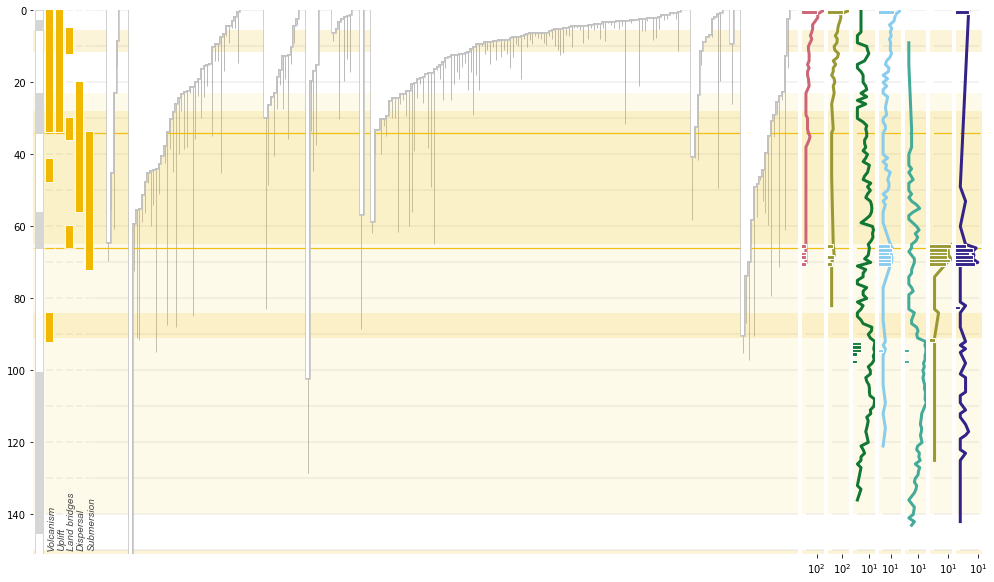

In [102]:
plt.figure(figsize=(17,10),facecolor='w')
ratio_events = 0.031
ratio_fossils = 0.08
G = gridspec.GridSpec(1,14,hspace=0.0,wspace=0.0, width_ratios =[0.035,ratio_events,ratio_events,ratio_events,ratio_events,ratio_events,2.2,
                                                                  ratio_fossils,ratio_fossils,ratio_fossils,ratio_fossils,ratio_fossils,ratio_fossils,ratio_fossils])
text_color='#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
# ------------------------------------------------------------------------- epochs
ax1=plt.subplot(G[0,0])
ax1.set_ylim(round(extant['crown_age_plot'].max()),0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax1.bar(x = 0, height = value[1] - value[0], width = 2, bottom = epochbase, align = 'edge', edgecolor = '#d6d6d6', facecolor = geol_col_dict[key][0], lw = 1, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
#     ax1.text(x = ax1.get_xlim()[1]*0.2, y = epochbase + (value[1] - value[0])*0.5, s = geol_col_dict[key][1], fontsize = 8, color = 'k', rotation = 90, zorder = 100)
# ax1.set_yticks(ticks = [mya for mya in range(0,int(ax1.get_ylim()[0]),50)]); plt.yticks(color = '#787878', fontsize = 12)

# ------------------------------------------------------------------------- submerged
ax4=plt.subplot(G[0,5])
ax4.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(submerged, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax4, levels = 1)
ax4.text(x=(ax4.get_xlim()[1]/2),y=ax4.get_ylim()[0]-1,s='Submersion',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')
# ------------------------------------------------------------------------- dispersal
ax2=plt.subplot(G[0,4])
ax2.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(dispersal, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax2, levels = 1)
ax2.text(x=(ax2.get_xlim()[1]/2),y=ax2.get_ylim()[0]-1,s='Dispersal',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')
# ------------------------------------------------------------------------- landbridges
ax3=plt.subplot(G[0,3])
ax3.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(landbridges, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax3, levels = 1)
ax3.text(x=(ax3.get_xlim()[1]/2),y=ax3.get_ylim()[0]-1,s='Land bridges',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')

# ------------------------------------------------------------------------- uplift
ax5=plt.subplot(G[0,2])
ax5.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(uplift, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax5, levels = 1)
ax5.text(x=(ax5.get_xlim()[1]/2),y=ax5.get_ylim()[0]-1,s='Uplift',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')

# ------------------------------------------------------------------------- volcanism
ax6=plt.subplot(G[0,1])
ax6.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(volcanism, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax6, levels = 1)
ax6.text(x=(ax6.get_xlim()[1]/2),y=ax6.get_ylim()[0]-1,s='Volcanism',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')

# ------------------------------------------------------------------------- extant
whitedict = {key:'#ffffff' for key in orcoldict.keys()}
greydict = {key:'#787878' for key in orcoldict.keys()}
ax7=plt.subplot(G[0,6])
ax7.set_ylim(round(extant['crown_age_plot'].max()),0);plt.gca().invert_yaxis()
lineageplot(extant, ax = ax7, colby = 'Group', colbydict = greydict, by = 'Group', byorder = sorted(extant_span.keys()), unit = 'Lineage', crown = 'crown_age_plot', stem = 'stem_age_plot',
          width = 1.05, bottom = 0, xbase = 0, offset = 3,span = '', tickrange = 50, lw = 2.5, edgecolor = '#c2c2c2');plt.gca().invert_yaxis() # extant_span
lineageplot(extant, ax = ax7, colby = 'Group', colbydict = whitedict, by = 'Group', byorder = sorted(extant_span.keys()), unit = 'Lineage', crown = 'crown_age_plot', stem = 'crown_age_plot',
          width = 1.05, bottom = 0, xbase = 0, offset = 3,span = '', tickrange = 50, lw = 0.3, edgecolor = 'none') # extant_span
print(sorted(extant_span.keys()))
# for key,value in shadeevents.items():
#         ax.vlines(x = 200, ymin = value[0], ymax = value[1], lw = 1, color ='k')
# ------------------------------------------------------------------------- fossil

ylim = 150
unit = 'taxon_name'
height = 1
cleandf['timebin'] = pd.cut(cleandf['rand_ma'],labels = False, bins = round(cleandf['rand_ma'].max()))
endemicdb = cleandf[cleandf['cc']=='MG']
xbase = 0
for index,phy in enumerate(cleandf['common_name'].unique()):
    print(index,phy)
    temp = cleandf[cleandf['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    endtemp = endemicdb[endemicdb['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    
    ax=plt.subplot(G[0,7 + index])
    ax.set_ylim(round(extant['crown_age_plot'].max()),0)
#     ax.plot(temp[unit], temp['timebin'], color = common_names_col[phy], zorder = 8, lw = 5, alpha = 0.3)
    ax.plot(temp[unit], temp['timebin'], color = common_names_col[phy], zorder = 9, lw = 3)
    for timebin in endtemp['timebin'].unique():
        endtemp1 = endtemp[endtemp['timebin'] == timebin]
        bottom = 0
        widthend = endtemp1[unit]
        ax.barh(y = timebin, width = widthend, height = height, left = bottom + xbase, align = 'edge', 
                facecolor = common_names_col[phy], edgecolor = 'w',zorder = 11, lw = 1.1, alpha = 1)
    xbase += 0 
    plt.xscale('log')
    ax.set_yticks([])
    [ax.spines[loc].set_visible(False) for loc in ['top','right','bottom']] 
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
    for key,value in lineevents.items():
        ax.hlines(y = value, xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 1.2, color = '#f0b800')
    for key,value in shadeevents.items():
        ax.axhspan(ymin = value[0], ymax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 3)  
    for spine in ax.spines.values():
        spine.set_edgecolor('w'); spine.set_linewidth(8)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7]:
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_xticks([])
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
    for key,value in shadeevents.items():
        ax.axhspan(ymin = value[0], ymax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 3)
    for key,value in lineevents.items():
        ax.hlines(y = value, xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 1.2, color = '#f0b800')
    if ax != ax1:
        ax.set_yticks([])
# plt.savefig('./template1.svg',dpi=300)
plt.show()


In [11]:
holocene = pd.read_csv('./new_holocene_shades.txt', sep ='\t')
holocene.sort_values(by = 'start_ka_bp', ascending = False, inplace = True)
print(holocene.type.unique())
holocene_order = ['climate','vegetation','human arrival','introductions','last record']
holo_col = {'climate':'#f0b800',
            'vegetation':'#c08f00',
            'human arrival':'#916800',
            'introductions':'#674300',
           'last record':'#bababa'}

print(holocene.groupby(by = 'type')['description'].count())
holocene.sort_values(by = 'type')

line_events = {'mammal extinction rate increase after human arrival':2,
              'European arrival, intensification of activities':0.5,
              'robust evidence for human presence':2} # removed from list
last_records = {'hippopotamus':0.950,
               'elephant birds':0.840,
               'giant tortoise':0.750,
               'giant lemurs':0.585}
holocene

['human arrival' 'climate' 'vegetation' 'introductions' 'last record']
type
climate          1
human arrival    2
introductions    6
last record      4
vegetation       1
Name: description, dtype: int64


start_ka_bp  end_ka_bp                            description  \
12       10.500      2.000  tentative evidence for human presence   
0         5.500      0.000                    increase in aridity   
1         2.000      0.000                 grassy biome expansion   
13        1.250      0.500                        human expansion   
2         1.120      0.870                                    dog   
3         1.100      0.650                                 cattle   
4         1.100      0.650                                    rat   
5         1.050      0.750                                bushpig   
6         0.950      0.550                        goats and sheep   
11        0.950      0.950                           hippopotamus   
7         0.934      0.801                                   rice   
9         0.840      0.840                         elephant birds   
10        0.750      0.750                         giant tortoise   
8         0.585      0.585             giant lemurs (Megadalapis)   

             type  
12  human arrival  
0         climate  
1      vegetation  
13  human arrival  
2   introductions  
3   introductions  
4   introductions  
5   introductions  
6   introductions  
11    last record  
7   introductions  
9     last record  
10    last record  
8     last record

0 climate
1 vegetation
2 human arrival
3 introductions
4 last record


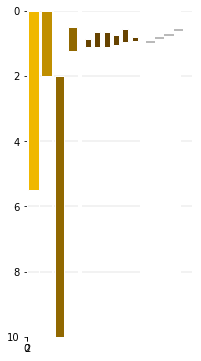

In [13]:
plt.figure(figsize=(3,6),facecolor='w')
ratio_events = 1
ratio_fossils = 0.08
G = gridspec.GridSpec(1,6,hspace=0.0,wspace=0.0, width_ratios =[0.01,1,1,2.1,5,4])
text_color='#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
# ------------------------------------------------------------------------- epochs
ax1=plt.subplot(G[0,0])
ax1.set_ylim(round(holocene['start_ka_bp'].max()),0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax1.bar(x = 0, height = value[1] - value[0], width = 2, bottom = epochbase, align = 'edge', edgecolor = '#d6d6d6', facecolor = geol_col_dict[key][0], lw = 1, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
# for key,value in geol_time_dict.items():
#     ax1.bar(x = 0, height = value[1] - value[0], width = 2, bottom = epochbase, align = 'edge', edgecolor = '#d6d6d6', facecolor = geol_col_dict[key][0], lw = 1, alpha = 1, zorder = 10)
#     epochbase += value[1] - value[0]
#     ax1.text(x = ax1.get_xlim()[1]*0.2, y = epochbase + (value[1] - value[0])*0.5, s = geol_col_dict[key][1], fontsize = 8, color = 'k', rotation = 90, zorder = 100)
# ax1.set_yticks(ticks = [mya for mya in range(0,int(ax1.get_ylim()[0]),50)]); plt.yticks(color = '#787878', fontsize = 12)
xbase = 0
for i,event in enumerate(holocene_order):
    print(i,event)
    ax=plt.subplot(G[0,i + 1])
    ax.set_ylim(round(holocene['start_ka_bp'].max()),0)
    
    temp = holocene[holocene.type == event]
        
    for row in temp.itertuples():
        height = row.start_ka_bp - row.end_ka_bp
        width = 0.2
        bottom = row.end_ka_bp
        ax.bar(x = xbase, height = height, width = width, bottom = bottom, align = 'center', facecolor = holo_col[event], edgecolor = 'w', lw = 1, alpha = 1, zorder = 4)
        xbase += 0.3
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_xticks([])
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),2)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    ax.set_yticks([])
    
    if event == 'last record':
#         for key,values in line_events.items():
#             ax.hlines(y = values, xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], color = 'k', lw = 0.8, ls = '-')
        xpos = 0.1
        for key,values in last_records.items():
            ax.hlines(y = values, xmin = xpos - 1, xmax = xpos, color = '#bababa', lw = 2, ls = '-')
            xpos += 1

plt.savefig('./holocene4.svg',dpi=300)
plt.show()


In [155]:
holocene = pd.read_csv('./new_holocene_shades.txt', sep ='\t')
holocene.sort_values(by = 'start_ka_bp', ascending = False, inplace = True)
print(holocene.type.unique())
holocene_order = ['human arrival', 'introductions']
holo_col = {'climate':'#f0b800',
            'vegetation':'#c08f00',
            'human arrival':'#916800',
            'introductions':'#674300'}

print(holocene.groupby(by = 'type')['description'].count())
holocene.sort_values(by = 'type')

line_events = {'mammal extinction rate increase after human arrival':2,
              'European arrival, intensification of activities':0.5,
              'robust evidence for human presence':2} # removed from list
last_records = {'hippopotamus':0.950,
               'elephant birds':0.840,
               'giant tortoise':0.750,
               'giant lemurs':0.585}
holocene

['climate' 'vegetation' 'human arrival' 'introductions']
type
climate          4
human arrival    2
introductions    5
vegetation       3
Name: description, dtype: int64


start_ka_bp  end_ka_bp                            description  \
0   36.000       20.000     cool and humid                          
1   20.000       15.000     drier and warmer                        
4   20.000       1.200      mosaic                                  
2   15.000       3.300      warm and humid                          
12  10.500       2.000      tentative evidence for human presence   
3   3.300        0.000      increase of droughts                    
13  1.250        0.500      human expansion                         
5   1.200        0.950      mosaic – opening transition phase       
7   1.100        0.650      cattle                                  
8   1.100        0.650      rat                                     
9   1.050        0.750      bushpig                                 
6   0.950        0.000      landscape opening                       
10  0.950        0.550      goats and sheep                         
11  0.934        0.801      rice                                    

             type  
0   climate        
1   climate        
4   vegetation     
2   climate        
12  human arrival  
3   climate        
13  human arrival  
5   vegetation     
7   introductions  
8   introductions  
9   introductions  
6   vegetation     
10  introductions  
11  introductions

0 human arrival
1 introductions


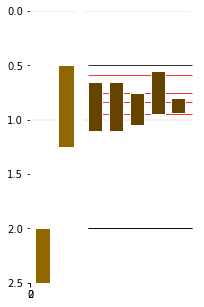

In [167]:
plt.figure(figsize=(3,5),facecolor='w')
ratio_events = 1
ratio_fossils = 0.08
G = gridspec.GridSpec(1,3,hspace=0.0,wspace=0.0, width_ratios =[0.01,2,5])
text_color='#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
# ------------------------------------------------------------------------- epochs
ax1=plt.subplot(G[0,0])
ax1.set_ylim(2.5,0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax1.bar(x = 0, height = value[1] - value[0], width = 2, bottom = epochbase, align = 'edge', edgecolor = '#d6d6d6', facecolor = geol_col_dict[key][0], lw = 1, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
# for key,value in geol_time_dict.items():
#     ax1.bar(x = 0, height = value[1] - value[0], width = 2, bottom = epochbase, align = 'edge', edgecolor = '#d6d6d6', facecolor = geol_col_dict[key][0], lw = 1, alpha = 1, zorder = 10)
#     epochbase += value[1] - value[0]
#     ax1.text(x = ax1.get_xlim()[1]*0.2, y = epochbase + (value[1] - value[0])*0.5, s = geol_col_dict[key][1], fontsize = 8, color = 'k', rotation = 90, zorder = 100)
# ax1.set_yticks(ticks = [mya for mya in range(0,int(ax1.get_ylim()[0]),50)]); plt.yticks(color = '#787878', fontsize = 12)
xbase = 0
for i,event in enumerate(holocene_order):
    print(i,event)
    ax=plt.subplot(G[0,i + 1])
    ax.set_ylim(2.5,0)
    
    temp = holocene[holocene.type == event]
    for row in temp.itertuples():
        height = row.start_ka_bp - row.end_ka_bp
        width = 0.2
        bottom = row.end_ka_bp
        ax.bar(x = xbase, height = height, width = width, bottom = bottom, align = 'center', facecolor = holo_col[event], edgecolor = 'w', lw = 1, alpha = 1, zorder = 4)
        xbase += 0.3
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_xticks([])
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),1)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    ax.set_yticks([])
    
    if i == 1:
        for key,values in line_events.items():
            ax.hlines(y = values, xmin = 0.5, xmax = 2, color = 'k', lw = 0.8, ls = '-')
        for key,values in last_records.items():
            ax.hlines(y = values, xmin = 0.5, xmax = 2, color = 'r', lw = 0.8, ls = '-')

plt.savefig('./holocene3.svg',dpi=300)
plt.show()


['Amphibians', 'Arthropods', 'Birds', 'Bony fishes', 'Ferns', 'Flatworms', 'Flowering plants', 'Mammals', 'Molluscs', 'Reptiles']
0 Mammals


C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1 Birds
2 Flowering plants
3 Reptiles
4 Other plants
5 Dinosaurs
6 Bony fishes


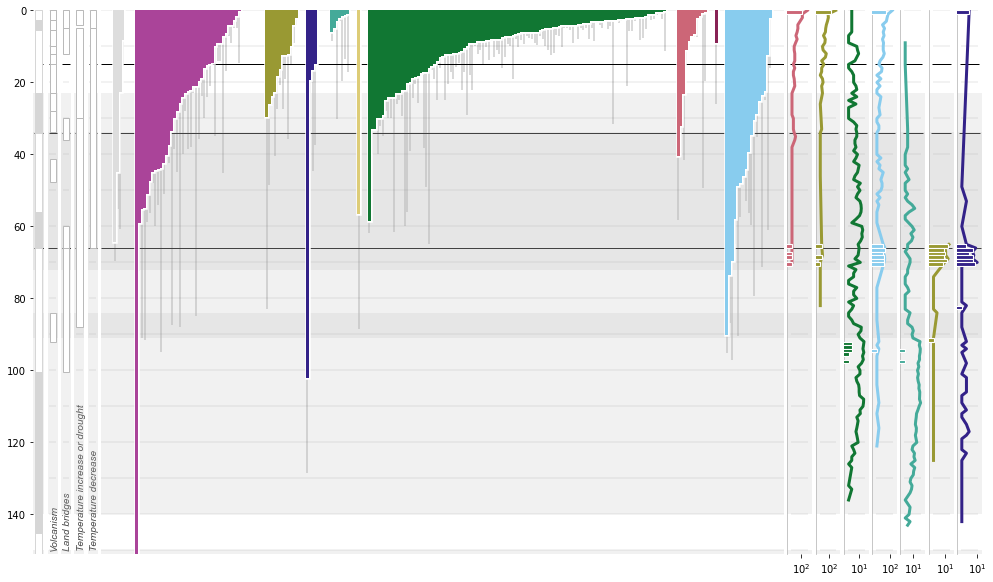

In [37]:
plt.figure(figsize=(17,10),facecolor='w')
ratio_events = 0.032
ratio_fossils = 0.08
G = gridspec.GridSpec(1,13,hspace=0.0,wspace=0.05, width_ratios =[0.035,ratio_events,ratio_events,ratio_events,ratio_events,2.2,
                                                                  ratio_fossils,ratio_fossils,ratio_fossils,ratio_fossils,ratio_fossils,ratio_fossils,ratio_fossils])
text_color='#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = 'w'
# ------------------------------------------------------------------------- epochs
ax1=plt.subplot(G[0,0])
ax1.set_ylim(round(extant['crown_age_plot'].max()),0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax1.bar(x = 0, height = value[1] - value[0], width = 2, bottom = epochbase, align = 'edge', edgecolor = '#d6d6d6', facecolor = geol_col_dict[key][0], lw = 1, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
#     ax1.text(x = ax1.get_xlim()[1]*0.2, y = epochbase + (value[1] - value[0])*0.5, s = geol_col_dict[key][1], fontsize = 8, color = 'k', rotation = 90, zorder = 100)
# ax1.set_yticks(ticks = [mya for mya in range(0,int(ax1.get_ylim()[0]),50)]); plt.yticks(color = '#787878', fontsize = 12)
# ------------------------------------------------------------------------- volcanos
ax2=plt.subplot(G[0,1])
ax2.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(volcanism, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax2, levels = 1)
ax2.text(x=(ax2.get_xlim()[1]/2),y=ax2.get_ylim()[0]-1,s='Volcanism',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')
# ------------------------------------------------------------------------- landbridges
ax3=plt.subplot(G[0,2])
ax3.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(landbridges, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax3, levels = 1)
ax3.text(x=(ax3.get_xlim()[1]/2),y=ax3.get_ylim()[0]-1,s='Land bridges',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')
# ------------------------------------------------------------------------- weather warmer
ax4=plt.subplot(G[0,3])
ax4.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(warmer, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax4, levels = 1)
ax4.text(x=(ax4.get_xlim()[1]/2),y=ax4.get_ylim()[0]-1,s='Temperature increase or drought',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')
# ------------------------------------------------------------------------- weather colder
ax5=plt.subplot(G[0,4])
ax5.set_ylim(round(extant['crown_age_plot'].max()),0)
addvolcanos(colder, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax5, levels = 1)
ax5.text(x=(ax5.get_xlim()[1]/2),y=ax5.get_ylim()[0]-1,s='Temperature decrease',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')
# ------------------------------------------------------------------------- extant
whitedict = {key:'#ffffff' for key in orcoldict.keys()}
# greydict = {key:'#787878' for key in orcoldict.keys()}
ax6=plt.subplot(G[0,5])
ax6.set_ylim(round(extant['crown_age_plot'].max()),0);plt.gca().invert_yaxis()
lineageplot(extant, ax = ax6, colby = 'Group', colbydict = whitedict, by = 'Group', byorder = sorted(extant_span.keys()), unit = 'Lineage', crown = 'crown_age_plot', stem = 'crown_age_plot',
          width = 1.05, bottom = 0, xbase = 0, offset = 3,span = '', tickrange = 50, lw = 2.5, edgecolor = 'w');plt.gca().invert_yaxis() # extant_span
lineageplot(extant, ax = ax6, colby = 'Group', colbydict = orcoldict, by = 'Group', byorder = sorted(extant_span.keys()), unit = 'Lineage', crown = 'crown_age_plot', stem = 'stem_age_plot',
          width = 1.05, bottom = 0, xbase = 0, offset = 3,span = '', tickrange = 50, lw = 0.3, edgecolor = 'none') # extant_span
print(sorted(extant_span.keys()))
# for key,value in shadeevents.items():
#         ax.vlines(x = 200, ymin = value[0], ymax = value[1], lw = 1, color ='k')
# ------------------------------------------------------------------------- fossil

ylim = 150
unit = 'taxon_name'
height = 1
cleandf['timebin'] = pd.cut(cleandf['rand_ma'],labels = False, bins = round(cleandf['rand_ma'].max()))
endemicdb = cleandf[cleandf['cc']=='MG']
xbase = 0
for index,phy in enumerate(cleandf['common_name'].unique()):
    print(index,phy)
    temp = cleandf[cleandf['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    endtemp = endemicdb[endemicdb['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    
    ax=plt.subplot(G[0,6 + index])
    ax.set_ylim(round(extant['crown_age_plot'].max()),0)
#     ax.plot(temp[unit], temp['timebin'], color = common_names_col[phy], zorder = 8, lw = 5, alpha = 0.3)
    ax.plot(temp[unit], temp['timebin'], color = common_names_col[phy], zorder = 9, lw = 3)
    for timebin in endtemp['timebin'].unique():
        endtemp1 = endtemp[endtemp['timebin'] == timebin]
        bottom = 0
        widthend = endtemp1[unit]
        ax.barh(y = timebin, width = widthend, height = height, left = bottom + xbase, align = 'edge', 
                facecolor = common_names_col[phy], edgecolor = 'w',zorder = 11, lw = 1.1, alpha = 1)
    xbase += 0 
    plt.xscale('log')
    ax.set_yticks([])
    [ax.spines[loc].set_visible(False) for loc in ['top','right','bottom']] 
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
    for key,value in lineevents.items():
        ax.hlines(y = value, xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 1, color = 'k')
    for key,value in shadeevents.items():
        ax.axhspan(ymin = value[0], ymax = value[1], alpha=0.2, facecolor = '#bababa', edgecolor = 'none', zorder = 5)  
    for spine in ax.spines.values():
        spine.set_edgecolor('#bababa')

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_xticks([])
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
    for key,value in shadeevents.items():
        ax.axhspan(ymin = value[0], ymax = value[1], alpha=0.2, facecolor = '#bababa', edgecolor = 'none', zorder = 5)
    for key,value in lineevents.items():
        ax.hlines(y = value, xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 1, color = 'k')
    if ax != ax1:
        ax.set_yticks([])
# plt.savefig('./template1.svg',dpi=300)
plt.show()


In [25]:
extant['Group'].unique()

array(['Arthropods', 'Bony fishes', 'Reptiles', 'Amphibians',
       'Flowering plants', 'Flatworms', 'Mammals', 'Birds', 'Molluscs',
       'Ferns'], dtype=object)

In [108]:
set(sum([x for x in extant['origin_plot'].str.split('\/')],[]))

# lineage origin color dictionary
origins_uncert = ['Africa_Certain', 'Africa_Uncertain', 'Eurasia_Certain', 'Eurasia_Uncertain',
           'Indopacific_Certain', 'Indopacific_Uncertain', 'Neotropics_Certain', 'Neotropics_Uncertain',
           'North America_Certain', 'North America_Uncertain']
orcoldictunique = colourDict(origins_uncert, cmap=mpl.cm.tab20c, sort = False)
orcoldictunique['Unknown_Certain'] = '#ffffff'
orcoldictunique

{'Africa_Certain': (0.19215686274509805,
  0.5098039215686274,
  0.7411764705882353,
  1.0),
 'Africa_Uncertain': (0.6196078431372549,
  0.792156862745098,
  0.8823529411764706,
  1.0),
 'Eurasia_Certain': (0.9019607843137255,
  0.3333333333333333,
  0.050980392156862744,
  1.0),
 'Eurasia_Uncertain': (0.9921568627450981,
  0.6823529411764706,
  0.4196078431372549,
  1.0),
 'Indopacific_Certain': (0.19215686274509805,
  0.6392156862745098,
  0.32941176470588235,
  1.0),
 'Indopacific_Uncertain': (0.6313725490196078,
  0.8509803921568627,
  0.6078431372549019,
  1.0),
 'Neotropics_Certain': (0.4588235294117647,
  0.4196078431372549,
  0.6941176470588235,
  1.0),
 'Neotropics_Uncertain': (0.7372549019607844,
  0.7411764705882353,
  0.8627450980392157,
  1.0),
 'North America_Certain': (0.38823529411764707,
  0.38823529411764707,
  0.38823529411764707,
  1.0),
 'North America_Uncertain': (0.7411764705882353,
  0.7411764705882353,
  0.7411764705882353,
  1.0),
 'Unknown_Certain': '#ffffff'

In [107]:
def computeCoordinates(node,x,y,dx,dy):
    """
    Compute treemap compartment coordinates using the squarify library.
    """
    node['x']=x ## assign coordinates to compartment
    node['y']=y
    node['dx']=dx
    node['dy']=dy
        
    if 'children' in node: ## there are children, need to traverse further
        children = sorted(node['children'], key = lambda x: x['size']) ## get children sorted by read count
        children_values = [child['size'] for child in children] ## get read counts for each child
        sizes = squarify.normalize_sizes(children_values + [node['size']-sum(children_values)], dx, dy)
#         rects=squarify.padded_squarify(sizes,x,y,dx,dy) ## compute rectangles (padded)
        rects=squarify.squarify(sizes,x,y,dx,dy) ## compute rectangles (unpadded)
        for ch,rec in zip(children,rects): ## iterate over children
            x=rec['x']
            y=rec['y']
            dx=rec['dx']
            dy=rec['dy']
            computeCoordinates(ch,x,y,dx,dy) ## recurse
            
def plot(ax,node,parent,previous=None,level=None):
    """
    Plot treemap.
    """
    if previous==None:
        previous=0.0
    if level==None:
        level=0
    
    if 'x' in node:
        x=node['x']
        y=node['y']
        w=node['dx']
        h=node['dy']
        
        if w==0 or h==0:
            print('box %s has zero width or height: %s %s'%(node['children'],w,h))
        
        c=node['color']
#         lw=max([1,(7-level)])
        lw=1
        
        rect=plt.Rectangle((x,y),w,h,facecolor=c,edgecolor='w',
                           alpha=1.0,lw=lw,zorder=level) ## add rectangle
        rotation=0
        if 'id' in node and node['size']>0.3: ## only add names for compartments big enough
            name=node['id']
            if 'children' in node and name!='root':
                    ax.text(x+0.0015,y+h-0.0015,name,ha='left',va='top',
                        size=15,zorder=10,rotation=rotation)
        ax.add_patch(rect)
        ax.plot()
    if 'children' in node:
        level+=1
        for child in node['children']:
            plot(ax,child,node,previous,level) ## recurse

plants
          parents     labels  contribution
0   Africa         Certain    54.000000   
1   Africa         Uncertain  1.510013    
2   Eurasia        Certain    3.000000    
3   Eurasia        Uncertain  0.119048    
4   Indopacific    Certain    15.000000   
5   Indopacific    Uncertain  1.026820    
6   Neotropics     Certain    6.000000    
7   Neotropics     Uncertain  0.549696    
8   North America  Certain    1.000000    
9   North America  Uncertain  0.047619    
10  Unknown        Certain    10.000000   
9.604852707412332 9.604852707412332


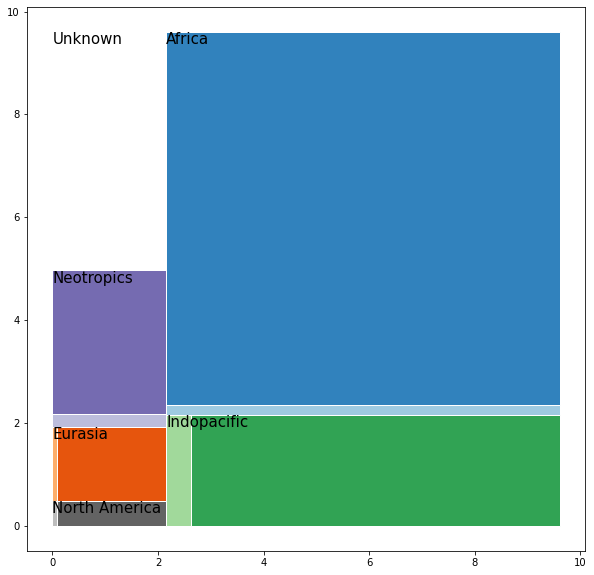

animals
         parents     labels  contribution
0  Africa         Certain    45.000000   
1  Africa         Uncertain  0.611406    
2  Eurasia        Uncertain  0.234818    
3  Indopacific    Certain    14.000000   
4  Indopacific    Uncertain  0.860210    
5  Neotropics     Certain    5.000000    
6  Neotropics     Uncertain  0.167059    
7  North America  Uncertain  0.041667    
8  Unknown        Certain    17.000000   
9.1057761061574 9.1057761061574


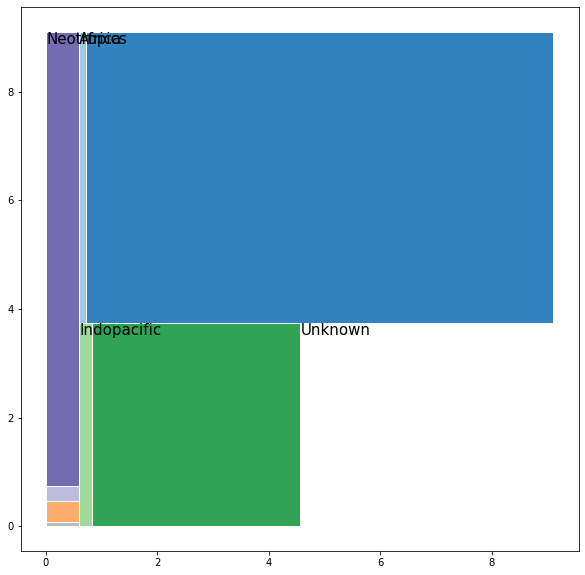

In [110]:
import plotly.express as px
import numpy as np
import json,copy
import squarify

# For plants
plants = ['Ferns','Flowering plants']
animals = ['Arthropods', 'Bony fishes', 'Reptiles', 'Amphibians','Flatworms', 'Mammals', 'Birds', 'Molluscs']

# treemap for number of records per origin
plantdf = extant[extant['Group'].isin(plants)]
animalsdf = extant[extant['Group'].isin(animals)]

for dataframe in [plantdf,animalsdf]:
    parents = []
    labels = []
    colors = []
    contribution = []
    print('%s'%('plants' if dataframe is plantdf else 'animals'))
    for row in dataframe.itertuples():
        if '/' in row.origin_plot:
            for i in row.origin_plot.split('/'):
                parents.append(i)
                labels.append('Uncertain')
                colors.append(orcoldictunique['%s_Uncertain'%(i)])
                contribution.append(1/(len(row.origin_plot)))
        else:
            parents.append(row.origin_plot)
            labels.append('Certain')
            colors.append(orcoldictunique['%s_Certain'%(row.origin_plot)])
            contribution.append(1)
    ordata = pd.DataFrame(list(zip(parents,labels,colors,contribution)),columns = ['parents','labels','colors','contribution'])
    grouped = ordata.groupby(by = ['parents','labels'])['contribution'].sum().reset_index()
    print(grouped)
    
    jsondata = {}
    jsondata['id'] = 'root'
    jsondata['size'] = grouped['contribution'].sum()
    jsondata['color'] = 'none'
    levellist1 = [] # list of level+1 dictionaries
    for parent in grouped.parents.unique():
        temp1 = grouped[grouped.parents == parent]
        level1 = {}
        level1['id'] = parent
        level1['size'] = temp1['contribution'].sum()
        level1['color'] = 'none'
        
        levellist2 = [] # list of level 2 dictionaries
        for label in temp1.labels.unique():
            level2 = {}
            level2['id'] = label
            level2['size'] = float(temp1[temp1.labels == label]['contribution'].values)
            level2['color'] = orcoldictunique['%s_%s'%(parent,label)]
            levellist2.append(level2)
            
        level1['children'] = levellist2
        
        levellist1.append(level1)
#         print(parent)
    jsondata['children'] = levellist1
    
    fig,ax = plt.subplots(figsize = (10,10), facecolor = 'w')
    
    dx = np.sqrt(jsondata['size'])
    dy = np.sqrt(jsondata['size'])
    print(dx,dy)
    
    computeCoordinates(jsondata, 0, 0, dx, dy)
    plot(ax,jsondata,None)
    
    plt.savefig('./%s_origins1.svg'%('plants' if dataframe is plantdf else 'animals'), dpi = 300)
    plt.show()

In [61]:
import plotly.express as px

# For plants
plants = ['Ferns','Flowering plants']
animals = ['Arthropods', 'Bony fishes', 'Reptiles', 'Amphibians','Flatworms', 'Mammals', 'Birds', 'Molluscs']

# treemap for number of records per origin
plantdf = extant[extant['Group'].isin(plants)]
animalsdf = extant[extant['Group'].isin(animals)]

for dataframe in [plantdf,animalsdf]:
    parents = []
    labels = []
    colors = []
    contribution = []
    print('%s'%('plants' if dataframe is plantdf else 'animals'))
    for row in dataframe.itertuples():
        if '/' in row.origin_plot:
            for i in row.origin_plot.split('/'):
                parents.append(i)
                labels.append('Uncertain')
                colors.append(orcoldictunique['%s_uncert'%(i)])
                contribution.append(1/(len(row.origin_plot)))
        else:
            parents.append(row.origin_plot)
            labels.append('Certain')
            colors.append(orcoldictunique[row.origin_plot])
            contribution.append(1)
    ordata = pd.DataFrame(list(zip(parents,labels,colors,contribution)),columns = ['parents','labels','colors','contribution'])
    print(ordata.groupby(by = ['parents','labels'])['contribution'].sum().reset_index())
    
    fig = px.treemap(ordata, path = ['parents', 'labels'], values = 'contribution', color = 'parents', width = 700, height = 700, branchvalues = 'total', hover_data = {'parents':False})
    fig.update_layout(uniformtext = dict(minsize=10, mode='hide'))
#     fig.write_image('./%s_origins1.svg'%('plants' if dataframe is plantdf else 'animals'))

#     plt.savefig('./%s_origins1.svg'%('plants' if dataframe is plantdf else 'animals'), dpi = 300)
#                      treemapcolorway = ['']
#                     color_discrete_map = orcoldictunique)
    fig.show()

plants
          parents     labels  contribution
0   Africa         Certain    54.000000   
1   Africa         Uncertain  1.510013    
2   Eurasia        Certain    3.000000    
3   Eurasia        Uncertain  0.119048    
4   Indopacific    Certain    15.000000   
5   Indopacific    Uncertain  1.026820    
6   Neotropics     Certain    6.000000    
7   Neotropics     Uncertain  0.549696    
8   North America  Certain    1.000000    
9   North America  Uncertain  0.047619    
10  Unknown        Certain    10.000000   


animals
         parents     labels  contribution
0  Africa         Certain    45.000000   
1  Africa         Uncertain  0.611406    
2  Eurasia        Uncertain  0.234818    
3  Indopacific    Certain    14.000000   
4  Indopacific    Uncertain  0.860210    
5  Neotropics     Certain    5.000000    
6  Neotropics     Uncertain  0.167059    
7  North America  Uncertain  0.041667    
8  Unknown        Certain    17.000000   


certain OrderedDict([('Indopacific', 15.0), ('Africa', 54.0), ('Eurasia', 3.0), ('Neotropics', 6.0), ('North America', 1.0), ('Unknown', 10.0)])
uncertain OrderedDict([('Africa_uncert', 13.333333333333334), ('Indopacific_uncert', 9.333333333333332), ('Neotropics_uncert', 4.833333333333334), ('Eurasia_uncert', 1.0), ('North America_uncert', 0.5)])
total area certain 89 9.433981132056603
total area uncertain 28.999999999999996 5.385164807134504


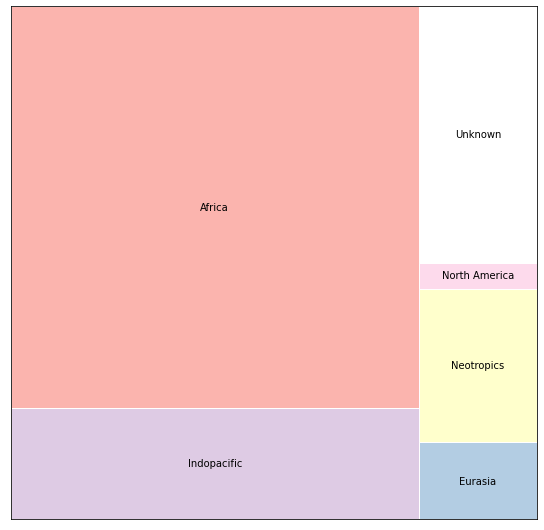

certain OrderedDict([('Indopacific', 14.0), ('Unknown', 17.0), ('Africa', 45.0), ('Neotropics', 5.0)])
uncertain OrderedDict([('Neotropics_uncert', 1.8333333333333333), ('Indopacific_uncert', 8.0), ('Africa_uncert', 5.5), ('Eurasia_uncert', 2.1666666666666665), ('North America_uncert', 0.5)])
total area certain 81 9.0
total area uncertain 18.0 4.242640687119285


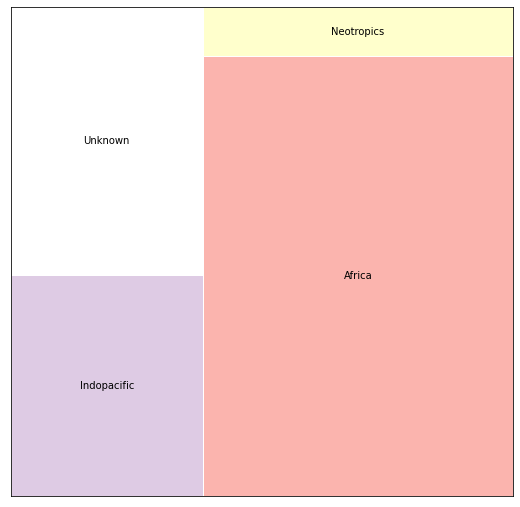

In [54]:
import squarify
from collections import OrderedDict
import math


# For plants
plants = ['Ferns','Flowering plants']
animals = ['Arthropods', 'Bony fishes', 'Reptiles', 'Amphibians','Flatworms', 'Mammals', 'Birds', 'Molluscs']

# treemap for number of records per origin
plantdf = extant[extant['Group'].isin(plants)]
animalsdf = extant[extant['Group'].isin(animals)]

for dataframe in [plantdf,animalsdf]:
    sitescounts = OrderedDict()
    uncertaincounts = OrderedDict()
    areauncertain = 0
    areacertain = 0
    for row in dataframe.itertuples():
        if '/' not in row.origin_plot:
#             print(row.origin_plot,'not /')
            if row.origin_plot not in sitescounts.keys():
                sitescounts[row.origin_plot] = 1/len(row.origin_plot.split('/')) # should equal to one since len is 1
                areacertain += 1
            else:
                sitescounts[row.origin_plot] = sitescounts[row.origin_plot] + 1/len(row.origin_plot.split('/'))
                areacertain += 1
        else:
            for site in row.origin_plot.split('/'):
#                 print(print(site,'with /'))
                if '%s_uncert'%(site) not in uncertaincounts.keys():
                    uncertaincounts['%s_uncert'%(site)] = 1/len(row.origin_plot.split('/'))
                    areauncertain += 1/len(row.origin_plot.split('/'))
                else:
                    uncertaincounts['%s_uncert'%(site)] = uncertaincounts['%s_uncert'%(site)] + 1/len(row.origin_plot.split('/'))
                    areauncertain += 1/len(row.origin_plot.split('/'))
                                           
    print('certain',sitescounts)
    print('uncertain',uncertaincounts)
    print('total area certain',areacertain, math.sqrt(areacertain))
    print('total area uncertain',areauncertain, math.sqrt(areauncertain))

    fig,ax = plt.subplots(figsize = (math.sqrt(areacertain),math.sqrt(areacertain)), facecolor = 'w')
#     plt.title('plants' if dataframe is plantdf else 'animals')
    
    colors = [orcoldictunique[key] for key in sitescounts.keys()]
    ax = squarify.plot(sizes = sitescounts.values(),label = sitescounts.keys(), color = colors, pad = 0, bar_kwargs=dict(linewidth=1, edgecolor='w'))
    
#     for rect,text in zip(ax.patches, ax.texts):
#         x, y, w, h = rect.get_x(), rect.get_y(), rect.get_width(), rect.get_height()
#         t = text.get_text()
#         if t == 'Multiple':
#             print(t,x,y,w,h)
    
#     [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_yticks([])
    ax.set_xticks([])
    plt.savefig('./%s_origins1.svg'%('plants' if dataframe is plantdf else 'animals'), dpi = 300)
    plt.show()

certain OrderedDict([('Indopacific', 15.0), ('Africa', 54.0), ('Eurasia', 3.0), ('Neotropics', 6.0), ('North America', 1.0), ('Unknown', 10.0)])
uncertain OrderedDict([('Africa_uncert', 13.333333333333334), ('Indopacific_uncert', 9.333333333333332), ('Neotropics_uncert', 4.833333333333334), ('Eurasia_uncert', 1.0), ('North America_uncert', 0.5)])
total area certain 89 9.433981132056603
total area uncertain 28.999999999999996 5.385164807134504


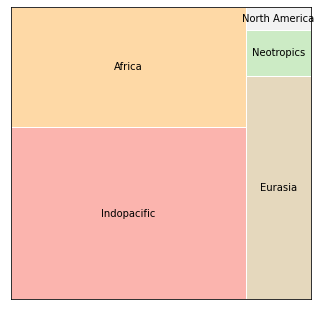

certain OrderedDict([('Indopacific', 14.0), ('Unknown', 17.0), ('Africa', 45.0), ('Neotropics', 5.0)])
uncertain OrderedDict([('Neotropics_uncert', 1.8333333333333333), ('Indopacific_uncert', 8.0), ('Africa_uncert', 5.5), ('Eurasia_uncert', 2.1666666666666665), ('North America_uncert', 0.5)])
total area certain 81 9.0
total area uncertain 18.0 4.242640687119285


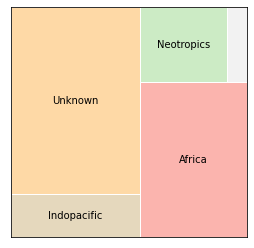

In [53]:
import squarify
from collections import OrderedDict
import math


# For plants
plants = ['Ferns','Flowering plants']
animals = ['Arthropods', 'Bony fishes', 'Reptiles', 'Amphibians','Flatworms', 'Mammals', 'Birds', 'Molluscs']

# treemap for number of records per origin
plantdf = extant[extant['Group'].isin(plants)]
animalsdf = extant[extant['Group'].isin(animals)]

for dataframe in [plantdf,animalsdf]:
    sitescounts = OrderedDict()
    uncertaincounts = OrderedDict()
    areauncertain = 0
    areacertain = 0
    for row in dataframe.itertuples():
        if '/' not in row.origin_plot:
#             print(row.origin_plot,'not /')
            if row.origin_plot not in sitescounts.keys():
                sitescounts[row.origin_plot] = 1/len(row.origin_plot.split('/')) # should equal to one since len is 1
                areacertain += 1
            else:
                sitescounts[row.origin_plot] = sitescounts[row.origin_plot] + 1/len(row.origin_plot.split('/'))
                areacertain += 1
        else:
            for site in row.origin_plot.split('/'):
#                 print(print(site,'with /'))
                if '%s_uncert'%(site) not in uncertaincounts.keys():
                    uncertaincounts['%s_uncert'%(site)] = 1/len(row.origin_plot.split('/'))
                    areauncertain += 1/len(row.origin_plot.split('/'))
                else:
                    uncertaincounts['%s_uncert'%(site)] = uncertaincounts['%s_uncert'%(site)] + 1/len(row.origin_plot.split('/'))
                    areauncertain += 1/len(row.origin_plot.split('/'))
                                           
    print('certain',sitescounts)
    print('uncertain',uncertaincounts)
    print('total area certain',areacertain, math.sqrt(areacertain))
    print('total area uncertain',areauncertain, math.sqrt(areauncertain))

    fig,ax = plt.subplots(figsize = (math.sqrt(areauncertain),math.sqrt(areauncertain)), facecolor = 'w')
#     plt.title('plants' if dataframe is plantdf else 'animals')
    
    colors = [orcoldictunique['%s'%(key)] for key in uncertaincounts.keys()]
    ax = squarify.plot(sizes = uncertaincounts.values(),label = sitescounts.keys(), color = colors, pad = 0, bar_kwargs=dict(linewidth=1, edgecolor='w'))
    
#     for rect,text in zip(ax.patches, ax.texts):
#         x, y, w, h = rect.get_x(), rect.get_y(), rect.get_width(), rect.get_height()
#         t = text.get_text()
#         if t == 'Multiple':
#             print(t,x,y,w,h)
    
#     [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_yticks([])
    ax.set_xticks([])
    plt.savefig('./%s_originsuncert.svg'%('plants' if dataframe is plantdf else 'animals'), dpi = 300)
    plt.show()

OrderedDict([('Indopacific', 15.0), ('Africa', 54.0), ('Africa_uncert', 13.333333333333334), ('Indopacific_uncert', 9.333333333333332), ('Eurasia', 3.0), ('Neotropics_uncert', 4.833333333333334), ('Neotropics', 6.0), ('North America', 1.0), ('Unknown', 10.0), ('Eurasia_uncert', 1.0), ('North America_uncert', 0.5)])


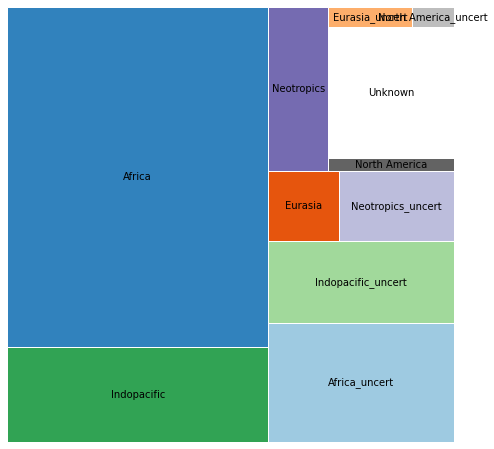

OrderedDict([('Indopacific', 14.0), ('Unknown', 17.0), ('Africa', 45.0), ('Neotropics_uncert', 1.8333333333333333), ('Indopacific_uncert', 8.0), ('Africa_uncert', 5.5), ('Eurasia_uncert', 2.1666666666666665), ('Neotropics', 5.0), ('North America_uncert', 0.5)])


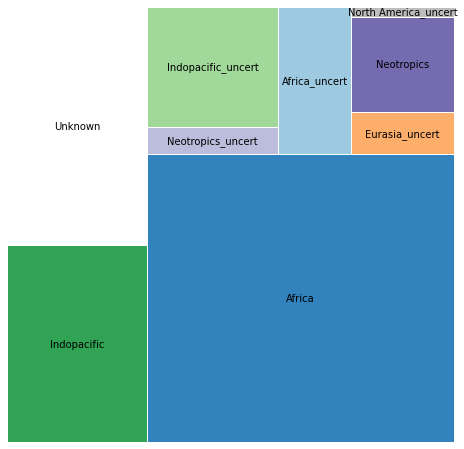

In [264]:
import squarify
from collections import OrderedDict

# For plants
plants = ['Ferns','Flowering plants']
animals = ['Arthropods', 'Bony fishes', 'Reptiles', 'Amphibians','Flatworms', 'Mammals', 'Birds', 'Molluscs']

# treemap for number of records per origin
plantdf = extant[extant['Group'].isin(plants)]
animalsdf = extant[extant['Group'].isin(animals)]

for dataframe in [plantdf,animalsdf]:
    sitescounts = OrderedDict()
    for row in dataframe.itertuples():
        if '/' not in row.origin_plot:
#             print(row.origin_plot,'not /')
            if row.origin_plot not in sitescounts.keys():
                sitescounts[row.origin_plot] = 1/len(row.origin_plot.split('/'))
            else:
                sitescounts[row.origin_plot] = sitescounts[row.origin_plot] + 1/len(row.origin_plot.split('/'))
        else:
            for site in row.origin_plot.split('/'):
#                 print(print(site,'with /'))
                if '%s_uncert'%(site) not in sitescounts.keys():
                    sitescounts['%s_uncert'%(site)] = 1/len(row.origin_plot.split('/'))
                else:
                    sitescounts['%s_uncert'%(site)] = sitescounts['%s_uncert'%(site)] + 1/len(row.origin_plot.split('/'))

    print(sitescounts)

    fig,ax = plt.subplots(figsize = (8,8), facecolor = 'w')
#     plt.title('plants' if dataframe is plantdf else 'animals')
    
    colors = [orcoldictunique[key] for key in sitescounts.keys()]
    ax = squarify.plot(sizes = sitescounts.values(),label = sitescounts.keys(), color = colors, pad = 0, bar_kwargs=dict(linewidth=1, edgecolor='w'))
    
#     for rect,text in zip(ax.patches, ax.texts):
#         x, y, w, h = rect.get_x(), rect.get_y(), rect.get_width(), rect.get_height()
#         t = text.get_text()
#         if t == 'Multiple':
#             print(t,x,y,w,h)
    
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_yticks([])
    ax.set_xticks([])
    plt.savefig('./%s_origins.svg'%('plants' if dataframe is plantdf else 'animals'), dpi = 300)
    plt.show()

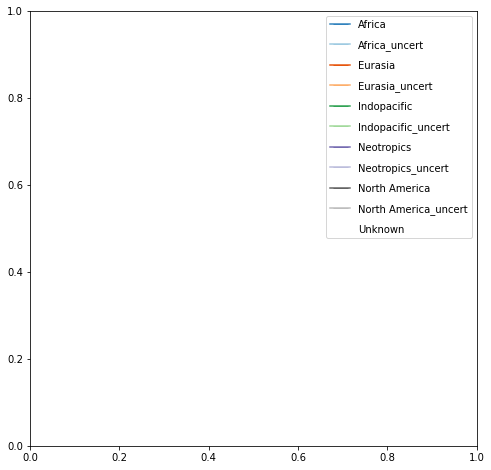

In [268]:
fig,ax = plt.subplots(figsize = (8,8), facecolor = 'w')

legend_elements=[]
for key,value in orcoldictunique.items():
    legend_elements.append(Line2D([0],[0],marker='_',color=value,label=key,markersize=15))
ax.legend(handles = legend_elements, loc = 'best', labelspacing=1)
plt.savefig('./all_origins_legend.svg', dpi = 300)

plt.show()

In [258]:
extant[extant['origin_plot'].isna()]

Empty DataFrame
Columns: [index, Group, Family, Lineage, origin_plot, Origin_or_sister_distribution, Mad_endemics, Non_Mad_endemics, Crown_age, crown_age_plot, Stem_age, stem_age_plot, Source_short, Source_DOI_URL]
Index: []

In [239]:
orcoldictunique

{'Africa': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667, 1.0),
 'Eurasia': (0.8509803921568627,
  0.37254901960784315,
  0.00784313725490196,
  1.0),
 'Indopacific': (0.9058823529411765,
  0.1607843137254902,
  0.5411764705882353,
  1.0),
 'Neotropics': (0.4, 0.6509803921568628, 0.11764705882352941, 1.0),
 'North America': (0.6509803921568628,
  0.4627450980392157,
  0.11372549019607843,
  1.0),
 'Unknown': '#ffffff'}

In [311]:
# holocene
holocene_climate = {'Wetter and more humid period':[20000,36000],
                   'Drier conditions':[20000,15000],
                   'Warmer and more humid period':[15000,117000],
                   'Wetter conditions':[8200,4200],
                   'Increasing drought':[3500,0]}
holocene_veg = {'Mosaic landscape, abundant grasses':[20000,15000],
               'Mosaic landscape':[15000,11700],
               'Mosaic landscape, wood-, bush- and grasslands':[8200,4200],
               'Opening of ecosystem':[1200,0]}
hol_time_dict={'Meghalayan':[0,4200],# in thousands of years ka
              'Northgrippian':[4200,8200],
              'Greenlandian':[8200,11700],
              'Pleistocene':[11700,40000]} # 40 isnt the end of the pleistocene but this is for plotting purposes
hol_col_dict={'Meghalayan':['#ffffff','Meg'], # dark grey
               'Northgrippian':['#d6d6d6','Nor'], # light grey
               'Greenlandian':['#ffffff','Gre'],
             'Pleistocene':['#d6d6d6','Ple']}

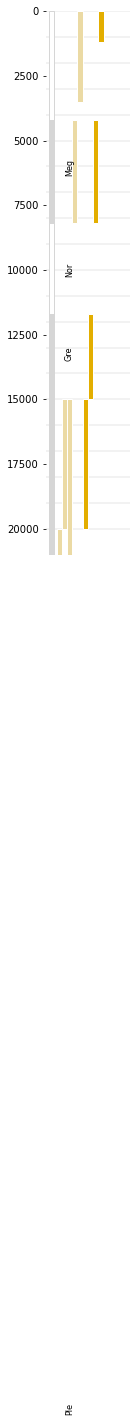

In [323]:
fig, ax = plt.subplots(figsize = (1.5,10))
ax.set_ylim(21000,0)
ax.set_xlim(-0.5,15.5)

ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),1000)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)

epochbase = 0
for key,value in hol_time_dict.items():
    ax.bar(x = 0, height = value[1] - value[0], width = 1, bottom = epochbase, align = 'edge', edgecolor = '#d6d6d6', facecolor = hol_col_dict[key][0], lw = 1, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
    ax.text(x = ax.get_xlim()[1]*0.2, y = epochbase + (value[1] - value[0])*0.5, s = hol_col_dict[key][1], fontsize = 8, color = 'k', rotation = 90, zorder = 100)

xoffset = 2
for index,(key,value) in enumerate(holocene_climate.items()):
#     print(value)
    ax.bar(x = index + xoffset, height = value[1] - value[0], width = 1, bottom = value[0], align = 'center', edgecolor = 'w', lw = 1, alpha = 1,
                   color = '#ebdaa4', zorder = 100)
    
for index,(key,value) in enumerate(holocene_veg.items()):
#     print(index,key,value)
    ax.bar(x = index + 5 + xoffset, height = value[1] - value[0], width = 1, bottom = value[0], align = 'center', edgecolor = 'w', lw = 1, alpha = 1,
                   color = '#e3ae00', zorder = 100)
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
ax.set_xticks([])
# ax.set_yticks([])
# plt.savefig('./holocene.svg', dpi = 300)
plt.show()

C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


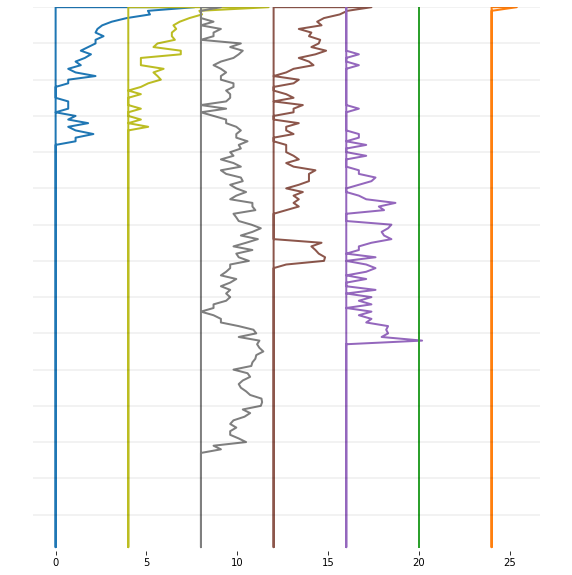

In [115]:
fig, ax = plt.subplots(figsize=(10,10))
# ax = fig.add_subplot(121)

ylim = 150
unit = 'taxon_name'
height = 0.6

cleandf['timebin'] = pd.cut(cleandf['rand_ma'],labels = False, bins = round(cleandf['rand_ma'].max()))
endemicdb = cleandf[cleandf['cc']=='MG']

xbase = 0
for index,phy in enumerate(cleandf['common_name'].unique()):
    temp = cleandf[cleandf['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    endtemp = endemicdb[endemicdb['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    ax.set_ylim(ylim,0)
    
    timebins = range(ylim)
    counts = []
    for tb in timebins:
        if tb in temp['timebin'] and len(temp[temp['timebin'] == tb]) >= 1:
            counts.append(int(temp[temp['timebin'] == tb][unit].values))
        else:
            counts.append(0)
#     ax.plot([np.log(x + 1) + xbase for x in temp[unit]], temp['timebin'], color = common_names_col[phy], zorder = 10, lw = 5, alpha= 0.1)
#     ax.plot([np.log(x + 1) + xbase for x in counts], timebins, color = common_names_col[phy], zorder = 10, lw = 3, alpha = 0.4)
    ax.fill_betweenx(timebins, x1 = [np.log(x + 1) + xbase for x in counts], x2 = xbase,
                         alpha = 1, edgecolor = common_names_col[phy], facecolor = 'none', lw = 2)

#     ax.vlines(xbase, ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], color = common_names_col[phy], zorder = 8, lw = 1, alpha = 0.2)
     
#     for timebin in endtemp['timebin'].unique():
#         endtemp1 = endtemp[endtemp['timebin'] == timebin]
#         bottom = 0
#         widthend = len(endtemp1)
#         ax.barh(y = timebin, width = widthend, height = height, left = bottom + xbase, align = 'edge', facecolor = common_names_col[phy], edgecolor = 'none',zorder = 10, lw = 0.1, alpha = 1)
    xbase += 4
ax.set_yticks([])
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
# legend_elements=[]
# for key,value in common_names_col.items():
#     legend_elements.append(Line2D([0],[0],marker='o',color=value,label=key,markersize=10))
# ax.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.2, 0.5, 0.5, 0.5),labelspacing=1)
# plt.suptitle('Count by unique species',y=0.92)
# plt.savefig('./fossilall.svg',dpi=300)
plt.show()

C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


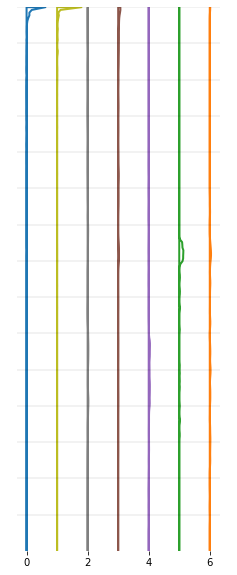

In [78]:
fig, ax = plt.subplots(figsize=(4,10))
# ax = fig.add_subplot(121)

ylim = 150
unit = 'taxon_name'
height = 0.6

cleandf['timebin'] = pd.cut(cleandf['rand_ma'],labels = False, bins = round(cleandf['rand_ma'].max()))
endemicdb = cleandf[cleandf['cc']=='MG']

xbase = 0
for index,phy in enumerate(cleandf['common_name'].unique()):
    tempkde = cleandf[cleandf['common_name'] == phy].groupby(by=['timebin',unit])['index'].count().reset_index()
    endtempkde = endemicdb[endemicdb['common_name'] == phy].groupby(by=['timebin',unit])['index'].count().reset_index()
    ax.set_ylim(ylim,0)
    
    values=tempkde['timebin'].dropna().values
#     kde=gaussian_kde([np.log10(x+1) for x in values])
#     kde=gaussian_kde([x**10 for x in values])
    kde=gaussian_kde(values)
#     y_grid=np.linspace(min(values),max(values),200)
    y_grid=np.linspace(0,ylim,200)
    kde.covariance_factor=lambda:0.04
    kde._compute_covariance()
    ax.fill_betweenx(y_grid, x1 = kde(y_grid) + xbase, x2 = xbase, alpha = 1, edgecolor = common_names_col[phy], facecolor = 'none', lw = 2)

#     values=endtempkde['timebin'].dropna().values
#     kde=gaussian_kde([np.log10(x+1) for x in values])
# #     kde=gaussian_kde(values)
#     y_grid=np.linspace(min(values),max(values),200)
#     kde.covariance_factor=lambda:0.4
#     kde._compute_covariance()
#     ax.fill_betweenx(y_grid, x1 = kde(y_grid) + xbase, alpha = 0.4, edgecolor = common_names_col[phy], facecolor = common_names_col[phy], lw = 3)
    xbase += 1
ax.set_yticks([])
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
# legend_elements=[]
# for key,value in common_names_col.items():
#     legend_elements.append(Line2D([0],[0],marker='o',color=value,label=key,markersize=10))
# ax.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.2, 0.5, 0.5, 0.5),labelspacing=1)
# plt.suptitle('Count by unique species',y=0.92)
# plt.savefig('./fossilall.svg',dpi=300)
plt.show()

C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


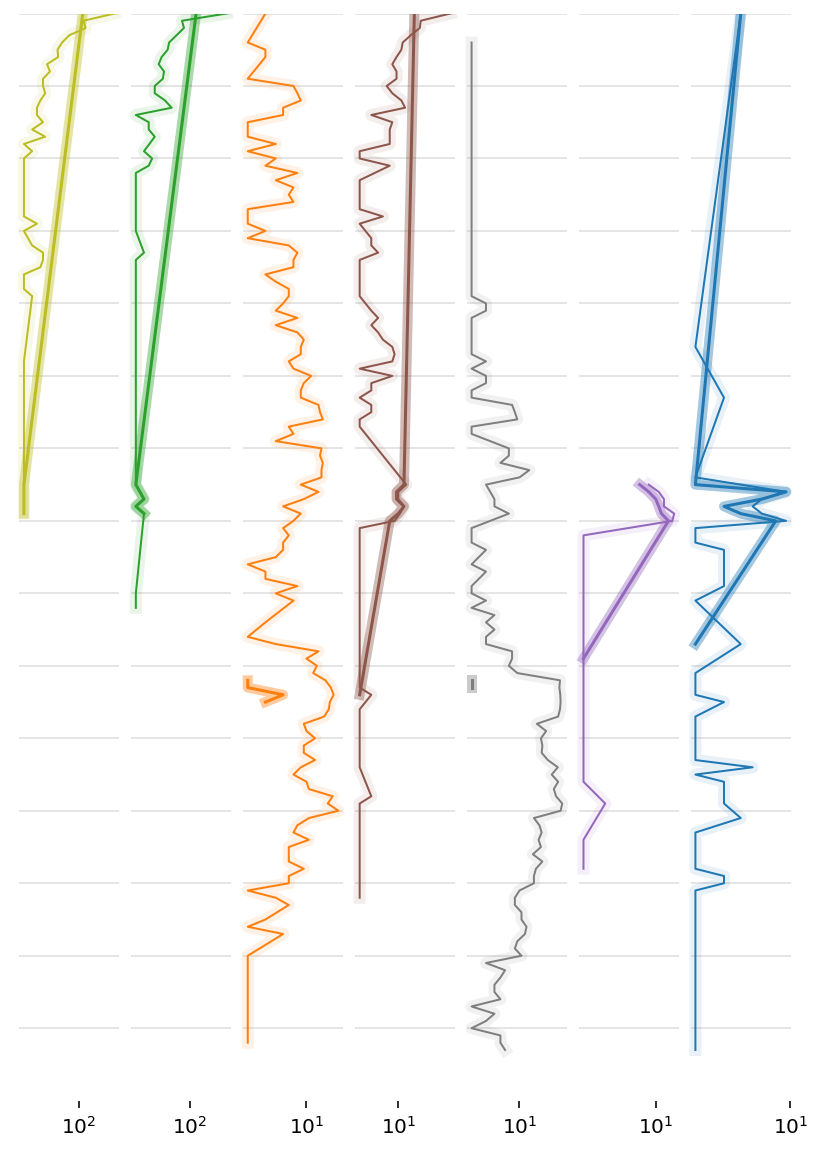

In [212]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def smoothing(x, y):
    lowess_frac = 0.01  # size of data (%) for estimation =~ smoothing window
    lowess_it = 0
    x_smooth = x
    y_smooth = lowess(y, x, is_sorted=False, frac=lowess_frac, it=lowess_it, return_sorted=False)
    return x_smooth, y_smooth

plt.figure(figsize=(7,10),facecolor='w')
G = gridspec.GridSpec(1,len(cleandf['common_name'].unique()),hspace=0.1,wspace=0.02)
# fig, axes = plt.subplots(nrows=1, ncols=len(fossil['common_name'].unique()), figsize=(5,10), sharex=False, sharey=True)

ylim = 150
unit = 'taxon_name'

cleandf['timebin'] = pd.cut(cleandf['rand_ma'],labels = False, bins = round(cleandf['rand_ma'].max()))
endemicdb = cleandf[cleandf['cc']=='MG']

for index,phy in enumerate(cleandf['common_name'].unique()):
    temp = cleandf[cleandf['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    endtemp = endemicdb[endemicdb['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    
    ax=plt.subplot(G[0,index])
    ax.set_ylim(ylim,0)
    
    smooth = smoothing(temp['timebin'], temp[unit])
    smoothend = smoothing(endtemp['timebin'], endtemp[unit])
    
    ax.plot(smooth[1], smooth[0], color = common_names_col[phy], zorder = 10, lw = 6, alpha= 0.1)
    ax.plot(smooth[1], smooth[0], color = common_names_col[phy], zorder = 10, lw = 1)
    ax.plot(smoothend[1], smoothend[0], color = common_names_col[phy], zorder = 10, lw = 5, alpha= 0.4)
    ax.plot(smoothend[1], smoothend[0], color = common_names_col[phy], zorder = 10, lw = lw+1)

    plt.xscale('log')
    ax.set_yticks([])
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
# legend_elements=[]
# for key,value in common_names_col.items():
#     legend_elements.append(Line2D([0],[0],marker='o',color=value,label=key,markersize=10))
# ax.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.2, 0.5, 0.5, 0.5),labelspacing=1)
# plt.suptitle('Count by unique fossil records',y=0.92)
# # plt.savefig('./fossilall.svg',dpi=300)
plt.show()

C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\xtorrm\Documents\Python3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\xtorrm\Documents\Python3\lib\site-packages\scipy\interpolate\interpolate.py:447: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-t

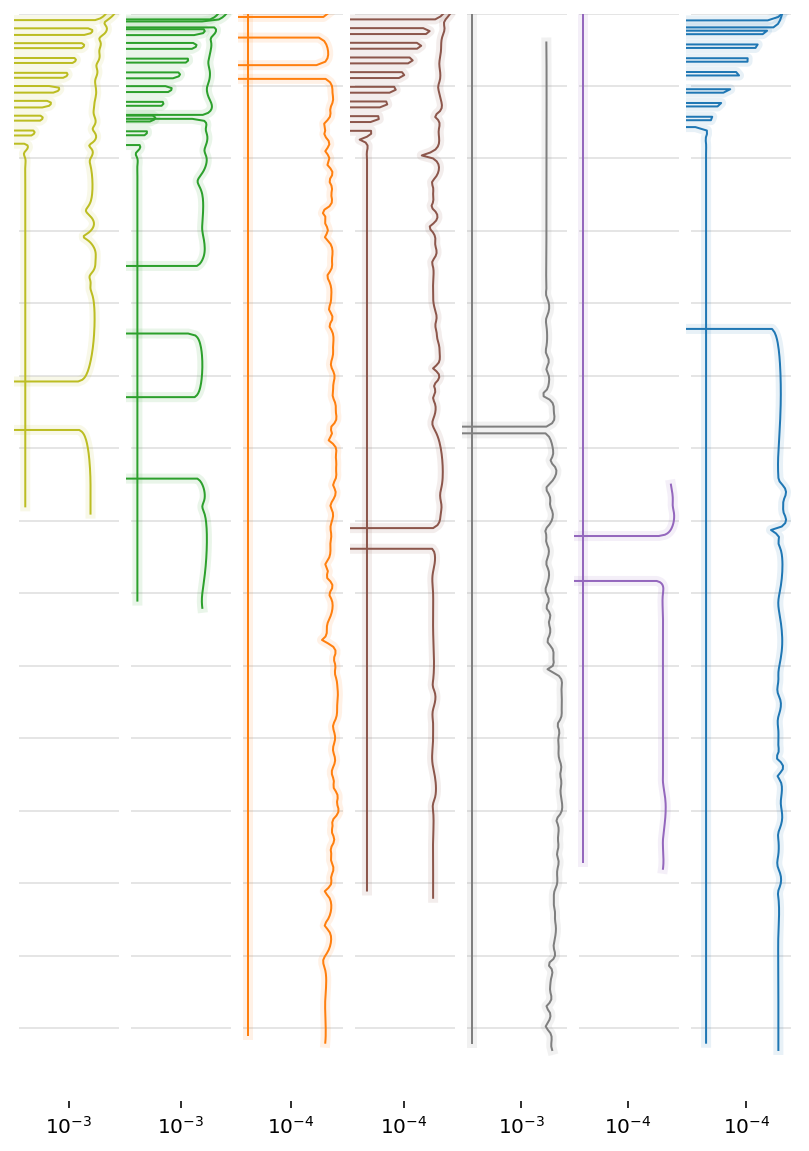

In [218]:
from scipy.interpolate import interp1d

plt.figure(figsize=(7,10),facecolor='w')
G = gridspec.GridSpec(1,len(cleandf['common_name'].unique()),hspace=0.1,wspace=0.02)
# fig, axes = plt.subplots(nrows=1, ncols=len(fossil['common_name'].unique()), figsize=(5,10), sharex=False, sharey=True)

ylim = 150
unit = 'taxon_name'

cleandf['timebin'] = pd.cut(cleandf['rand_ma'],labels = False, bins = round(cleandf['rand_ma'].max()))
endemicdb = cleandf[cleandf['cc']=='MG']

for index,phy in enumerate(cleandf['common_name'].unique()):
    temp = cleandf[cleandf['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    endtemp = endemicdb[endemicdb['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()

    ax=plt.subplot(G[0,index])
    ax.set_ylim(ylim,0)
    
    xnew = np.linspace(temp['timebin'].min(), temp['timebin'].max(), 300)
    f_cubic = interp1d(temp['timebin'].values, [x+0.000000001 for x in temp[unit].values], kind='cubic')
    ax.plot(f_cubic(xnew), xnew, color = common_names_col[phy], zorder = 10, lw = 5, alpha= 0.1)
    ax.plot(f_cubic(xnew), xnew, color = common_names_col[phy], zorder = 10, lw = 1)
    
    timebins = range(temp['timebin'].max())
    counts = []
    for tb in timebins:
        if tb in endtemp['timebin'] and len(endtemp[endtemp['timebin'] == tb][unit]) >=1:
            counts.append(endtemp[endtemp['timebin'] == tb][unit].values)
        else:
            counts.append(0)
    
#     xnew = np.linspace(endtemp['timebin'].min(), endtemp['timebin'].max(), 300)
#     f_cubic = interp1d(endtemp['timebin'].values, [x+0.000000001 for x in endtemp[unit].values], kind='cubic')
    xnew = np.linspace(min(timebins), max(timebins), 300)
    f_cubic = interp1d(timebins, [x+0.000000001 for x in counts], kind='cubic')
    ax.plot(f_cubic(xnew), xnew, color = common_names_col[phy], zorder = 10, lw = 5, alpha= 0.1)
    ax.plot(f_cubic(xnew), xnew, color = common_names_col[phy], zorder = 10, lw = 1)
    
    plt.xscale('log')
    ax.set_yticks([])
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
# legend_elements=[]
# for key,value in common_names_col.items():
#     legend_elements.append(Line2D([0],[0],marker='o',color=value,label=key,markersize=10))
# ax.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.2, 0.5, 0.5, 0.5),labelspacing=1)
# plt.suptitle('Count by unique fossil records',y=0.92)
# # plt.savefig('./fossilall.svg',dpi=300)
plt.show()

C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


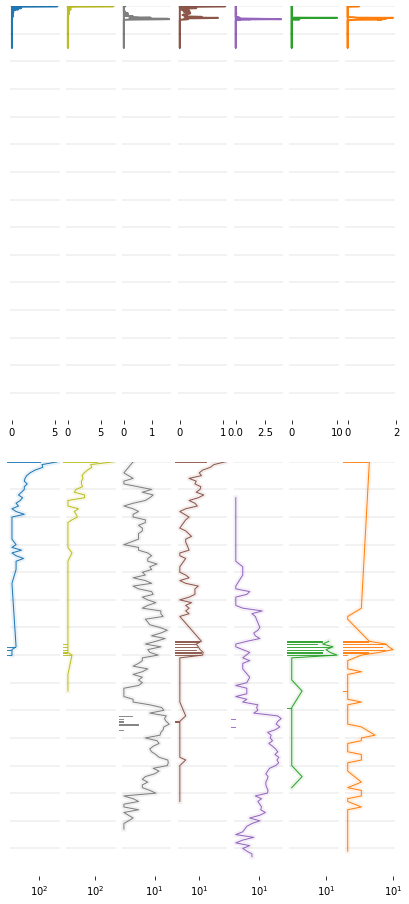

In [101]:
plt.figure(figsize=(7,16),facecolor='w')
G = gridspec.GridSpec(2,len(cleandf['common_name'].unique()),hspace=0.1,wspace=0.02)
# fig, axes = plt.subplots(nrows=1, ncols=len(fossil['common_name'].unique()), figsize=(5,10), sharex=False, sharey=True)

ylim = 150
unit = 'taxon_name'
height = 0.5

cleandf['timebin'] = pd.cut(cleandf['rand_ma'],labels = False, bins = round(cleandf['rand_ma'].max()))
endemicdb = cleandf[cleandf['cc']=='MG']

for index,phy in enumerate(cleandf['common_name'].unique()):
    temp = cleandf[cleandf['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    endtemp = endemicdb[endemicdb['common_name'] == phy] #.groupby(by='timebin')[unit].count().reset_index()
    tempkde = cleandf[cleandf['common_name'] == phy].groupby(by=['timebin',unit])['index'].count().reset_index()
    endtempkde = endemicdb[endemicdb['common_name'] == phy].groupby(by=['timebin',unit])['index'].count().reset_index()
#     print(tempkde)
    
#     print(temp.head(2))
    ax=plt.subplot(G[0,index])
    ax.set_ylim(ylim,0)
    
#     values=tempkde['timebin'].dropna().values
    values=[np.log(x+1) for x in tempkde['timebin'].dropna().values]
#     kde=gaussian_kde([np.log10(x+1) for x in values])
#     kde=gaussian_kde([x**10 for x in values])
    kde=gaussian_kde(values)
#     y_grid=np.linspace(min(values),max(values),200)
    y_grid=np.linspace(0,15,200)
    kde.covariance_factor=lambda:0.04
    kde._compute_covariance()
    ax.fill_betweenx(y_grid,x1=kde(y_grid),alpha=1,edgecolor=common_names_col[phy], facecolor = 'none', lw = 2)

#     values=endtempkde['timebin'].dropna().values
#     values=[np.log(x+1) for x in endtempkde['timebin'].dropna().values]
# #     kde=gaussian_kde([np.log10(x+1) for x in values])
#     kde=gaussian_kde(values)
# #     y_grid=np.linspace(min(values),max(values),200)
#     y_grid=np.linspace(0,ylim,500)
#     kde.covariance_factor=lambda:0.04
#     kde._compute_covariance()
#     ax.fill_betweenx(y_grid,x1=kde(y_grid),alpha=0.4,edgecolor=common_names_col[phy], facecolor = common_names_col[phy], lw = 3)

    ax.set_yticks([])
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
    ax=plt.subplot(G[1,index])
    ax.set_ylim(ylim,0)
    
    ax.plot([x for x in temp[unit]], temp['timebin'], color = common_names_col[phy], zorder = 10, lw = 5, alpha= 0.1)
    ax.plot(temp[unit], temp['timebin'], color = common_names_col[phy], zorder = 10, lw = 1)
    
#     ax.plot(endtemp[unit], endtemp['timebin'], color = common_names_col[phy], zorder = 10, lw = 5, alpha= 0.4)
#     ax.plot(endtemp[unit], endtemp['timebin'], color = common_names_col[phy], zorder = 10, lw = lw+1)
    
    for timebin in endtemp['timebin'].unique():
        endtemp1 = endtemp[endtemp['timebin'] == timebin]
        bottom = 0
        widthend = len(endtemp1)
        ax.barh(y = timebin, width = widthend, height = height, left = bottom, align = 'edge', facecolor = common_names_col[phy], edgecolor = 'w',zorder = 10, lw = 0.1, alpha = 1)

    plt.xscale('log')
    ax.set_yticks([])
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
# legend_elements=[]
# for key,value in common_names_col.items():
#     legend_elements.append(Line2D([0],[0],marker='o',color=value,label=key,markersize=10))
# ax.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.2, 0.5, 0.5, 0.5),labelspacing=1)
# plt.suptitle('Count by unique fossil records',y=0.92)
# # plt.savefig('./fossilall.svg',dpi=300)
plt.show()

In [7]:
# remove remaining marine stuff from the na above
# ['Tetrodiscus biforis','Prometalia spatagus','']

fixphyla = {'Iphitus sp.':'Mollusca', 'Titanosaurus sp.':'Chordata','Chaerephon leucogastert':'Chordata','Mormopteris jugularis':'Chordata','cf. Otomops madagascariensis':'Chordata',
           'Macronycteris commersoni':'Chordata','cf. Macronycteris sp.':'Chordata','cf. Boophinae indet.':'Chordata', 'n. gen. Cubiculum n. sp. ornatus':'Arthropoda', 'Miogypsina irregularis':np.nan}

for row in dfff[(dfff['phylum'].isna()) | (dfff['phylum'] == 'NO_PHYLUM_SPECIFIED')].itertuples():
    dfff.loc[row.Index,'phylum'] = fixphyla[row.identified_name] if row.identified_name in fixphyla.keys() else np.nan
        
dfclean = dfff[ ~dfff['phylum'].isna()].copy(deep=True) # the rest of the na are marine creatures
dfclean[['max_ma', 'min_ma', 'delta_ma', 'mean_ma', 'rand_ma']].describe()

C:\Users\xtorrm\Documents\Python3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


max_ma      min_ma    delta_ma     mean_ma     rand_ma
count  968.000000  968.000000  968.000000  968.000000  968.000000
mean    43.071022   38.787446    4.283577   40.929234   40.606553
std     43.741700   39.995681    4.800142   41.841786   41.614667
min      0.011700    0.000000    0.011700    0.005850    0.005850
25%      0.011700    0.000000    0.011700    0.005850    0.005850
50%     48.600000   37.200000    4.374000   42.900000   39.000000
75%     72.100000   66.000000    6.100000   69.050000   70.000000
max    113.000000  109.000000   34.500000  110.515000  112.000000

In [9]:
# add column with common names:
dfclean[dfclean['phylum'] == 'NO_PHYLUM_SPECIFIED']['identified_name']
# common_names = {}
dfclean['cc'].unique()

array(['MG'], dtype=object)

In [424]:
dfclean['phylum'].unique()
common_names_dict = {'Mollusca':'Molluscs', 'Chordata':'Chordates', 'Arthropoda':'Arthropods', 'Chlorophyta':'Green algae', 'Annelida':'Worms',
       'Tracheophyta':'Vascular plants'}
dfclean['common_name'] = dfclean['phylum'].map(common_names_dict)
dfclean[['phylum','common_name']]

phylum common_name
0     Mollusca    Molluscs
1     Mollusca    Molluscs
2     Mollusca    Molluscs
3     Mollusca    Molluscs
4     Mollusca    Molluscs
...        ...         ...
2128  Chordata   Chordates
2129  Chordata   Chordates
2130  Chordata   Chordates
2131  Chordata   Chordates
2133  Chordata   Chordates

[968 rows x 2 columns]

In [432]:
list(dfclean.columns)
dfclean['accepted_name'].unique()
dfclean['cc_diff'] = np.where(dfclean['cc'] == dfclean['cc.1'], dfclean['cc'], np.nan)
dfclean[['cc','cc.1','cc_diff']].isna().describe()
dfclean['cc'].unique()

array(['MG'], dtype=object)

In [ ]:
plt.figure(figsize=(7,10),facecolor='w')
G = gridspec.GridSpec(1,len(fossil['common_name'].unique()),hspace=0.0,wspace=0.02)
# fig, axes = plt.subplots(nrows=1, ncols=len(fossil['common_name'].unique()), figsize=(5,10), sharex=False, sharey=True)

ylim = 140
unit = 
common_names_dict = {'Molluscs':'#88CCEE', 'Chordates':'#CC6677', 'Arthropods':'#DDCC77', 'Green algae':'#44AA99', 'Worms':'#AA4499',
       'Vascular plants':'#882255'}

cleandf['timebin'] = pd.cut(cleandf['rand_ma'],labels = False, bins = round(cleandf['rand_ma'].max()))
endemicdb=cleandf[cleandf['cc']=='MG']

for index,phy in enumerate(cleandf['common_name'].unique()):
    temp = cleandf[cleandf['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    endtemp = endemicdb[endemicdb['common_name'] == phy].groupby(by='timebin')[unit].count().reset_index()
    
    ax=plt.subplot(G[0,index])
    ax.set_ylim(ylim,0)
    
    for phy in names:
        temp = dataset[dataset[by] == phy].groupby(by='timebin')[unit].count().reset_index()
#         print(temp.head(3))
        ax.plot(temp[unit], temp['timebin'], color = colordict[phy], zorder = 10, lw = 5, alpha= 0.2)
        ax.plot(temp[unit], temp['timebin'], color = colordict[phy], zorder = 10, lw = lw)
#             bottom += width
    plt.xscale('log')
    ax.set_yticks([])
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
    return ax

    
    for timebin in temp['timebin'].unique():
        temp1 = temp[temp['timebin'] == timebin]
        endtemp1 = endtemp[endtemp['timebin'] == timebin]
        bottom = 0
        width = len(temp1)
#         print(width)
        widthend = len(endtemp1)
        ax.barh(y = timebin, width = width, height = height, left = bottom, align = 'edge', facecolor = commnames_coldict[phy], edgecolor = 'none',zorder = 10, lw = 0.8, alpha = 0.5)
        ax.barh(y = timebin, width = widthend, height = height, left = bottom, align = 'edge', facecolor = commnames_coldict[phy], edgecolor = 'w',zorder = 10, lw = 2, alpha = 1, hatch='//')
    ax.set_yticks([])
    plt.xscale('log')
#     ax.set_xlim(0,np.log(100000000000))
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
legend_elements=[]
for key,value in commnames_coldict.items():
    legend_elements.append(Line2D([0],[0],marker='o',color=value,label=key,markersize=10))
ax.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.2, 0.5, 0.5, 0.5),labelspacing=1)
plt.suptitle('Count by unique fossil records',y=0.92)
# plt.savefig('./fossilall.svg',dpi=300)
plt.show()

----

# 0. Functions and dictionaries

----

In [2]:
def colourDict(data,cmap=mpl.cm.viridis,sort=False):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name. If sort = False, the function takes an ordered list of unique elements
    """
    cmap=cmap # default viridis
    data_unique=data if sort == False else list(set(data)) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

def hpd(data, level):
    """
    from https://github.com/blab/mers-structure/blob/master/scripts/MERS.2_posterior.ipynb
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list(data)
    d.sort()
    nData = len(data)
    nIn = int(round(level * nData))
    if nIn < 2 :
        return None
    #raise RuntimeError("Not enough data. N data: %s"%(len(data)))
    i = 0
    r = d[i+nIn-1] - d[i]
    for k in range(len(d) - (nIn - 1)) :
        rk = d[k+nIn-1] - d[k]
        if rk < r :
            r = rk
            i = k
    assert 0 <= i <= i+nIn-1 < len(d)
    return (d[i], d[i+nIn-1])

geol_col_dict={'Holocene':['#d6d6d6','Hol'], # dark grey
               'Pleistocene':['#ffffff','Ple'], # light grey
               'Pliocene':['#d6d6d6','Pli'],
               'Miocene':['#ffffff','Mio'],
               'Oligocene':['#d6d6d6','Oli'],
               'Eocene':['#ffffff','Eoc'],
               'Paleocene':['#d6d6d6','Pal'],
               'Late Cretaceous':['#ffffff','late Cret'],
              'Early Cretaceous':['#d6d6d6','early Cret']}

## geological times -- epochs. Dates from Wikipedia which I hope are based on the accepted standard 
geol_time_dict={'Holocene':(0,0.011700),
               'Pleistocene':(0.011700,2.58),
               'Pliocene':(2.58,5.333),
               'Miocene':(5.333,23.03),
               'Oligocene':(23.0,33.9),
               'Eocene':(33.9,56.0),
               'Paleocene':(56.0,66.0),
               'Late Cretaceous':(66.0,100.5),
               'Early Cretaceous':(100.5,145.0),
               'Jurassic':(145.0,201.3)}

hol_col_dict={'Meghalayan':['#ffffff','Meg'], # dark grey
               'Northgrippian':['#d6d6d6','Nor'], # light grey
               'Greenlandian':['#ffffff','Gre'],
             'Pleistocene':['#d6d6d6','Ple']}

hol_time_dict={'Meghalayan':(0,4.200),# in thousands of years ka
              'Northgrippian':(4.200,8.200),
              'Greenlandian':(8.200,11.700),
              'Pleistocene':(11.700,40)} # 40 isnt the end of the pleistocene but this is for plotting purposes

----

# 1. Prepare data

----


### 1.1. Load data

### Holocene data

Time periods	Climate  
Late Pleistocene : 36000-20000	Relatively wet and humid period  
Late Pleistocene : 20000- 15000	Drier conditions  
Late Pleistocene : 15000- early Holocene	Warm and humid period  
Mid-Holocene	Wetter conditions  
Late Holocene : 3500- to the present time	Increasing occurrence of drought  
	
	
	
	
Time periods	Vegetation  
Late Pleistocene : 20000- 15000	Mosaic landscape  
Late Pleistocene : 15000- early Holocene	Mosaic landscape  
Mid-Holocene	Mosaic landscape  
1200-950 BP towards the present time	Opening of ecosystem  
	

In [3]:
extant=pd.read_csv('./endemic_lineages_template2.tsv',sep='\t')

# Cretaceous and Cenozoic fossils occurrences worldwide 
# of genera that are recorded in from Madagascar
fossil=pd.read_csv('./Fossils-Madagascar/Genera_records_world.csv',sep=',') #  'early_age', 'late_age','genus_name','genus', 'phylum', 'cc'
fossil.columns
# any genus with no countries other than MG will be treated as endemic, the rest as fossils "from Madagascar"
# genus_name has more fields filled up, use that one instead of 'genus'
fossil[['early_age', 'late_age','genus_name','genus', 'phylum', 'cc']] # match genus here with those in endemic... colour the ones we need. plot in "stack bars" with endemic coloured. bins=1 My

# geological/environmental events 
events=pd.read_csv('./mada_paleo_events.tsv',sep='\t') # 'time_Ma_from','time_Ma_to','short','location','type',
# events[['time_Ma_from','time_Ma_to','short','location','type']]

# sorting the data
extant.dropna(subset=['mean_crown_plot'],inplace=True)
extant.sort_values(by='mean_crown_plot',ascending=False, inplace=True); extant.reset_index(inplace=True)
extant[['mean_crown_plot','mean_stem_plot']]=extant[['mean_crown_plot','mean_stem_plot']].astype('float')
extant[['mean_crown_plot','mean_stem_plot']].isna().describe()

mean_crown_plot mean_stem_plot
count              168            168
unique               1              2
top              False          False
freq               168            157

In [4]:
fossil.columns
fossil[['class', 'class_no','genus_name']].isna().describe()

class class_no genus_name
count   13126    13126      13126
unique      2        2          1
top     False    False      False
freq    11723    11723      13126

In [5]:
# remove rows with no genus_name
fossil=fossil[~fossil['genus_name'].isna()]

# writing class information using genus when missing
fossil[fossil['class'].isna()]['genus_name'].unique() # ['Classopollis', 'Retimonocolpites', 'Monosulcites', 'Liliacidites']
genus_classdict={'Classopollis':'Gymnoperms', 'Retimonocolpites':'Angiosperms', 'Monosulcites':'Angiosperms', 'Liliacidites':'Liliacidites',
'Corollina':'Gymnoperms','Brenneripollis':'Unclassified plants','Peromonolites':'Ferns'}

for row in fossil.itertuples():
#     print(row._22) # _22 is the class column... no idea why is not parsing it with name
    if pd.notnull(row._22) == False:
        fossil.loc[row.Index,'class']=genus_classdict[row.genus]
fossil[['class', 'class_no','genus_name','taxon_name']].isna().describe() # note that class has more data than class_no, which we didn't complete

class class_no genus_name taxon_name
count   13126    13126      13126      13126
unique      1        2          1          1
top     False    False      False      False
freq    13126    11723      13126      13126

In [139]:
# df.groupby(by=['phylum'])['occurrence_no'].count()
# df['phylum'].unique()

# genus_classdict={'Mollusca':'Molluscs','Chordata':'Chordates','Sphenophyta':'Pteridophyta','Coniferophyta':'Gymnosperms','Pteridophyta':'Pteridophyta','Pinophyta':'Gymnosperms',
#                 'Peltaspermophyta':'Pteridophyta','Equisetophyta':'Pteridophyta','Cycadophyta':'Gymnosperms','Ginkgophyta':'Gymnosperms','Filicophyta':'Pteridophyta','Tracheophyta':'Other tracheophytes','Pteridospermophyta':'Pteridophyta',
#                 'Bryophyta':'Bryophytes','Gymnospermophyta':'Gymnosperms', 'Chlorophyta':'Green algae', 'Charophyta', 'Arthropoda',
#        'Cnidaria', 'Echinodermata', 'Hyolitha', 'Brachiopoda',
#        'Foraminifera', 'Rhodophyta', 'Annelida', 'Porifera',
#        'Angiospermae', 'Spermatophyta'}


array(['Mollusca', 'Bryozoa', 'Chordata', 'Sphenophyta', 'Coniferophyta',
       'Pteridophyta', nan, 'Pinophyta', 'NO_PHYLUM_SPECIFIED',
       'Peltaspermophyta', 'Equisetophyta', 'Cycadophyta', 'Ginkgophyta',
       'Filicophyta', 'Tracheophyta', 'Pteridospermophyta', 'Bryophyta',
       'Gymnospermophyta', 'Chlorophyta', 'Charophyta', 'Arthropoda',
       'Cnidaria', 'Echinodermata', 'Hyolitha', 'Brachiopoda',
       'Foraminifera', 'Rhodophyta', 'Annelida', 'Porifera',
       'Angiospermae', 'Spermatophyta'], dtype=object)

In [6]:
# naming phyla with common names
fossil.columns
fossil['class'].unique()
# removing Chondrichthyes and Coelacanthimorpha because we are focused only in terrestrial (+river) organisms
fossil=fossil[~fossil['class'].isin(['Chondrichthyes','Coelacanthimorpha'])].reset_index()
fossil['class'].unique()
fossil_namedict={'Actinopteri':'Bony fishes', 
                 'Mammalia':'Mammals', 
                 'Aves':'Birds',
                 'Magnoliopsida':'Flowering plants','Angiosperms':'Flowering plants','Unclassified plants':'Unclassified plants',
                 'Reptilia':'Reptiles',
                 'Ginkgoopsida':'Gymnoperms',
                'Saurischia':'Dinosaur',
                 'Gymnoperms':'Gymnoperms','Ferns':'Ferns',
                 'Osteichthyes':'Bony fishes'}
fossil['common_name'] = fossil['class'].map(fossil_namedict)
fossil.dropna(subset = ['common_name'], axis = 0, inplace = True)
fossil[['class','common_name','genus_name']]

class  common_name     genus_name
0     Actinopteri  Bony fishes    Lepisosteus
1     Actinopteri  Bony fishes    Lepisosteus
2     Actinopteri  Bony fishes    Lepisosteus
3        Mammalia      Mammals            Mus
4        Mammalia      Mammals            Sus
...           ...          ...            ...
9719         Aves        Birds       Coturnix
9720         Aves        Birds  Phalacrocorax
9721  Actinopteri  Bony fishes      Lepidotus
9722         Aves        Birds          Ardea
9723         Aves        Birds    Casmerodius

[9481 rows x 3 columns]

In [6]:
# # remove phyla of marine lineages (or mostly-marine lineages). We are only considering land phyla
# dff=df[~df['phylum'].isin(['Bryozoa','Cnidaria','Echinodermata','Hyolitha','Brachiopoda','Foraminifera','Rhodophyta','Porifera',
#                           'Coelacanthiformes','Lamniformes','Odontaspidida','Cetacea','Myliobatiformes','Carchariniformes','Scombriformes','Selachii','Pristiophoriformes','Rajiformes'])]

# # marine mammals, marine chordata?
# # remove killer whales 'Orcinus' in Carnivora
# # remove anything with 'environment' == 'marine indet.'
# dfff = dff[ ~dff['environment'].isin(['marine indet.'])]
# # check nans and no_phylum_specified
# dfff[dfff['phylum'].isna()]['identified_name'].unique()

array(['Tetrodiscus biforis', 'Prometalia spatagus', 'Iphitus sp.',
       'Titanosaurus sp.', 'Chaerephon leucogastert',
       'Mormopteris jugularis', 'cf. Otomops madagascariensis',
       'Macronycteris commersoni', 'cf. Macronycteris sp.',
       'cf. Boophinae indet.'], dtype=object)

In [8]:
fossil.columns
fossil[['early_age', 'late_age','early_age.1', 'late_age.1','early_int_no', 'late_int_no']].describe()

early_age    late_age  early_age.1  late_age.1  early_int_no  \
count  9481.000000  7706.00000  9481.000000  7706.00000   9481.000000   
mean     39.898409    43.02459    39.898409    43.02459    300.130788   
std      49.098180    45.72164    49.098180    45.72164    357.917722   
min       0.011700     0.01170     0.011700     0.01170     14.000000   
25%       0.126000     0.12600     0.126000     0.12600     35.000000   
50%       3.600000    15.97000     3.600000    15.97000    117.000000   
75%      99.600000    93.50000    99.600000    93.50000    740.000000   
max     145.000000   140.20000   145.000000   140.20000    923.000000   

       late_int_no  
count  9481.000000  
mean    295.410927  
std     356.709812  
min      14.000000  
25%      33.000000  
50%     116.000000  
75%     740.000000  
max     923.000000

### 1.2. calculating mean ages and country lists for fossil records

In [9]:
# remove NaNs in country code 'cc'
fossilclean=fossil[(~fossil['cc'].isna())]

fosbygenera=fossilclean.groupby(by=['genus_name'])['cc'].agg(['unique']) # by species
fosbygenera.reset_index(inplace=True)

fosbyspecies=fossilclean.groupby(by=['taxon_name'])['cc'].agg(['unique']) # by species
fosbyspecies.reset_index(inplace=True)

fosbycommon=fossilclean.groupby(by=['common_name'])['cc'].agg(['unique']) # by species
fosbycommon.reset_index(inplace=True)

# make list of fossils only found in Madagascar
endemic_fossilgen = []
endemic_fossilspp = []
endemic_fossilcomm = []

for row in fosbygenera.itertuples():
#     print(row)
    if 'MG' in list(row.unique) and len(list(row.unique)) <= 1:
        endemic_fossilgen.append(row.genus_name) # per species genus_name
    
for row in fosbyspecies.itertuples():
#     print(row)
    if 'MG' in list(row.unique) and len(list(row.unique)) <= 1:
        endemic_fossilspp.append(row.taxon_name) # per genus
        
for row in fosbycommon.itertuples():
#     print(row)
    if 'MG' in list(row.unique) and len(list(row.unique)) <= 1:
        endemic_fossilcomm.append(row.common_name) # per genus
        
print('Number of fossil genera found only in Madagascar: ',len(endemic_fossilgen))
print('Number of fossil species found only in Madagascar: ',len(endemic_fossilspp))
print('Number of fossil records by common name found only in Madagascar: ',len(endemic_fossilcomm))

# total endemic records, identifying the list by unique IDs
endemic_fossilrecords=fossilclean[fossilclean['cc']=='MG']['index'].values
print('Number of fossil records found only in Madagascar: ',len(endemic_fossilrecords))

Number of fossil genera found only in Madagascar:  93
Number of fossil species found only in Madagascar:  216
Number of fossil records by common name found only in Madagascar:  0
Number of fossil records found only in Madagascar:  522


In [11]:
# estimate the mean age for every record
fossil['mean_age'] = fossil[['early_age','late_age']].mean(axis=1)
fossil[['genus_name','early_age', 'late_age','mean_age','cc']]

fossilclean['mean_age'] = fossilclean[['early_age','late_age']].mean(axis=1)
fossilclean[['genus_name','early_age', 'late_age','mean_age','cc']]
# len(fossil['index'])

C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


genus_name  early_age  late_age  mean_age  cc
0       Lepisosteus    55.8000    37.200   46.5000  UK
1       Lepisosteus    55.8000    37.200   46.5000  UK
2       Lepisosteus    55.8000    37.200   46.5000  UK
3               Mus    11.6200     7.246    9.4330  CN
4               Sus    11.6080     3.600    7.6040  TR
...             ...        ...       ...       ...  ..
9719       Coturnix     0.0117       NaN    0.0117  NZ
9720  Phalacrocorax    15.9700    13.600   14.7850  US
9721      Lepidotus    13.0000   125.450   69.2250  PT
9722          Ardea     0.7810     0.126    0.4535  US
9723    Casmerodius     0.7810     0.126    0.4535  US

[9314 rows x 5 columns]

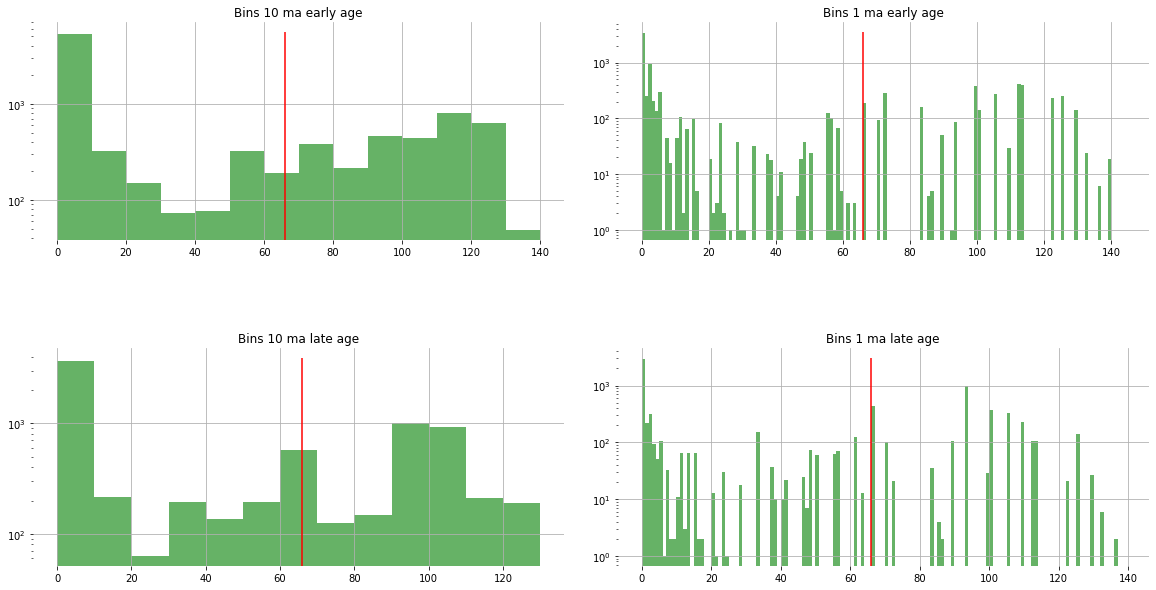

In [12]:
plt.figure(figsize=(20,10),facecolor='w')
G = gridspec.GridSpec(2,2,hspace=0.5,wspace=0.1)

ax=plt.subplot(G[0,0])
ax.hist(fossil['early_age'], bins = [x for x in range(0,round(fossil['early_age'].max()),10)],color = 'g', alpha = 0.6)
plt.title('Bins 10 ma early age')
ax.vlines(66,ymin=0,ymax=ax.get_ylim()[1],color='r')
plt.yscale('log'); [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.grid()

ax=plt.subplot(G[1,0])
ax.hist(fossil['late_age'], bins = [x for x in range(0,round(fossil['late_age'].max()),10)],color = 'g', alpha = 0.6)
plt.title('Bins 10 ma late age')
ax.vlines(66,ymin=0,ymax=ax.get_ylim()[1],color='r')
plt.yscale('log'); [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.grid()

ax=plt.subplot(G[0,1])
ax.hist(fossil['early_age'], bins = [x for x in range(0,round(fossil['early_age'].max()),1)],color = 'g', alpha = 0.6)
plt.title('Bins 1 ma early age')
ax.vlines(66,ymin=0,ymax=ax.get_ylim()[1],color='r')
plt.yscale('log'); [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.grid()

ax=plt.subplot(G[1,1])
ax.hist(fossil['late_age'], bins = [x for x in range(0,round(fossil['late_age'].max()),1)],color = 'g', alpha = 0.6)
plt.title('Bins 1 ma late age')
ax.vlines(66,ymin=0,ymax=ax.get_ylim()[1],color='r')
plt.yscale('log'); [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.grid()

plt.show()

In [13]:
fossil['early_age']
fossil['timebin'] = pd.cut(fossil['early_age'],labels = False, bins = round(fossil['early_age'].max())) # if the number of bins equals the maximum My age, the size of the bin is 1 My

endemic = fossil[fossil['cc'] == 'MG']
# endemic['cc']

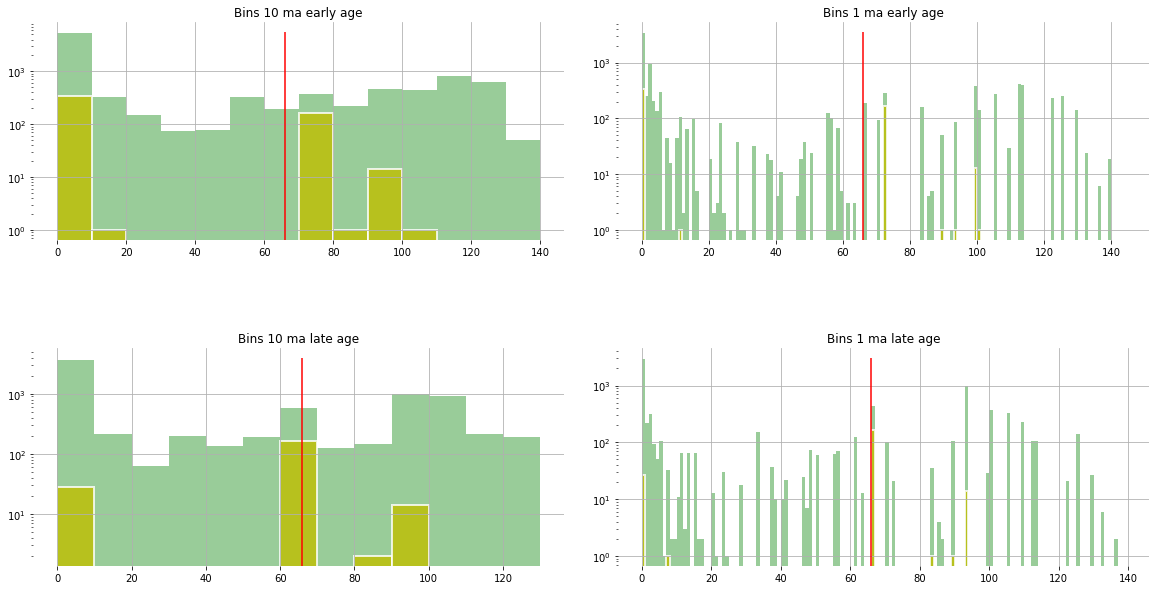

In [14]:
plt.figure(figsize=(20,10),facecolor='w')
G = gridspec.GridSpec(2,2,hspace=0.5,wspace=0.1)

ax=plt.subplot(G[0,0])
ax.hist(fossil['early_age'], bins = [x for x in range(0,round(fossil['early_age'].max()),10)],color = 'g', alpha = 0.4)
ax.hist(endemic['early_age'], bins = [x for x in range(0,round(fossil['early_age'].max()),10)],color = 'y', alpha = 0.8, edgecolor = 'w', lw = 2)
plt.title('Bins 10 ma early age')
ax.vlines(66,ymin=0,ymax=ax.get_ylim()[1],color='r')
plt.yscale('log'); [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.grid()

ax=plt.subplot(G[1,0])
ax.hist(fossil['late_age'], bins = [x for x in range(0,round(fossil['late_age'].max()),10)],color = 'g', alpha = 0.4)
ax.hist(endemic['late_age'], bins = [x for x in range(0,round(fossil['late_age'].max()),10)],color = 'y', alpha = 0.8, edgecolor = 'w', lw = 2)
plt.title('Bins 10 ma late age')
ax.vlines(66,ymin=0,ymax=ax.get_ylim()[1],color='r')
plt.yscale('log'); [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.grid()

ax=plt.subplot(G[0,1])
ax.hist(fossil['early_age'], bins = [x for x in range(0,round(fossil['early_age'].max()),1)],color = 'g', alpha = 0.4)
ax.hist(endemic['early_age'], bins = [x for x in range(0,round(fossil['early_age'].max()),1)],color = 'y', alpha = 0.8, edgecolor = 'w', lw = 2)
plt.title('Bins 1 ma early age')
ax.vlines(66,ymin=0,ymax=ax.get_ylim()[1],color='r')
plt.yscale('log'); [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.grid()

ax=plt.subplot(G[1,1])
ax.hist(fossil['late_age'], bins = [x for x in range(0,round(fossil['late_age'].max()),1)],color = 'g', alpha = 0.4)
ax.hist(endemic['late_age'], bins = [x for x in range(0,round(fossil['late_age'].max()),1)],color = 'y', alpha = 0.8, edgecolor = 'w', lw = 2,histtype ='barstacked')
plt.title('Bins 1 ma late age')
ax.vlines(66,ymin=0,ymax=ax.get_ylim()[1],color='r')
plt.yscale('log'); [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.grid()

plt.show()

In [180]:
def enhance_ma(df):
    df['delta_ma'] = df['early_age'] - df['late_age']
    df['mean_ma'] = df['late_age'] + 0.5*df['delta_ma']
    df['rand_ma'] = df.apply(lambda row: row['mean_ma'] if row['delta_ma'] < 1 else np.random.randint(row['late_age'], row['early_age']), axis=1)

fossil[['early_age','late_age']].replace(np.nan,0,inplace=True)
fossil[['early_age','late_age']].isna().describe()
# df[['max_ma','min_ma']]

enhance_ma(fossil)
df[['max_ma', 'min_ma', 'delta_ma', 'mean_ma', 'rand_ma']]

C:\Users\xtorrm\Documents\Python3\lib\site-packages\pandas\core\frame.py:4263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


max_ma  min_ma  delta_ma  mean_ma  rand_ma
0       72.1   66.00      6.10   69.050     67.0
1       72.1   66.00      6.10   69.050     69.0
2       72.1   66.00      6.10   69.050     71.0
3       72.1   66.00      6.10   69.050     70.0
4       72.1   66.00      6.10   69.050     68.0
...      ...     ...       ...      ...      ...
3975   259.9  254.17      5.73  257.035    255.0
3976   259.9  254.17      5.73  257.035    256.0
3977   259.9  254.17      5.73  257.035    256.0
3978   259.9  254.17      5.73  257.035    257.0
3979   259.9  254.17      5.73  257.035    258.0

[3980 rows x 5 columns]

In [26]:
# create list of common_names so that all plots are in the same order
allcommon_names = sorted(set(list(extant['common_name'].unique())+list(fossil['common_name'].unique())))
extant_names = sorted(list(extant['common_name'].unique()))
fossil_names = sorted(list(fossil['common_name'].unique()))
# print(allcommon_names)

# counting total lineages for each common_names and adding them across datasets
# these counts will be used as "bottoms" and "left edges" for plotting
extant_span = {}
for name in extant_names:
    count = len(extant[extant['common_name'] == name])
    # take the largest number to set the xaxis span (ple will be plot on top of holo and we want the groups to correspond)
    extant_span[name] = count

fosdata = fossil.copy(deep=True)
# creates a dictionary of fossil record ID and time bin. Similar to the above but without breaking the fossil records into classes
fosdata['timebin'] = pd.cut(fosdata['rand_ma'],labels = False, bins = round(fosdata['rand_ma'].max()))
# fossilclean['timebin']
    
genfossil_span = {}
sppfossil_span = {}
recfossil_span = {}

# iterates through classes and creates a dictionary of dictionaries (classname: {taxonname : timebin})
for name in fossil_names:    
    cummulativeholfossilgen = 0; cummulativeholfossilspp = 0; cummulativeholfossilrec = 0
    time_col = 'rand_ma' # we need to account for the different binning between the epoc datasets
    temp = fosdata[fosdata['common_name'] == name].copy(deep = True)
    if len(temp[time_col]) > 0:
#         temp['timebin'] = pd.cut(temp[time_col],labels = False, bins = round(fosdata[time_col].max()))
        tempgen = temp.groupby(by = ['timebin'])['genus_name'].nunique().reset_index()
        tempspp = temp.groupby(by = ['timebin'])['taxon_name'].nunique().reset_index()
        temprec = temp.groupby(by = ['timebin'])['index'].nunique().reset_index()

        cummulativeholfossilgen = tempgen['genus_name'].max()
        cummulativeholfossilspp = tempspp['taxon_name'].max()
        cummulativeholfossilrec = temprec['index'].max()

    genfossil_span[name] = cummulativeholfossilgen
    sppfossil_span[name] = cummulativeholfossilspp
    recfossil_span[name] = cummulativeholfossilrec
    
# this is the span on the x axis that we need to account for common names missing from the datasets and how large the datasets can be
# I might need to adjust the span comming from fossil data if I normalize that...
print(extant_span)
print(genfossil_span)
print(sppfossil_span)
print(recfossil_span)

KeyError: 'common_name'

In [185]:
# dictionary of the endemic lineages and their time bins
endemic_fosplotdictgen = {}
endemic_fosplotdictspp = {}
endemic_fosplotdictrec = {}

fosdata = fossil.copy(deep=True)

for phy in fosdata['common_name'].unique():
    endemicgen_time = {}
    endemicspp_time = {}
    endemicrec_time = {}
    temp = fosdata[fosdata['common_name'] == phy].copy(deep = True)
    if len(temp) > 0:
#         temp['timebin'] = pd.cut(temp['early_age'],labels = False, bins = bins)
        for taxa in endemic_fossilgen:
            if taxa in list(temp['genus_name'].unique()): # per species
                print(temp[temp['genus_name'] == taxa][['genus_name','timebin']]) # remember, here we want the unique genera-timebin combos
#                 endemicgen_time[taxa] = int(temp[temp['genus_name'] == taxa]['timebin'].unique())
#         for taxa in endemic_fossilspp:
#             if taxa in list(temp['taxon_name'].unique()): # per species # remember, here we want the unique taxonname-timebin combos
#                 endemicspp_time[taxa] = int(temp[temp['taxon_name'] == taxa]['timebin'].unique())
#         for taxa in endemic_fossilcomm:
#             if taxa in list(temp['index'].unique()): # per species # remember, here we want the unique taxonname-timebin combos
#                 endemicrec_time[taxa] = int(temp[temp['index'] == taxa]['timebin'].unique())
                
#     endemic_fosplotdictgen[phy]=endemicgen_time
#     endemic_fosplotdictspp[phy]=endemicspp_time
#     endemic_fosplotdictrec[phy]=endemicrec_time
    
# endemic_fosplotdictgen = {key: value for key, value in endemic_fosplotdictgen.items() if value}
# endemic_fosplotdictspp = {key: value for key, value in endemic_fosplotdictspp.items() if value}
# endemic_fosplotdictrec = {key: value for key, value in endemic_fosplotdictrec.items() if value}

# print('genera')
# for key,value in endemic_fosplotdictgen.items():
#     print(key)
#     print(len(value.values()))

# print('\nspecies')
# for key,value in endemic_fosplotdictspp.items():
#     print(key)
#     print(len(value.values()))

# print('\nrecords')
# for key,value in endemic_fosplotdictrec.items():
#     print(key)
#     print(len(value.values()))

      genus_name  timebin
2200  Beelzebufo       66
2864  Beelzebufo       65
3441  Beelzebufo       68
6065  Beelzebufo       68
6066  Beelzebufo       65
6067  Beelzebufo       68
6068  Beelzebufo       67
6069  Beelzebufo       66
6070  Beelzebufo       69
6071  Beelzebufo       66
6072  Beelzebufo       70
6073  Beelzebufo       66
6074  Beelzebufo       69
6075  Beelzebufo       68
6076  Beelzebufo       69
6077  Beelzebufo       67
6078  Beelzebufo       66
6079  Beelzebufo       65
6080  Beelzebufo       70
6081  Beelzebufo       67
6082  Beelzebufo       66
6083  Beelzebufo       68
6084  Beelzebufo       66
6085  Beelzebufo       65
6086  Beelzebufo       65
6087  Beelzebufo       67
6088  Beelzebufo       66
      genus_name  timebin
3129  Laliostoma        0
      genus_name  timebin
3130  Ptychadena        0
         genus_name  timebin
3131  Scaphiophryne        0
        genus_name  timebin
9407  Adalatherium       65
        genus_name  timebin
3032  Archaeolemur        

     genus_name  timebin
3489    Sokatra       65
3490    Sokatra       65
3491    Sokatra       68
3492    Sokatra       69
          genus_name  timebin
3402  Trematochampsa       68
     genus_name  timebin
9084       Voay        0
9094       Voay        0
      genus_name  timebin
3125  Zonosaurus        0
      genus_name  timebin
4985  Dahalokely       90
         genus_name  timebin
1297  Majungasaurus       69
2648  Majungasaurus       68
2741  Majungasaurus       69
2742  Majungasaurus       68
2743  Majungasaurus       68
2926  Majungasaurus       65
2927  Majungasaurus       70
2928  Majungasaurus       66
2929  Majungasaurus       65
2930  Majungasaurus       65
2931  Majungasaurus       69
2932  Majungasaurus       67
2933  Majungasaurus       69
2934  Majungasaurus       69
2937  Majungasaurus       65
3342  Majungasaurus       65
3640  Majungasaurus       70
5367  Majungasaurus       69
         genus_name  timebin
2199  Majungatholus       68
2201  Majungatholus       6

In [18]:
def fossilplot(dataset,ax,color='#bababa',unit='', by='common_name',byorder='',bins='',time='early_age',bottom=0,offset=2,span='',tickrange=20, normalise=False,height=1,endemic=False, fossildict = ''): # unit='genus_name', bins=round(dataset[time].max()),
    """
    plots a histogram of fossil genera by common name and at a time bin
    dataset=dataframe object
    by=column name (str) by which separate the lineage groups
    byorder=ordered list of names if random order is not desired
    unit=column name (str) that represent lineage units (plotted as a vertical bar)
    time=column name (str) with the mean fossil ages
    span=dictionary name:distance with the span on the x axis between each 'by' group
    """
    
    plt.gca().invert_yaxis()
    names=[]
    if byorder!= '':
        names=byorder
    else:
        names=dataset[by].unique()
    bins = bins
    dictionary = fossildict
    for phy in names:
        temp = dataset[dataset[by] == phy].copy(deep = True)
        if len(temp) > 0:
            temp['timebin'] = pd.cut(temp[time],labels = False, bins = bins)
            temp1 = temp.groupby(by = ['timebin'])[unit].nunique().reset_index()
#             print(phy,temp1.head(10))
            width = temp1[unit]
            if normalise == True:
                x = temp1[unit].astype('float64').values #returns a numpy array
                min_max_scaler = preprocessing.MinMaxScaler()
                unit_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))
                temp_norm = pd.DataFrame(unit_scaled)
                width = temp_norm[0]
            ax.barh(y = temp1['timebin'], width = width, height = height, left = bottom, align = 'edge', color = color, edgecolor = '#a1a1a1',zorder = 100, lw = 0.8)
#             ax.hist(temp['timebin'], bins = bins, orientation = 'horizontal', bottom = bottom, color = color)
        if endemic == True and phy in dictionary.keys():
            widthen = 1
            coloren = orcoldict['Madagascar']
            if normalise == True:
                widthen = temp_norm[0] / len(temp1[unit])
            for genus in temp[unit].unique():
                if genus in dictionary[phy].keys():
                    ax.barh(y = dictionary[phy][genus], width = widthen, height = height, left = bottom, align = 'edge', edgecolor = coloren, color = coloren, zorder = 110, lw = 1)
        bottom +=  offset + (span[phy]  if span != '' else 0)
        
    # set xlims using the last xbase value set
    ax.set_xlim(-0.5,bottom)
    # Adding the time lines for every 10 Mya
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    ax.set_yticks(ticks = [mya for mya in range(0,int(ax.get_ylim()[0]),tickrange)])
    ax.set_xticks([]); ax.set_yticks([])

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    return ax

In [19]:
# events plotting... first shades
shades = list(zip(events[events['layout'] == 'shade']['time_Ma_to'], events[events['layout'] == 'shade']['time_Ma_from_plot']))
# shades
# events.loc[40,'time_Ma_to']=float(9.6) # it is originally nan but we need it to be at least a unit big to plot it visibly
# events
events.sort_values(by = 'time_Ma_to', inplace = True)
volcanism = list(zip(events[events['layout'] == 'bara']['time_Ma_to'], events[events['layout'] == 'bara']['time_Ma_from_plot']))
# volcanism
landscape = list(zip(events[events['layout'] == 'barb']['time_Ma_to'], events[events['layout'] == 'barb']['time_Ma_from_plot']))
# landscape
pointevents=events[events['layout'].isin(['line','point'])]['time_Ma_from_plot'].values

landbridges=list(zip(events[events['priority.1']=='landbridge']['time_Ma_from_plot'],events[events['priority.1']=='landbridge']['time_Ma_to']))

warmer=list(zip(events[events['priority.1']=='warmer']['time_Ma_from_plot'],events[events['priority.1']=='landbridge']['time_Ma_to']))
colder=list(zip(events[events['priority.1']=='colder']['time_Ma_from_plot'],events[events['priority.1']=='landbridge']['time_Ma_to']))
# pointevents

In [21]:
extant['sister_lineage_plot'].unique()

array(['Oceania', 'Multiple', 'Africa', 'Unknown', 'Asia', 'America',
       'Eurasia', 'Madagascar'], dtype=object)

In [22]:
def addvolcanos(data, ax = '', holocene = False, offset = 0.5, color = '#a30000', levels = 3):
    """
    adds shades to denote long events
    data is a list of tuples, with data[0] == earliest (to the past) and data[1] == most recent dates
    """
    x = 0
    track = 0
    xlist = []
    while track <= len(volcanism):
        for i in range(levels):
            xlist.append(i); track += 1
    for index,pair in enumerate(data):
        if holocene == False:
            if pair[1] > 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                ymin = pair[0]
                ymax = pair[1]
        elif holocene == True:
            if pair[1] <= 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                ymin = pair[0]
                ymax = pair[1]
        else:
            ymin = pair[0]
            ymax = pair[1]
        ax.bar(x = xlist[index] * offset, height = ymax - ymin, width = offset, bottom = ymin, align = 'center', edgecolor = '#bababa', lw = 1, alpha = 1,
               color = color, zorder = 100)       
    return ax

def addshade(data, x = 0, holocene = False, lines = False, offset = 1, lw = 1, ax = '', darkcol = '#a8a8a8', lightcol = '#d9d9d9'):
    """
    adds shades to denote long events
    data is a list of tuples, with data[0] == earliest (to the past) and data[1] == most recent dates
    """
    x = x
    for index,pair in enumerate(data):
        if holocene == False:
            if pair[1] > 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                ymin = pair[0]
                ymax = pair[1]
        elif holocene == True:
            if pair[1] <= 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                ymin = pair[0]
                ymax = pair[1]
        else:
                ymin = pair[0]
                ymax = pair[1]
        ax.axhspan(ymin = ymin, ymax = ymax, alpha=0.2, facecolor= darkcol if (index % 2) == 0 else lightcol, edgecolor = 'none',zorder = 10)
        if lines == True:
            ax.vlines(x = x, ymin = ymin, ymax = ymax, lw = lw, color = 'k')
        x += offset
    return ax

def lineevents(data, holocene = False, lw = 1, ax = '', color = 'k', ls = '-'):
    """
    adds lines for point events
    data is a list of tuples, with data[0] == earliest (to the past) and data[1] == most recent dates
    """
    xmin = ax.get_xlim()[0]
    xmax = ax.get_xlim()[1]
    for index,date in enumerate(data):
        if holocene == False:
            if date > 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                y = date
        elif holocene == True:
            if date <= 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                y = date
        else:
                y = date
        ax.hlines(y = date, xmin = xmin, xmax = xmax, lw = lw, color = color, ls = ls)
    return ax

def lineageplot(dataset,ax,colby='sister_lineage_plot',colbydict=orcoldict,by='common_name',byorder='',unit='name', crown='mean_crown_plot',stem='mean_stem_plot',
          width=1,bottom=0,xbase=0,offset=2,span='',tickrange=20,lw=1, zorder = 100, hlines = 10, edgecolor = 'none'):
    """
    plots lineage ages from left (earliest crown age) to right (crown ages closest to present)
    dataset=dataframe object
    colby=column name (str) by which the colour is applied
    colbydict=dictionary for colby with values == colors
    by=column name (str) by which separate the lineage groups
    byorder=ordered list of names if random order is not desired
    unit=column name (str) that represent lineage units (plotted as a vertical bar)
    crown=column name (str) with the crown ages
    stem=column name (str) with the stem ages
    span=dictionary name:distance with the span on the x axis between each 'by' group
    """
    plt.gca().invert_yaxis()
    names=[]
    if byorder!= '':
        names=byorder
    else:
        names=dataset[by].unique()
    for phy in names:
        temp = dataset[dataset[by] == phy].drop_duplicates(subset=[by,unit])  # the original list has duplicated entries when two papers had different 95% age ranges. We are using the 
        x = [i + xbase for i,x in enumerate(temp[unit].unique())]
        height = temp[crown].values
        ax.bar(x = x, height = height, width = width, bottom = bottom, align = 'center', edgecolor = edgecolor, lw = lw, alpha = 1, # [edgecolordict[x] for x in temp[colby]]
               color = [colbydict[x] for x in temp[colby]], zorder = zorder)
        # plotting stem ages when available
        ax.vlines(x = [(i + xbase) for i,x in enumerate(temp[unit].unique())], ymin = temp[crown], ymax = temp[stem], color='k', lw = 0.3, zorder = 1)
        # adds an extra space to separate lineages from each 'common name'
        xbase +=  offset + (span[phy]  if span != '' else len(temp[stem].values)) # len(temp[crown].values) # (len(temp[crown].values) + len(temp[stem].values))/2

    # set xlims using the last xbase value set
    ax.set_xlim(-5,xbase)
    # Adding the time lines for every 10 Mya
#     ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),hlines)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, 
#               color = 'k', zorder = 1)
#     ax.set_yticks(ticks = [mya for mya in range(0,int(ax.get_ylim()[0]),tickrange)]); plt.yticks(color = '#424242', fontsize = 18)
    ax.set_xticks([])

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    return ax

In [28]:
# lineage origin color dictionary
origins = ['Multiple', 'America', 'Oceania', 'Africa', 'Asia', 'Eurasia', 'Madagascar','Unknown']
# orclist=[(0.0,'#d4b9da'),(1.0,'#67001f')] # purples
orclist=[(0.0,'#ffeda0'),(1.0,'#e31a1c')] # reds
orcmap=mpl.colors.LinearSegmentedColormap.from_list('orcmap',orclist)
orcoldict = colourDict(['Multiple', 'America', 'Oceania', 'Africa', 'Asia', 'Eurasia', 'Madagascar'], cmap = orcmap, sort=False)
orlistcoldict = colourDict(['Multiple', 'SAmerica','NAmerica', 'Oceania', 'Africa', 'Asia', 'Eurasia', 'Madagascar'], cmap = orcmap, sort=False)

orcoldict['Unknown'] = '#ffffff'
orlistcoldict['Unknown'] = '#ffffff'
# altorcoldict = dict(zip(origins,['k']*len(origins)))
edgecolordict = dict(zip(origins,['w' if loc != 'Unknown' else '#bababa' for loc in origins]))
# edgecolordict

In [95]:
def lineageplot(dataset,ax,colby='sister_lineage_plot',colbydict=orcoldict,by='common_name',byorder='',unit='name', crown='mean_crown_plot',stem='mean_stem_plot',
          width=1,bottom=0,xbase=0,offset=2,span='',tickrange=20,lw=1, zorder = 100, hlines = 10, edgecolor = 'none'):
    """
    plots lineage ages from left (earliest crown age) to right (crown ages closest to present)
    dataset=dataframe object
    colby=column name (str) by which the colour is applied
    colbydict=dictionary for colby with values == colors
    by=column name (str) by which separate the lineage groups
    byorder=ordered list of names if random order is not desired
    unit=column name (str) that represent lineage units (plotted as a vertical bar)
    crown=column name (str) with the crown ages
    stem=column name (str) with the stem ages
    span=dictionary name:distance with the span on the x axis between each 'by' group
    """
    plt.gca().invert_yaxis()
    names=[]
    if byorder!= '':
        names=byorder
    else:
        names=dataset[by].unique()
    for phy in names:
        temp = dataset[dataset[by] == phy].drop_duplicates(subset=[by,unit])  # the original list has duplicated entries when two papers had different 95% age ranges. We are using the 
        x = [i + xbase for i,x in enumerate(temp[unit].unique())]
        height = temp[crown].values
        ax.bar(x = x, height = height, width = width, bottom = bottom, align = 'center', edgecolor = edgecolor, lw = lw, alpha = 1, # [edgecolordict[x] for x in temp[colby]]
               color = [colbydict[x] for x in temp[colby]], zorder = zorder)
        # plotting stem ages when available
        ax.vlines(x = [(i + xbase) for i,x in enumerate(temp[unit].unique())], ymin = temp[crown], ymax = temp[stem], color='k', lw = 0.3, zorder = 1)
        # adds an extra space to separate lineages from each 'common name'
        xbase +=  offset + (span[phy]  if span != '' else len(temp[stem].values)) # len(temp[crown].values) # (len(temp[crown].values) + len(temp[stem].values))/2

    # set xlims using the last xbase value set
    ax.set_xlim(-5,xbase)
    # Adding the time lines for every 10 Mya
#     ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),hlines)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, 
#               color = 'k', zorder = 1)
#     ax.set_yticks(ticks = [mya for mya in range(0,int(ax.get_ylim()[0]),tickrange)]); plt.yticks(color = '#424242', fontsize = 18)
    ax.set_xticks([])

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    return ax

In [30]:
set(sum([x for x in extant['sister_lineage_list'].str.split('_')],[]))

{'Africa',
 'Asia',
 'Eurasia',
 'Madagascar',
 'NAmerica',
 'Oceania',
 'SAmerica',
 'Unknown'}

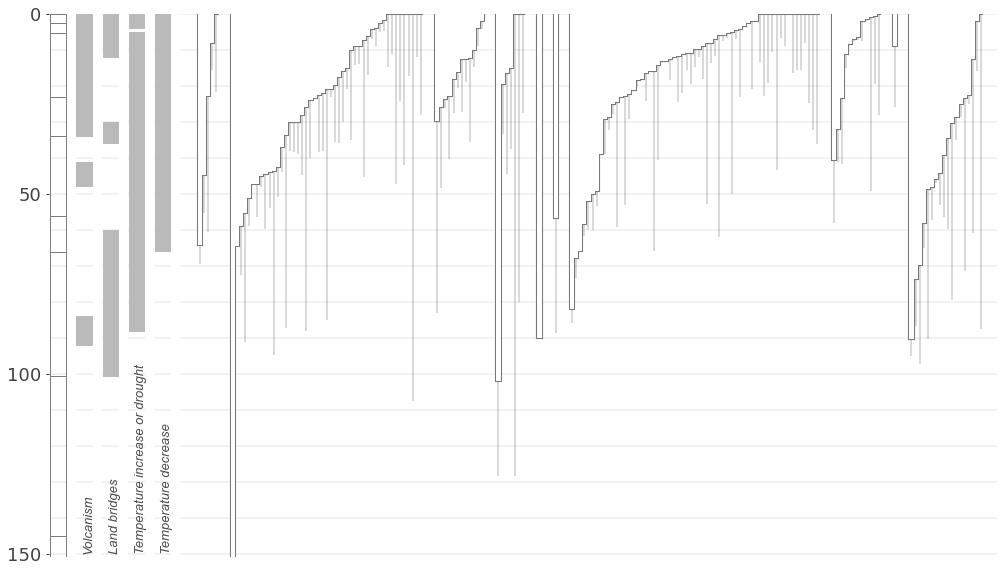

In [113]:
plt.figure(figsize=(17,10),facecolor='none')
G = gridspec.GridSpec(1,6,hspace=0.0,wspace=0.05, width_ratios =[0.05,0.05,0.05,0.05,0.05,2.2])
text_color='#4a4a4a'
fontname='Arial'
textsize=13
# ------------------------------------------------------------------------- epochs
ax1=plt.subplot(G[0,0])
ax1.set_ylim(round(extant['mean_crown_plot'].max()),0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax1.bar(x = 0, height = value[1] - value[0], width = 2, bottom = epochbase, align = 'edge', edgecolor = '#7d7d7d', lw = 1, alpha = 1,color = 'none', zorder = 100)
    epochbase += value[1] - value[0]
ax1.set_yticks(ticks = [mya for mya in range(0,int(ax1.get_ylim()[0]),50)]); plt.yticks(color = '#424242', fontsize = 18)
# ------------------------------------------------------------------------- volcanos
ax2=plt.subplot(G[0,1])
ax2.set_ylim(round(extant['mean_crown_plot'].max()),0)
addvolcanos(volcanism, holocene = '', offset = 0.02, color = '#bababa', ax = ax2, levels = 1)
ax2.text(x=(ax2.get_xlim()[1]/2),y=ax2.get_ylim()[0]-1,s='Volcanism',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')
# ------------------------------------------------------------------------- landbridges
ax3=plt.subplot(G[0,2])
ax3.set_ylim(round(extant['mean_crown_plot'].max()),0)
addvolcanos(landbridges, holocene = '', offset = 0.02, color = '#bababa', ax = ax3, levels = 1)
ax3.text(x=(ax3.get_xlim()[1]/2),y=ax3.get_ylim()[0]-1,s='Land bridges',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')
# ------------------------------------------------------------------------- weather warmer
ax4=plt.subplot(G[0,3])
ax4.set_ylim(round(extant['mean_crown_plot'].max()),0)
addvolcanos(warmer, holocene = '', offset = 0.02, color = '#bababa', ax = ax4, levels = 1)
ax4.text(x=(ax4.get_xlim()[1]/2),y=ax4.get_ylim()[0]-1,s='Temperature increase or drought',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')
# ------------------------------------------------------------------------- weather colder
ax5=plt.subplot(G[0,4])
ax5.set_ylim(round(extant['mean_crown_plot'].max()),0)
addvolcanos(colder, holocene = '', offset = 0.02, color = '#bababa', ax = ax5, levels = 1)
ax5.text(x=(ax5.get_xlim()[1]/2),y=ax5.get_ylim()[0]-1,s='Temperature decrease',color=text_color,fontstyle='italic',rotation=90,fontsize=textsize,fontname=fontname,va='bottom',ha='center')
# ------------------------------------------------------------------------- extant
whitedict = {key:'#ffffff' for key in orcoldict.keys()}
greydict = {key:'#787878' for key in orcoldict.keys()}
ax6=plt.subplot(G[0,5])
ax6.set_ylim(round(extant['mean_crown_plot'].max()),0);plt.gca().invert_yaxis()
lineageplot(extant, ax = ax6, colby = 'sister_lineage_plot', colbydict = greydict, by = 'common_name', byorder = sorted(extant_span.keys()), unit = 'name', crown = 'mean_crown_plot', stem = 'mean_crown_plot',
          width = 1.05, bottom = 0, xbase = 0, offset = 3,span = '', tickrange = 50, lw = 2.1, edgecolor = '#787878');plt.gca().invert_yaxis() # extant_span
lineageplot(extant, ax = ax6, colby = 'sister_lineage_plot', colbydict = whitedict, by = 'common_name', byorder = sorted(extant_span.keys()), unit = 'name', crown = 'mean_crown_plot', stem = 'mean_stem_plot',
          width = 1.05, bottom = 0, xbase = 0, offset = 3,span = '', tickrange = 50, lw = 0.3) # extant_span



for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_xticks([])
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    if ax != ax1:
        ax.set_yticks([])
plt.savefig('./template1.svg',dpi=300)
plt.show()

In [144]:
fossilorder=list(fossil.groupby(by = 'common_name')['index'].count().reset_index().sort_values('index',ascending=False)['common_name'].values)
fossilorder

['Mammals',
 'Birds',
 'Gymnoperms',
 'Flowering plants',
 'Bony fishes',
 'Reptiles',
 'Dinosaur']

C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


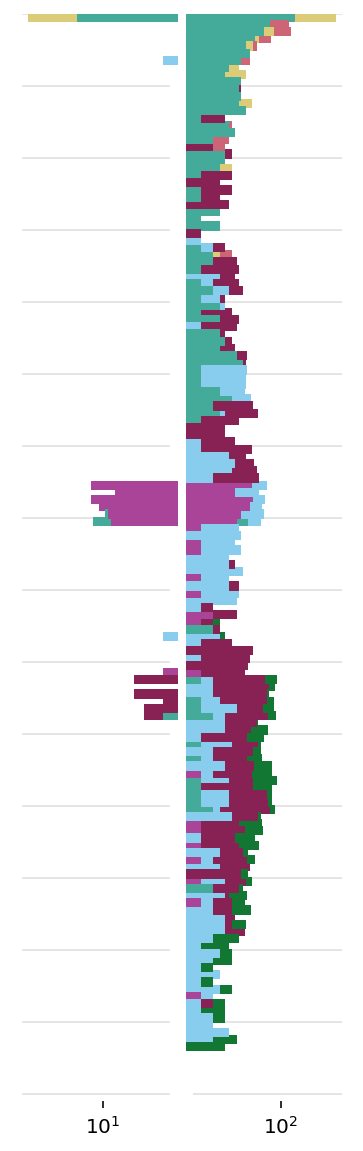

In [196]:
def fossilstacked(dataset,ax,colordict='',unit='', by='common_name',byorder='',time='rand_ma',height=1,alpha = 0.9): # unit='genus_name', bins=round(dataset[time].max()),   
    names=[]
    if byorder!= '':
        names=byorder
    else:
        names=dataset[by].unique()
    dataset['timebin'] = pd.cut(dataset[time],labels = False, bins = round(dataset[time].max()))
    endemicdb=dataset[dataset['cc']=='MG']
#     bottomend = [0]*len(dataset['timebin'].unique())

    for timebin in dataset['timebin'].unique():
        temp = dataset[dataset['timebin'] == timebin]
        bottom = 0
        for phy in names:
            width = len(temp[temp[by] == phy])
            ax.barh(y = timebin, width = width, height = height, left = bottom, align = 'edge', facecolor = colordict[phy], edgecolor = colordict[phy], zorder = 10, lw = 1, alpha = alpha)
#             bottom += width
    plt.xscale('log')
    ax.set_yticks([])
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
    return ax


plt.figure(figsize=(3,10),facecolor='none')
G = gridspec.GridSpec(1,2,hspace=0.0,wspace=0.05)
commnames_coldict={'Bony fishes':'#88CCEE','Mammals':'#CC6677','Birds':'#DDCC77','Flowering plants':'#882255','Reptiles':'#44AA99', 'Gymnoperms':'#117733','Dinosaur':'#AA4499'}

ax7=plt.subplot(G[0,0])
ax7.set_ylim(round(extant['mean_crown_plot'].max()),0)
fossilstacked(fossil[fossil['cc']=='MG'],ax=ax7,colordict=commnames_coldict,unit='index', by='common_name',byorder=fossilorder,time='rand_ma',height=1, alpha=1)
ax7.hlines(y = [mya for mya in range(0,int(ax7.get_ylim()[0]),10)], xmin = ax7.get_xlim()[0], xmax = ax7.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
plt.gca().invert_xaxis()

ax7=plt.subplot(G[0,1])
ax7.set_ylim(round(extant['mean_crown_plot'].max()),0)
fossilstacked(fossil,ax=ax7,colordict=commnames_coldict,unit='index', by='common_name',byorder=fossilorder,time='rand_ma',height=1, alpha=1)
ax7.hlines(y = [mya for mya in range(0,int(ax7.get_ylim()[0]),10)], xmin = ax7.get_xlim()[0], xmax = ax7.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
# plt.savefig('./fossilall.svg',dpi=300)
plt.show()

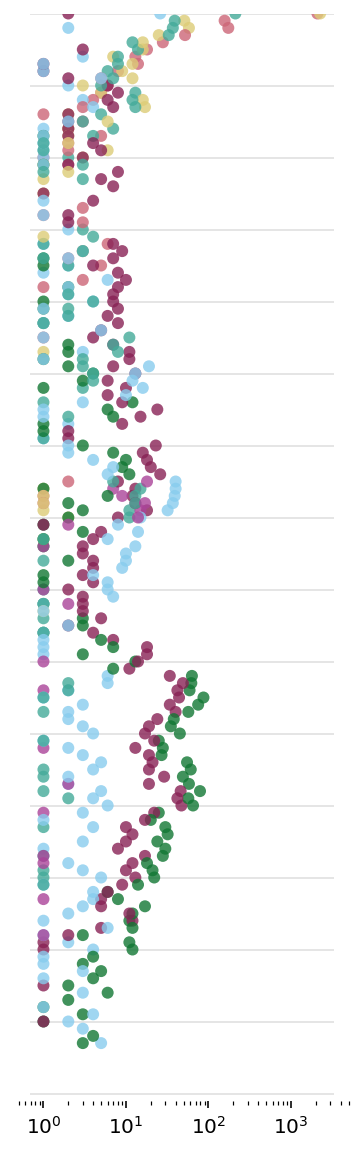

In [166]:
def fossilscater(dataset,ax,colordict='',unit='', by='common_name',byorder='',time='rand_ma',height=1,alpha = 0.9, s = 30): # unit='genus_name', bins=round(dataset[time].max()),   
    names=[]
    if byorder!= '':
        names=byorder
    else:
        names=dataset[by].unique()
    dataset['timebin'] = pd.cut(dataset[time],labels = False, bins = round(dataset[time].max()))
    endemicdb=dataset[dataset['cc']=='MG']
#     bottomend = [0]*len(dataset['timebin'].unique())

    for timebin in dataset['timebin'].unique():
        temp = dataset[dataset['timebin'] == timebin]
        bottom = 0
        for phy in names:
            width = len(temp[temp[by] == phy])
            ax.scatter(width, timebin, facecolor = colordict[phy], edgecolor = 'none',zorder = 10, alpha = alpha)
#             bottom += width
    plt.xscale('log')
    ax.set_yticks([])
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
    return ax


plt.figure(figsize=(3,10),facecolor='none')
G = gridspec.GridSpec(1,1,hspace=0.0,wspace=0.05)

ax7=plt.subplot(G[0,0])
ax7.set_ylim(round(extant['mean_crown_plot'].max()),0)
commnames_coldict={'Bony fishes':'#88CCEE','Mammals':'#CC6677','Birds':'#DDCC77','Flowering plants':'#882255','Reptiles':'#44AA99', 'Gymnoperms':'#117733','Dinosaur':'#AA4499'}
fossilscater(fossil,ax=ax7,colordict=commnames_coldict,unit='index', by='common_name',byorder=fossilorder,time='rand_ma',alpha=0.8, s=30)
ax7.hlines(y = [mya for mya in range(0,int(ax7.get_ylim()[0]),10)], xmin = ax7.get_xlim()[0], xmax = ax7.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
# plt.savefig('./fossilall.svg',dpi=300)
plt.show()

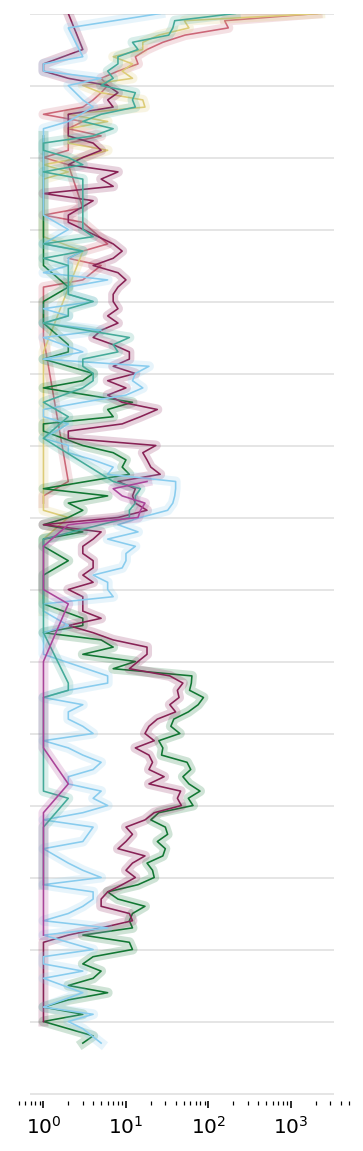

In [174]:
def fossilplotline(dataset,ax,colordict='',unit='', by='common_name',byorder='',time='rand_ma',height=1,alpha = 0.9, lw = 1): # unit='genus_name', bins=round(dataset[time].max()),   
    names=[]
    if byorder!= '':
        names=byorder
    else:
        names=dataset[by].unique()
    dataset['timebin'] = pd.cut(dataset[time],labels = False, bins = round(dataset[time].max()))
    endemicdb=dataset[dataset['cc']=='MG']
#     bottomend = [0]*len(dataset['timebin'].unique())

    for phy in names:
        temp = dataset[dataset[by] == phy].groupby(by='timebin')[unit].count().reset_index()
#         print(temp.head(3))
        ax.plot(temp[unit], temp['timebin'], color = colordict[phy], zorder = 10, lw = 5, alpha= 0.2)
        ax.plot(temp[unit], temp['timebin'], color = colordict[phy], zorder = 10, lw = lw)
#             bottom += width
    plt.xscale('log')
    ax.set_yticks([])
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
    return ax


plt.figure(figsize=(3,10),facecolor='none')
G = gridspec.GridSpec(1,1,hspace=0.0,wspace=0.05)

ax7=plt.subplot(G[0,0])
ax7.set_ylim(round(extant['mean_crown_plot'].max()),0)
commnames_coldict={'Bony fishes':'#88CCEE','Mammals':'#CC6677','Birds':'#DDCC77','Flowering plants':'#882255','Reptiles':'#44AA99', 'Gymnoperms':'#117733','Dinosaur':'#AA4499'}
fossilplotline(fossil,ax=ax7,colordict=commnames_coldict,unit='index', by='common_name',byorder=fossilorder,time='rand_ma',lw=0.8)
ax7.hlines(y = [mya for mya in range(0,int(ax7.get_ylim()[0]),10)], xmin = ax7.get_xlim()[0], xmax = ax7.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
# plt.savefig('./fossilall.svg',dpi=300)
plt.show()

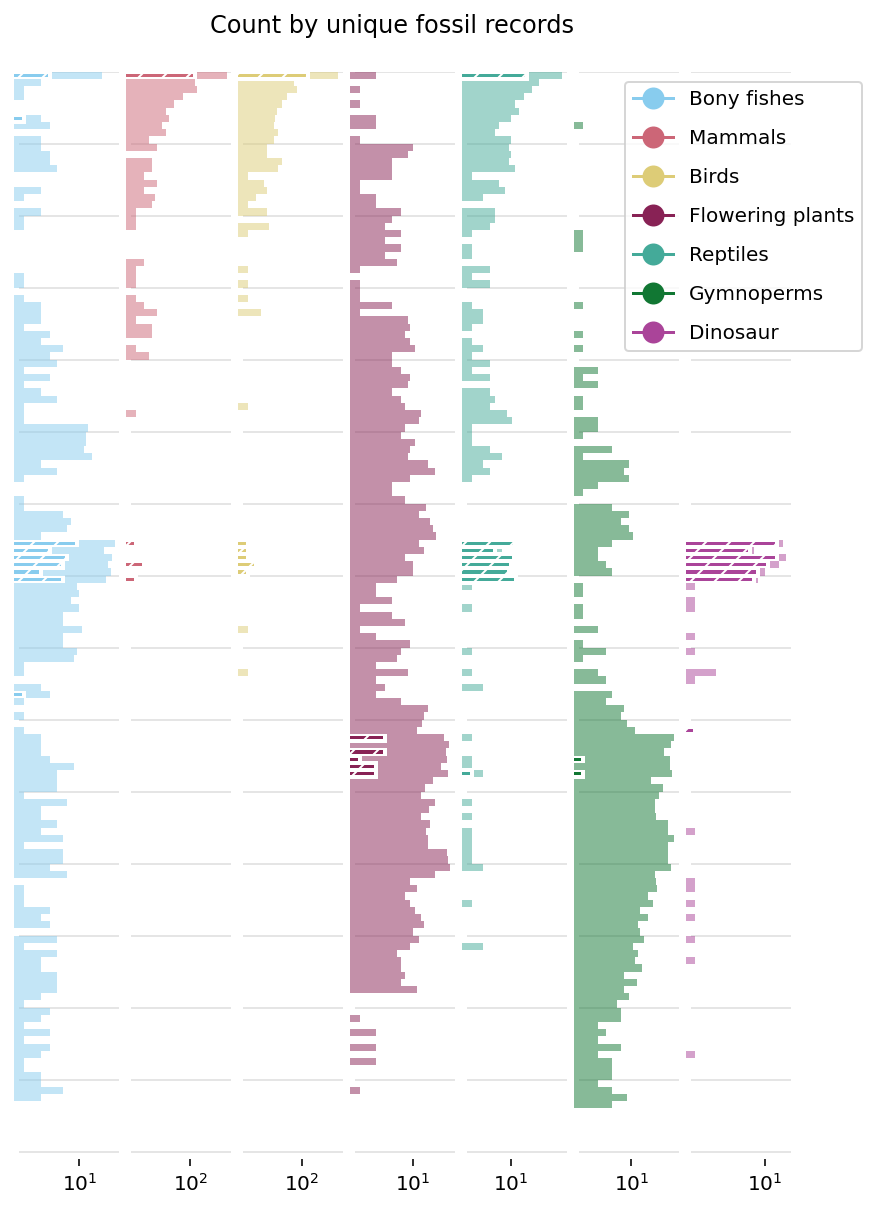

In [235]:
plt.figure(figsize=(7,10),facecolor='w')
G = gridspec.GridSpec(1,len(fossil['common_name'].unique()),hspace=0.0,wspace=0.02)
# fig, axes = plt.subplots(nrows=1, ncols=len(fossil['common_name'].unique()), figsize=(5,10), sharex=False, sharey=True)

commnames_coldict={'Bony fishes':'#88CCEE','Mammals':'#CC6677','Birds':'#DDCC77','Flowering plants':'#882255','Reptiles':'#44AA99', 'Gymnoperms':'#117733','Dinosaur':'#AA4499'}
fossil['timebin'] = pd.cut(fossil['rand_ma'],labels = False, bins = round(fossil['rand_ma'].max()))
endemicdb=fossil[fossil['cc']=='MG']
height = 1

for index,phy in enumerate(fossil['common_name'].unique()):
    temp = fossil[fossil['common_name'] == phy]
    endtemp = endemicdb[endemicdb['common_name'] == phy]
    
    ax=plt.subplot(G[0,index])
#     ax = axes[index]
    ax.set_ylim(round(extant['mean_crown_plot'].max()),0)
#     ax.set_xlim(0,2500)
    
    for timebin in temp['timebin'].unique():
        temp1 = temp[temp['timebin'] == timebin]
        endtemp1 = endtemp[endtemp['timebin'] == timebin]
        bottom = 0
        width = len(temp1)
#         print(width)
        widthend = len(endtemp1)
        ax.barh(y = timebin, width = width, height = height, left = bottom, align = 'edge', facecolor = commnames_coldict[phy], edgecolor = 'none',zorder = 10, lw = 0.8, alpha = 0.5)
        ax.barh(y = timebin, width = widthend, height = height, left = bottom, align = 'edge', facecolor = commnames_coldict[phy], edgecolor = 'w',zorder = 10, lw = 2, alpha = 1, hatch='//')
    ax.set_yticks([])
    plt.xscale('log')
#     ax.set_xlim(0,np.log(100000000000))
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
legend_elements=[]
for key,value in commnames_coldict.items():
    legend_elements.append(Line2D([0],[0],marker='o',color=value,label=key,markersize=10))
ax.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.2, 0.5, 0.5, 0.5),labelspacing=1)
plt.suptitle('Count by unique fossil records',y=0.92)
# plt.savefig('./fossilall.svg',dpi=300)
plt.show()

C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


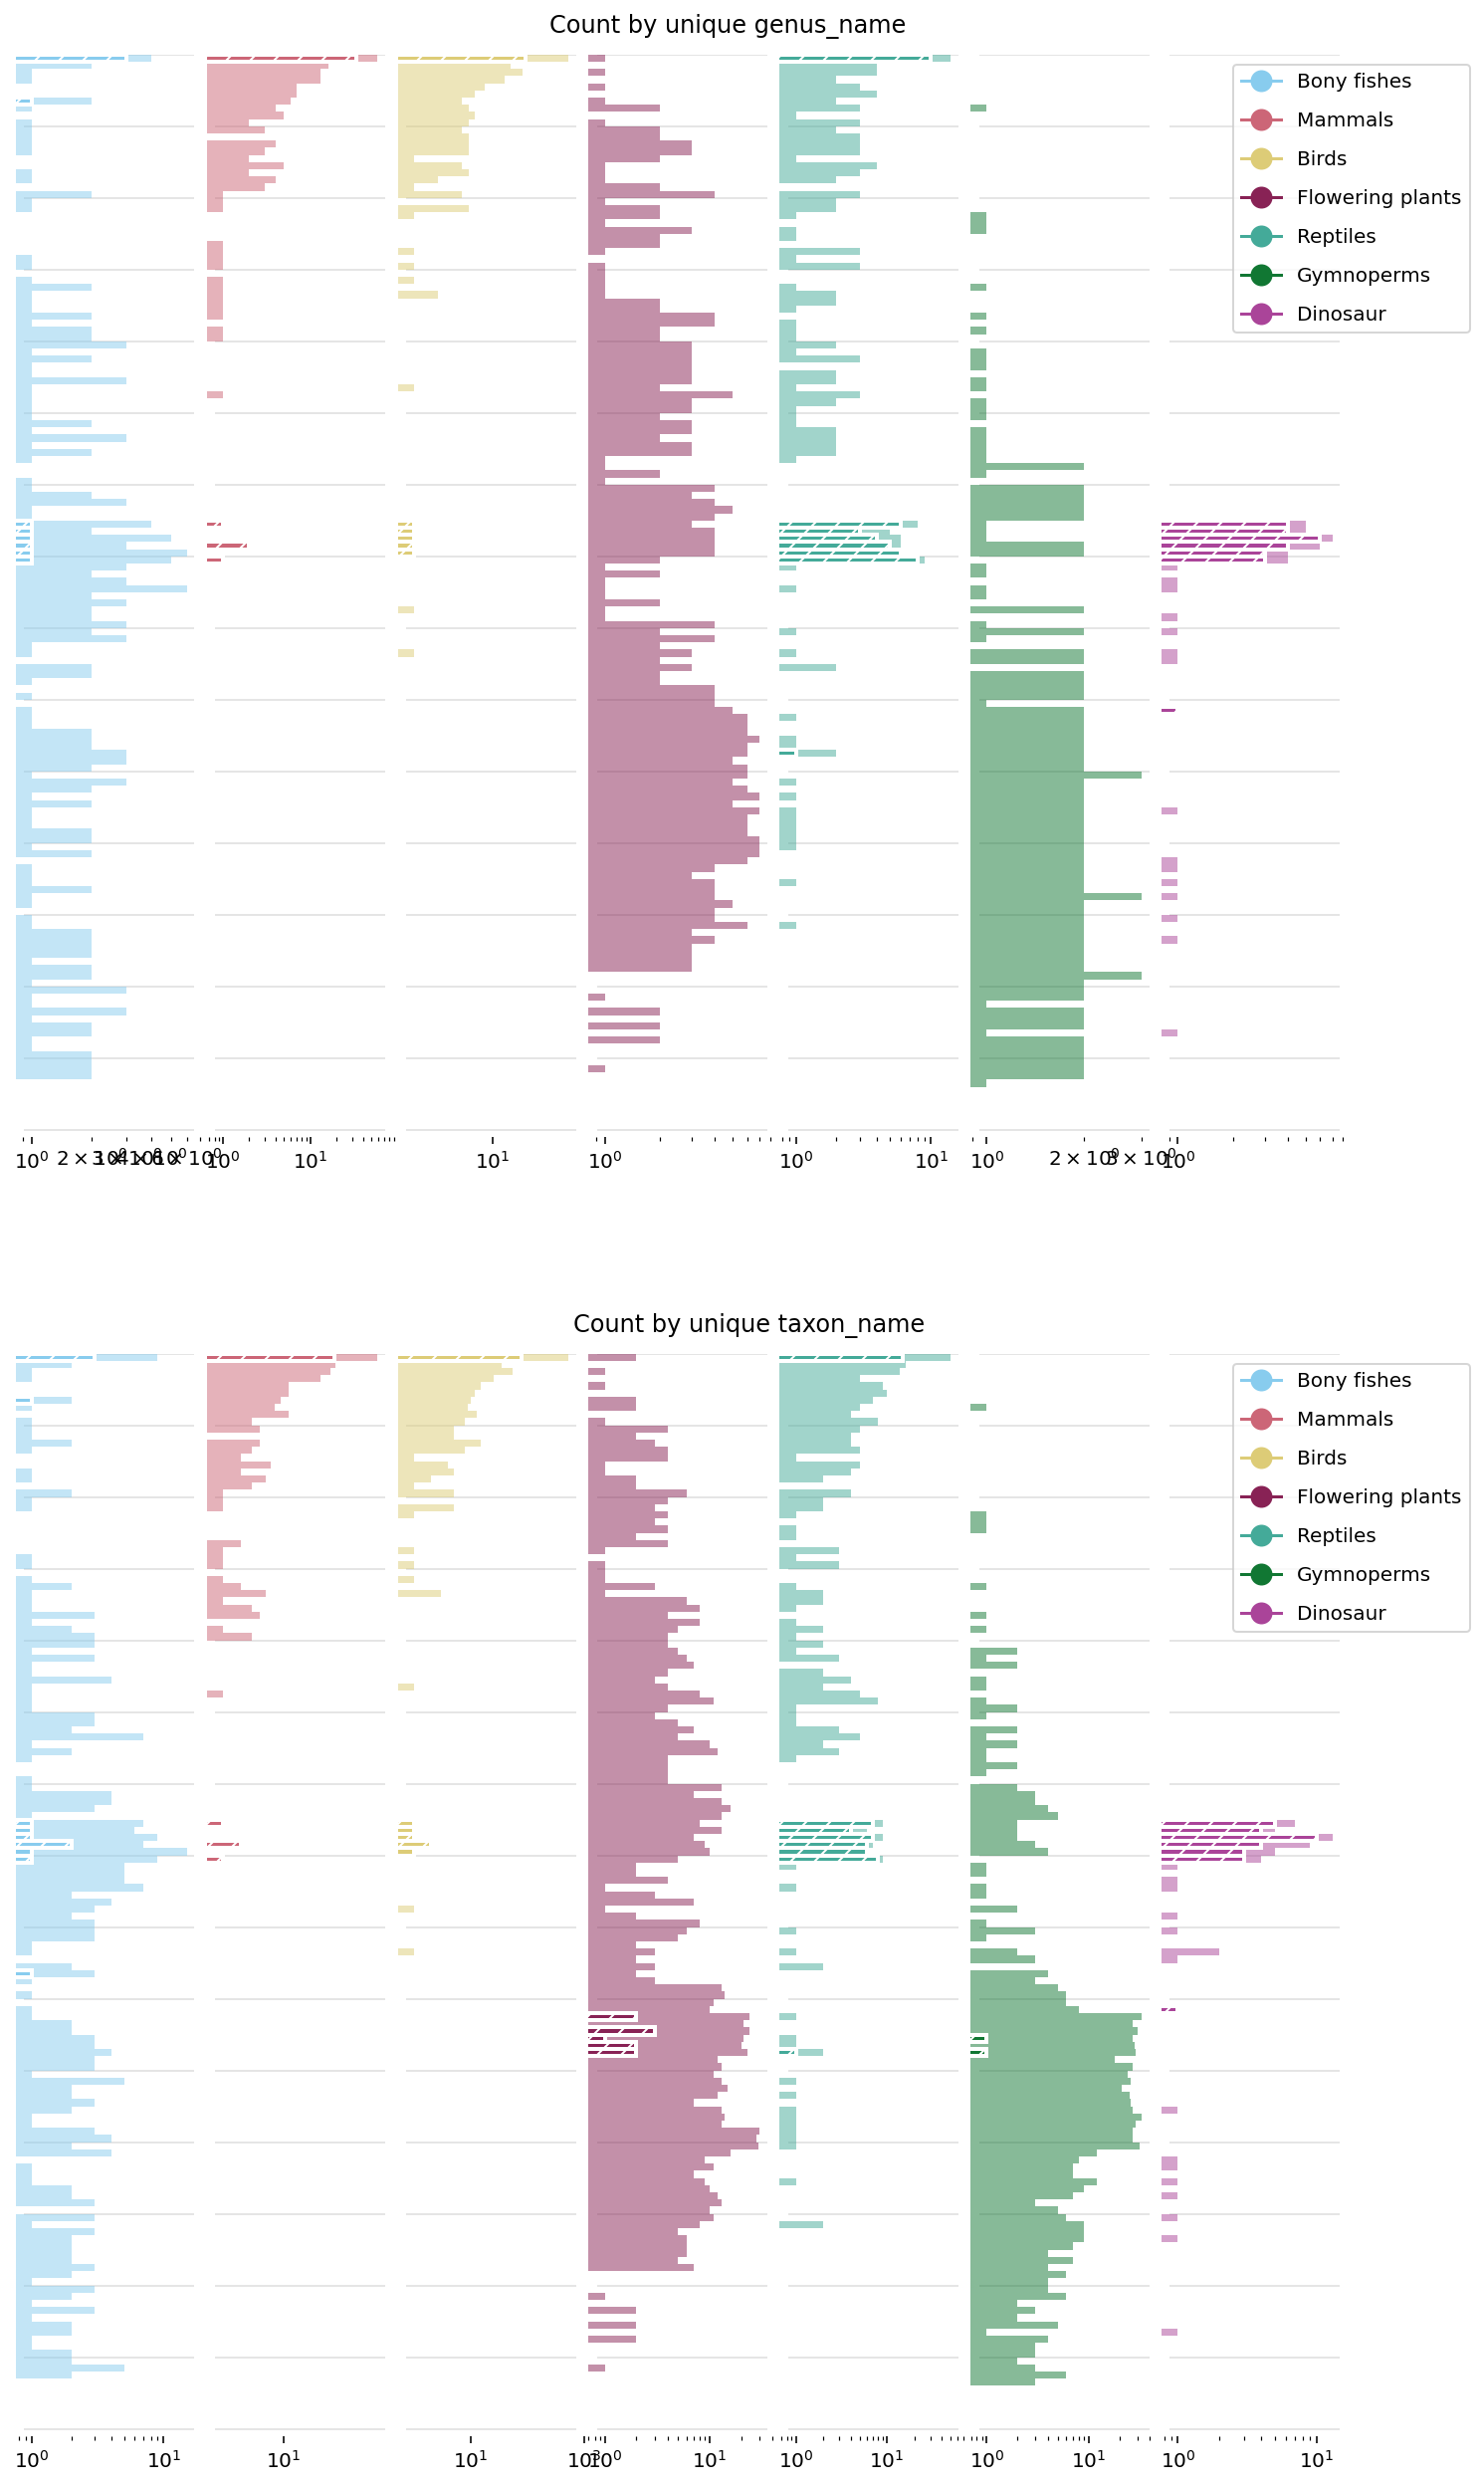

In [351]:
plt.figure(figsize=(12,22),facecolor='w')
G = gridspec.GridSpec(2,len(fossil['common_name'].unique()),hspace=0.2,wspace=0.02)
# fig, axes = plt.subplots(nrows=1, ncols=len(fossil['common_name'].unique()), figsize=(5,10), sharex=False, sharey=True)

commnames_coldict={'Bony fishes':'#88CCEE','Mammals':'#CC6677','Birds':'#DDCC77','Flowering plants':'#882255','Reptiles':'#44AA99', 'Gymnoperms':'#117733','Dinosaur':'#AA4499'}
fossil['timebin'] = pd.cut(fossil['rand_ma'],labels = False, bins = round(fossil['rand_ma'].max()))
# endemicdb=fossil[fossil['cc']=='MG']
height = 1
# iterates through the two columns we are considering
for ii,unit in enumerate(['genus_name','taxon_name']):
    # iterates through the list of unique common names
    for index,phy in enumerate(fossil['common_name'].unique()):
        # filters the data for that common name
        temp = fossil[fossil['common_name'] == phy]
        # assigns axis
        ax=plt.subplot(G[ii,index])
        ax.set_ylim(round(extant['mean_crown_plot'].max()),0)
        
        # group by timebin and count the number of unique units (genera or species)
        temp1 = temp.groupby(by=['timebin'])[unit].nunique().reset_index()
        ax.barh(y = temp1['timebin'], width = temp1[unit], height = height, left = 0, align = 'edge', facecolor = commnames_coldict[phy], edgecolor = 'none',zorder = 10, lw = 0.8, alpha = 0.5)
        
        temp.dropna(subset = ['cc'], inplace = True)
        # because we need to account for each different unit within each timebin. 
        temp2 = temp.groupby(by=['timebin',unit])['cc'].agg(['unique']).reset_index()
        temp3 = temp2[temp2['unique'].isin(['MG'])]
        
        endemic = temp3.groupby(by = ['timebin'])[unit].nunique().reset_index()
        ax.barh(y = endemic['timebin'], width = endemic[unit], height = height, left = bottom, align = 'edge', facecolor = commnames_coldict[phy], edgecolor = 'w',zorder = 10, lw = 2, alpha = 1, hatch='//')
        ax.set_yticks([])
        plt.xscale('log')
    #     ax.set_xlim(0,np.log(100000000000))
        [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
        ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
        
        if index == 3:
            ax.text(0.5, -3, 'Count by unique %s'%(unit), fontsize = 12)
    legend_elements=[]
    for key,value in commnames_coldict.items():
        legend_elements.append(Line2D([0],[0],marker='o',color=value,label=key,markersize=10))
    ax.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.2, 0.5, 0.5, 0.5),labelspacing=1)
    
# plt.savefig('./fossilall.svg',dpi=300)
plt.show()

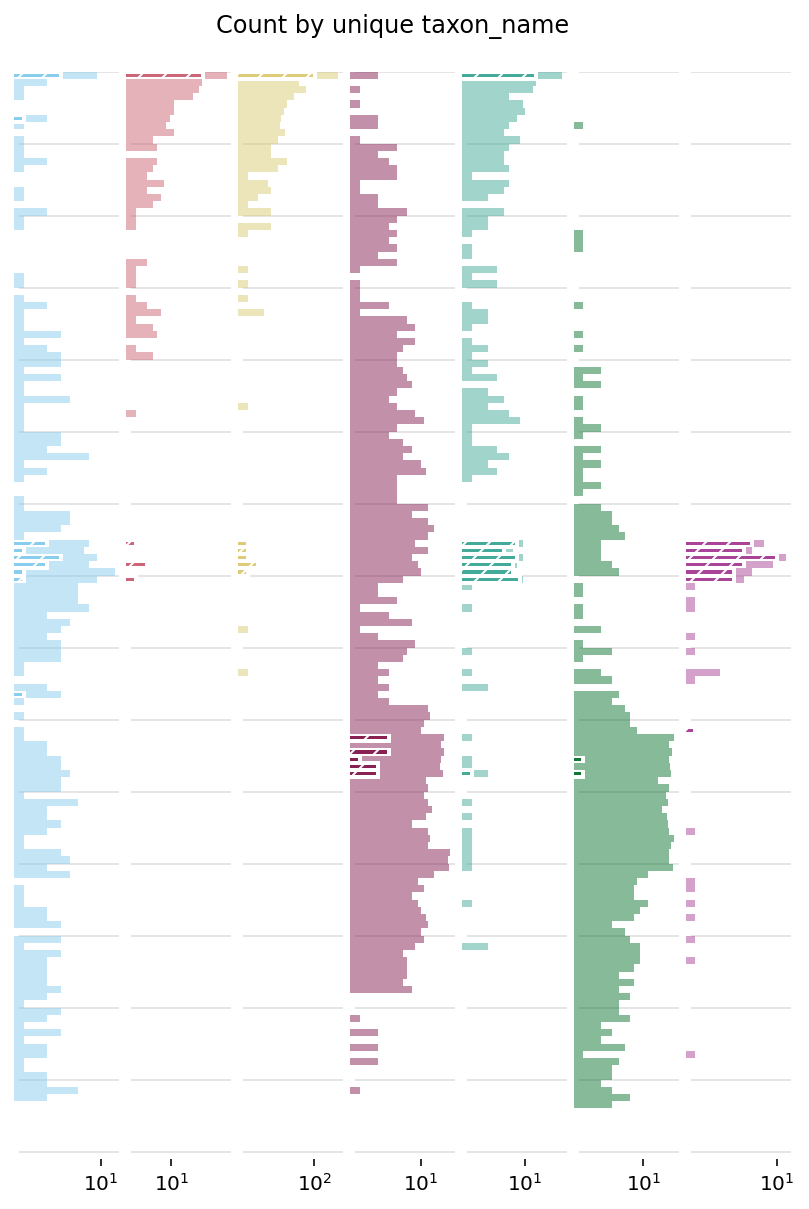

In [252]:
plt.figure(figsize=(7,10),facecolor='w')
G = gridspec.GridSpec(1,len(fossil['common_name'].unique()),hspace=0.0,wspace=0.02)
# fig, axes = plt.subplots(nrows=1, ncols=len(fossil['common_name'].unique()), figsize=(5,10), sharex=False, sharey=True)

commnames_coldict={'Bony fishes':'#88CCEE','Mammals':'#CC6677','Birds':'#DDCC77','Flowering plants':'#882255','Reptiles':'#44AA99', 'Gymnoperms':'#117733','Dinosaur':'#AA4499'}
fossil['timebin'] = pd.cut(fossil['rand_ma'],labels = False, bins = round(fossil['rand_ma'].max()))
endemicdb=fossil[fossil['cc']=='MG']
height = 1

for index,phy in enumerate(fossil['common_name'].unique()):
    temp = fossil[fossil['common_name'] == phy]
    endtemp = endemicdb[endemicdb['common_name'] == phy]
    
    ax=plt.subplot(G[0,index])
#     ax = axes[index]
    ax.set_ylim(round(extant['mean_crown_plot'].max()),0)
#     ax.set_xlim(0,2500)
    
    temp1 = temp.groupby(by=['timebin'])['taxon_name'].nunique().reset_index()
    endtemp1 = endtemp.groupby(by=['timebin'])['taxon_name'].nunique().reset_index()
#     print(temp1)
    
    for timebin in temp['timebin'].unique():
        temp2 = temp1[temp1['timebin'] == timebin]
#         print(temp2)
        endtemp2 = endtemp1[endtemp1['timebin'] == timebin]
        bottom = 0
        width = temp2['taxon_name']
#         print(width)
        widthend = endtemp2['taxon_name']
        ax.barh(y = timebin, width = width, height = height, left = bottom, align = 'edge', facecolor = commnames_coldict[phy], edgecolor = 'none',zorder = 10, lw = 0.8, alpha = 0.5)
        ax.barh(y = timebin, width = widthend, height = height, left = bottom, align = 'edge', facecolor = commnames_coldict[phy], edgecolor = 'w',zorder = 10, lw = 2, alpha = 1, hatch='//')
    ax.set_yticks([])
    plt.xscale('log')
#     ax.set_xlim(0,np.log(100000000000))
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),10)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    
legend_elements=[]
for key,value in commnames_coldict.items():
    legend_elements.append(Line2D([0],[0],marker='o',color=value,label=key,markersize=10))
ax1.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.2, 0.5, 0.5, 0.5),labelspacing=1)
plt.suptitle('Count by unique taxon_name',y=0.92)
# plt.savefig('./fossilall.svg',dpi=300)
plt.show()

In [247]:
fossil.columns
fossil[['species_name','taxon_name']]

species_name                 taxon_name
0      suessionensis  Lepisosteus suessionensis
1      suessionensis  Lepisosteus suessionensis
2      suessionensis  Lepisosteus suessionensis
3                sp.                  Mus ? sp.
4        erymanthius            Sus erymanthius
...              ...                        ...
9719  novaezelandiae    Coturnix novaezelandiae
9720         auritus      Phalacrocorax auritus
9721             sp.          Lepidotus cf. sp.
9722        herodias             Ardea herodias
9723           albus          Casmerodius albus

[9481 rows x 2 columns]

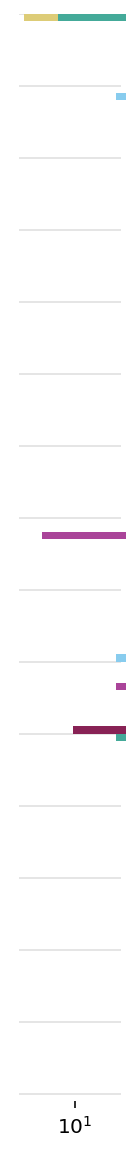

In [155]:
def fossilendemic(dataset,ax,colordict='',unit='', by='common_name',byorder='',time='early_age',height=1,alpha = 0.9): # unit='genus_name', bins=round(dataset[time].max()),   
    names=[]
    if byorder!= '':
        names=byorder
    else:
        names=dataset[by].unique()
    for timebin in dataset['timebin'].unique():
        temp = dataset[dataset['timebin'] == timebin]
        bottom = 0
        for phy in names:
            width = len(temp[temp[by] == phy])
            ax.barh(y = timebin, width = width, height = height, left = bottom, align = 'edge', facecolor = colordict[phy], edgecolor = 'none',zorder = 10, lw = 0.8, alpha = alpha)
#             bottom += width
    ax.set_yticks([])        
    plt.xscale('log')
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] 
    return ax

plt.figure(figsize=(1,10),facecolor='none')
G = gridspec.GridSpec(1,1,hspace=0.0,wspace=0.05)

ax7=plt.subplot(G[0,0])
ax7.set_ylim(round(extant['mean_crown_plot'].max()),0)

fossil['timebin'] = pd.cut(fossil['early_age'],labels = False, bins = round(fossil['early_age'].max()))
endemicdb=fossil[fossil['cc']=='MG']

fossilendemic(endemicdb,ax=ax7,colordict=commnames_coldict,unit='index', by='common_name',byorder=fossilorder,time='rand_ma',height=1, alpha=1)
ax7.hlines(y = [mya for mya in range(0,int(ax7.get_ylim()[0]),10)], xmin = ax7.get_xlim()[0], xmax = ax7.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
plt.gca().invert_xaxis()
# plt.savefig('./fossilmag.svg',dpi=300)
plt.show()

C:\Users\xtorrm\Documents\Python3\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


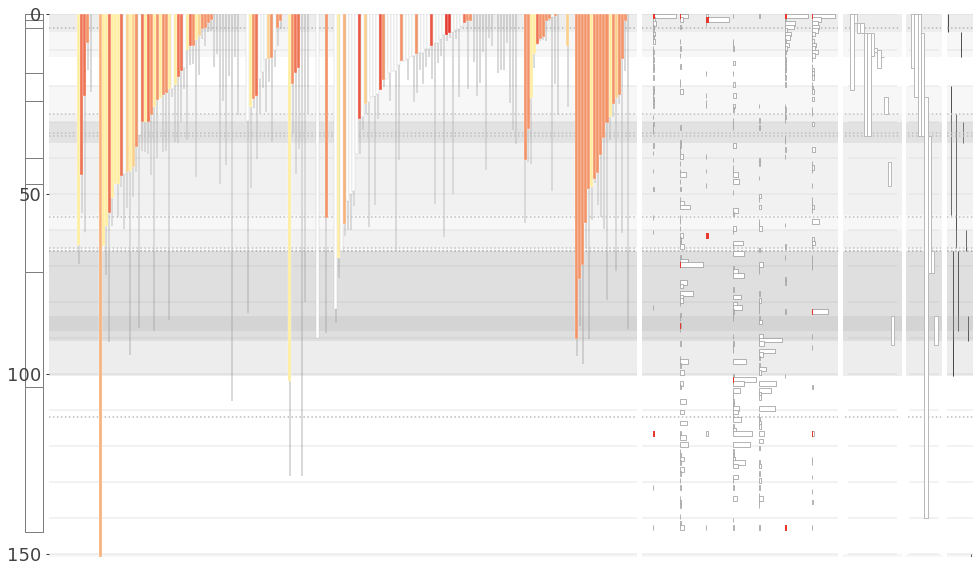

In [228]:
plt.figure(figsize=(17,10),facecolor='none')
G = gridspec.GridSpec(1,6,hspace=0.0,wspace=0.03,width_ratios=[0.03,0.9,0.3,0.09,0.055,0.04])

darkcol = '#a8a8a8'
lightcol = '#d9d9d9'

ax1=plt.subplot(G[0,0])
plt.gca().invert_yaxis()
epochbase = 0
for key,value in geol_time_dict.items():
    ax1.bar(x = 0, height = value[1] - value[0], width = 2, bottom = epochbase, align = 'edge', edgecolor = '#7d7d7d', lw = 1, alpha = 1,
               color = 'none', zorder = 100)
    epochbase += value[1] - value[0]
# ------------------------------------ early cret to pleistocene extant
ax3=plt.subplot(G[0,1])
ax3.set_ylim(round(extant['mean_crown_plot'].max()),0);plt.gca().invert_yaxis()
lineageplot(extant,ax=ax3,colby='sister_lineage_plot',colbydict=orcoldict,by='common_name',byorder=sorted(extant_span.keys()),unit='name', crown='mean_crown_plot',stem='mean_stem_plot',
          width=1,bottom=0,xbase=0,offset=2.1,span='',tickrange=50,lw=0.3) # extant_span
addshade(shades, holocene = '', ax = ax3, darkcol = darkcol, lightcol = lightcol)

# ------------------------------------ early cret to pleistocene fossil
ax4=plt.subplot(G[0,2])
ax4.set_ylim(round(extant['mean_crown_plot'].max()),0);plt.gca().invert_yaxis()
fossilplot(fossil,ax = ax4, color = 'w',by='common_name',byorder = sorted(fossil_span.keys()),unit = 'taxon_name', time = 'mean_age', # change taxon_name to genus_name for genera
           bins=round(fossil['mean_age'].max()),bottom=0,offset=1.15,span='',tickrange=50,normalise=True,height=1.3,endemic=True, fossildict = endemic_fosplotdictspp)
# fossilplot(fossil,ax = ax4, color = 'w',by='common_name',byorder = sorted(fossil_span.keys()),unit = 'genus_name', time = 'mean_age',
#            bins=round(fossil['mean_age'].max()),bottom=0,offset=1.15,span=fossil_span,tickrange=50,normalise=False,height=1.3,endemic=True)
addshade(shades, holocene = '', ax = ax4, darkcol = darkcol, lightcol = lightcol)

# ------------------------------------ volcanos
ax5=plt.subplot(G[0,3])
ax5.set_ylim(0,round(extant['mean_crown_plot'].max()));plt.gca().invert_yaxis()
addvolcanos(volcanism, holocene = '', offset = 0.05, color = 'w', ax = ax5, levels = len(volcanism))
addshade(shades, holocene = '', x = 0, lines = False, offset = 1, lw = 0.5, ax = ax5, darkcol = darkcol, lightcol = lightcol)
ax5.hlines(y = [mya for mya in range(0,int(ax5.get_ylim()[0]),10)], xmin = ax5.get_xlim()[0], xmax = ax5.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)

# ------------------------------------ landscape
ax6=plt.subplot(G[0,4])
ax6.set_ylim(0,round(extant['mean_crown_plot'].max()));plt.gca().invert_yaxis()
addvolcanos(landscape, holocene = '', offset = 0.05, color = 'w', ax = ax6, levels = len(landscape))
addshade(shades, holocene = '', x = 0, lines = False, offset = 1, lw = 0.5, ax = ax6, darkcol = darkcol, lightcol = lightcol)
ax6.hlines(y = [mya for mya in range(0,int(ax6.get_ylim()[0]),10)], xmin = ax6.get_xlim()[0], xmax = ax6.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)

# ------------------------------------ shades early cret to pleis
ax7=plt.subplot(G[0,5])
ax7.set_ylim(0,round(extant['mean_crown_plot'].max()));plt.gca().invert_yaxis()
ax7.set_xlim(-0.5,len(shades))
addshade(shades, holocene = '', x = 0, lines = True, offset = 1, lw = 0.8, ax = ax7, darkcol = darkcol, lightcol = lightcol)
ax7.hlines(y = [mya for mya in range(0,int(ax7.get_ylim()[0]),10)], xmin = ax7.get_xlim()[0], xmax = ax7.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)

for ax in [ax1,ax3,ax4,ax5,ax6,ax7]:
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_xticks([])
    if ax != ax3:
        ax.set_yticks([])
    if ax != ax1:
        lineevents(pointevents,holocene = False, lw = 1.5, ax = ax, color = '#bababa', ls = 'dotted')
# plt.savefig('./Fig2_20210314.svg', dpi=200)
plt.show()
# no gray, make it white with dark background if you use the shades
# ax3.set_ylim(3,0);plt.gca().invert_yaxis()


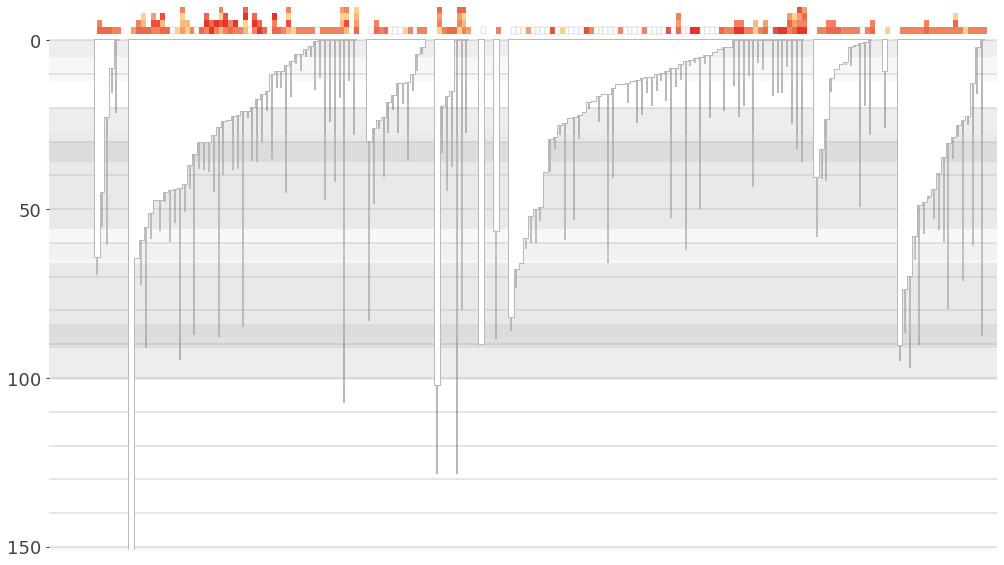

In [25]:
from matplotlib.patches import Rectangle


plt.figure(figsize=(17,10),facecolor='none')
G = gridspec.GridSpec(1,1,hspace=0.0,wspace=0.03,width_ratios=[0.9])

darkcol = '#a8a8a8'
lightcol = '#d9d9d9'

def lineageplot2(dataset,ax,colby='sister_lineage_plot',colbydict=orcoldict,by='common_name',byorder='',unit='name', crown='mean_crown_plot',stem='mean_stem_plot',
          width=1,bottom=0,xbase=0,offset=2,span='',tickrange=20,lw=1, zorder = 100, hlines = 10, ybase = '', edgecolordict = edgecolordict):
    """
    plots lineage ages from left (earliest crown age) to right (crown ages closest to present)
    dataset=dataframe object
    colby=column name (str) by which the colour is applied
    colbydict=dictionary for colby with values == colors
    by=column name (str) by which separate the lineage groups
    byorder=ordered list of names if random order is not desired
    unit=column name (str) that represent lineage units (plotted as a vertical bar)
    crown=column name (str) with the crown ages
    stem=column name (str) with the stem ages
    span=dictionary name:distance with the span on the x axis between each 'by' group
    """
    plt.gca().invert_yaxis()
    names=[]
    if byorder!= '':
        names=byorder
    else:
        names=dataset[by].unique()
    for phy in names:
        temp = dataset[dataset[by] == phy].drop_duplicates(subset=[by,unit])  # the original list has duplicated entries when two papers had different 95% age ranges. We are using the 
        # x is a list of the xaxis positions and the lineage name. Made from the i,x lists in which i=index and name = name
        x = [i + xbase for i,name in enumerate(temp[unit].unique())]
#         print('unit',len(temp[unit].unique()),len(x))
        height = temp[crown].values
        ax.bar(x = x, height = height, width = width, bottom = bottom, align = 'center', edgecolor = [edgecolordict[x] for x in temp[colby]] if edgecolordict else '#bababa', lw = lw, alpha = 1,
               color = [colbydict[x] for x in temp[colby]], zorder = zorder)
        # plotting stem ages when available
        ax.vlines(x = [(i + xbase) for i,name in enumerate(temp[unit].unique())], ymin = temp[crown], ymax = temp[stem], color='k', lw = 0.3, zorder = 1)
        # adds an extra space to separate lineages from each 'common name'
        
        if ybase != '':
            xxbase = xbase
            heights = width+1
            for origin in temp['sister_lineage_list']:
                ybase_sites = ybase
                for loc in origin.split('_'):
                    rect = Rectangle((xxbase,ybase_sites),width,heights,linewidth=0.4,edgecolor='#bababa' if loc == 'Unknown' else 'none',facecolor=orlistcoldict[loc])
                    ax.add_patch(rect)
                    ybase_sites = ybase_sites + (0 if len(origin) == 1 else -heights)
                xxbase += 1

        xbase +=  offset + (span[phy]  if span != '' else len(temp[stem].values)) # len(temp[crown].values) # (len(temp[crown].values) + len(temp[stem].values))/2

    # set xlims using the last xbase value set
    ax.set_xlim(-10,xbase)
    # Adding the time lines for every 10 Mya
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),hlines)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, 
              color = 'k', zorder = 1)
    ax.set_yticks(ticks = [mya for mya in range(0,int(ax.get_ylim()[0]),tickrange)]); plt.yticks(color = '#424242', fontsize = 18)
    ax.set_xticks([])

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    return ax

whitedict = {key:'#ffffff' for key in orcoldict.keys()}

ax3=plt.subplot(G[0,0])
ax3.set_ylim(round(extant['mean_crown_plot'].max()),-10);plt.gca().invert_yaxis()
lineageplot2(extant,ax=ax3,colby='sister_lineage_plot',colbydict=whitedict,by='common_name',byorder=sorted(extant_span.keys()),unit='name', crown='mean_crown_plot',stem='mean_stem_plot',
          width=1,bottom=0,xbase=0,offset=2.1,span='',tickrange=50,lw=2, edgecolordict = '') # extant_span
plt.gca().invert_yaxis()
lineageplot2(extant,ax=ax3,colby='sister_lineage_plot',colbydict=whitedict,by='common_name',byorder=sorted(extant_span.keys()),unit='name', crown='mean_crown_plot',stem='mean_stem_plot',
          width=1,bottom=0,xbase=0,offset=2.1,span='',tickrange=50,lw=0,  ybase = -4) # extant_span
addshade(shades, holocene = '', ax = ax3, darkcol = darkcol, lightcol = lightcol)

# plt.savefig('./Fig2_20210314.svg', dpi=200)
plt.show()
# no gray, make it white with dark background if you use the shades
# ax3.set_ylim(3,0);plt.gca().invert_yaxis()


In [244]:
xbase = 0
for x, origin in zip([i + xbase for i,name in enumerate(extant['name'].unique())],extant['sister_lineage_list']):
#     print(x,origin.split('_'))
    for loc in origin.split('_'):
        print(x,loc)

0 Oceania
1 SAmerica
1 Africa
1 Oceania
1 Asia
2 Africa
3 Unknown
4 Unknown
5 Africa
6 Africa
7 Unknown
8 Unknown
9 Asia
9 Africa
10 Asia
10 Africa
11 Asia
11 NAmerica
11 SAmerica
12 Oceania
13 Africa
14 Africa
15 Asia
16 Asia
17 Unknown
18 Africa
18 Eurasia
18 Oceania
19 Unknown
20 Unknown
21 Africa
22 Asia
22 Africa
23 Africa
23 Eurasia
24 Asia
24 NAmerica
24 Eurasia
25 Africa
26 Asia
27 Asia
28 Unknown
29 Africa
30 SAmerica
31 Oceania
31 NAmerica
31 SAmerica
31 Africa
31 Asia
31 Eurasia
32 SAmerica
32 NAmerica
33 Africa
34 Africa
35 Unknown
36 Africa
37 Africa
38 Unknown
39 Africa
40 Africa
41 Asia
42 Africa
42 Madagascar
42 Asia
43 Madagascar
43 Asia
44 Unknown
45 Eurasia
46 Africa
46 Asia
46 SAmerica
47 Unknown
48 Africa
48 Madagascar
49 Asia
49 Africa
50 NAmerica
50 Eurasia
50 SAmerica
50 Africa
50 Asia
50 Madagascar
50 Oceania
51 Africa
52 SAmerica
53 Unknown
54 Africa
54 Madagascar
54 Eurasia
55 Africa
56 Asia
56 Africa
57 SAmerica
58 Asia
58 Africa
59 Unknown
60 Asia
61 Asia
6

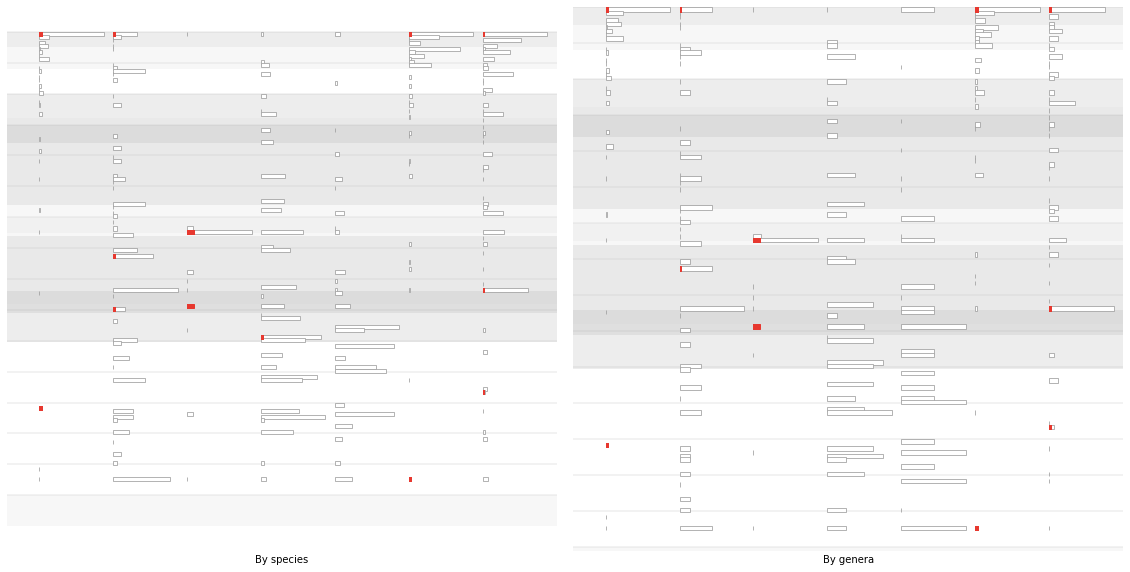

In [27]:
plt.figure(figsize=(20,10),facecolor='w')
G = gridspec.GridSpec(1,2,hspace=0.0,wspace=0.03)

ax4=plt.subplot(G[0,0])
# ax4.set_ylim(round(extant['mean_crown_plot'].max()),0);
# plt.gca().invert_yaxis()
fossilplot(fossil,ax = ax4, color = 'w',by='common_name',byorder = sorted(sppfossil_span.keys()),unit = 'taxon_name', time = 'early_age', # change taxon_name to genus_name for genera
           bins=round(fossil['early_age'].max()),bottom=0,offset=1.15,span='',tickrange=50,normalise=True,height=1.3,endemic=True, fossildict = endemic_fosplotdictspp)
# fossilplot(fossil,ax = ax4, color = 'w',by='common_name',byorder = sorted(fossil_span.keys()),unit = 'genus_name', time = 'mean_age',
#            bins=round(fossil['mean_age'].max()),bottom=0,offset=1.15,span=fossil_span,tickrange=50,normalise=False,height=1.3,endemic=True)
addshade(shades, holocene = '', ax = ax4, darkcol = darkcol, lightcol = lightcol)
ax4.set_xlabel('By species')

ax5=plt.subplot(G[0,1])
ax5.set_ylim(round(extant['mean_crown_plot'].max()),0);plt.gca().invert_yaxis()
fossilplot(fossil,ax = ax5, color = 'w',by='common_name',byorder = sorted(genfossil_span.keys()),unit = 'genus_name', time = 'early_age', # change taxon_name to genus_name for genera
           bins=round(fossil['early_age'].max()),bottom=0,offset=1.15,span='',tickrange=50,normalise=True,height=1.3,endemic=True, fossildict = endemic_fosplotdictgen)
# fossilplot(fossil,ax = ax4, color = 'w',by='common_name',byorder = sorted(fossil_span.keys()),unit = 'genus_name', time = 'mean_age',
#            bins=round(fossil['mean_age'].max()),bottom=0,offset=1.15,span=fossil_span,tickrange=50,normalise=False,height=1.3,endemic=True)
addshade(shades, holocene = '', ax = ax5, darkcol = darkcol, lightcol = lightcol)
ax5.set_xlabel('By genera')

plt.show()

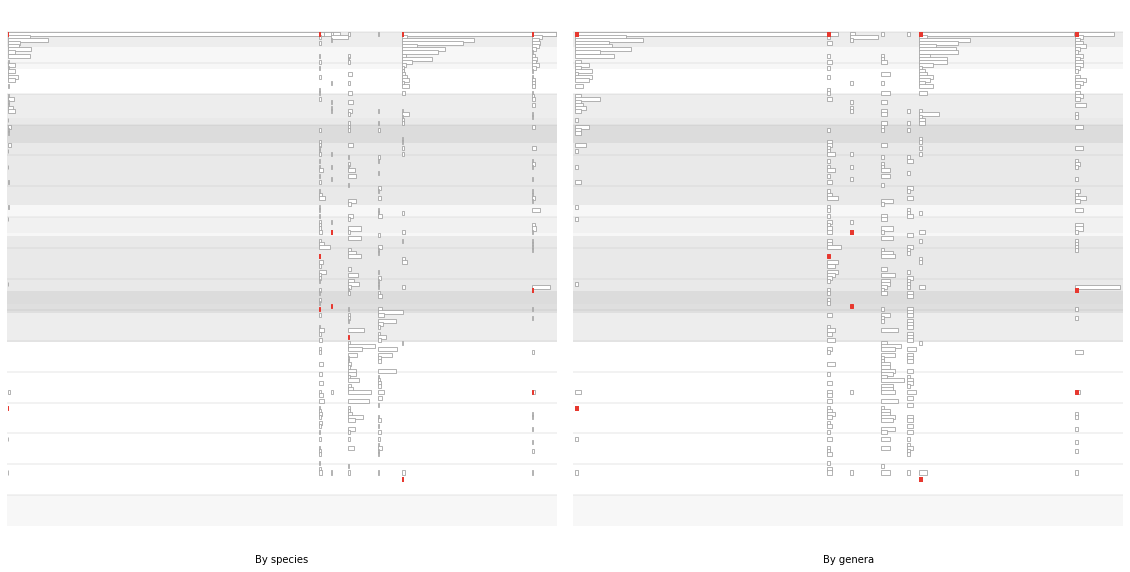

In [28]:
plt.figure(figsize=(20,10),facecolor='w')
G = gridspec.GridSpec(1,2,hspace=0.0,wspace=0.03)

ax4=plt.subplot(G[0,0])
# ax4.set_ylim(round(extant['mean_crown_plot'].max()),0);plt.gca().invert_yaxis()
# fossilplot(fossil,ax = ax4, color = 'w',by='common_name',byorder = sorted(sppfossil_span.keys()),unit = 'taxon_name', time = 'mean_age', # change taxon_name to genus_name for genera
#            bins=round(fossil['mean_age'].max()),bottom=0,offset=1.15,span='',tickrange=50,normalise=True,height=1.3,endemic=True, fossildict = endemic_fosplotdictspp)
fossilplot(fossil,ax = ax4, color = 'w',by='common_name',byorder = sorted(sppfossil_span.keys()),unit = 'taxon_name', time = 'mean_age',
           bins=round(fossil['mean_age'].max()),bottom=0,offset=1.15,span=sppfossil_span,tickrange=50,normalise=False,height=1.3,endemic=True, fossildict = endemic_fosplotdictspp)
addshade(shades, holocene = '', ax = ax4, darkcol = darkcol, lightcol = lightcol)
ax4.set_xlabel('By species')

ax5=plt.subplot(G[0,1])
# ax5.set_ylim(round(extant['mean_crown_plot'].max()),0);plt.gca().invert_yaxis()
# fossilplot(fossil,ax = ax5, color = 'w',by='common_name',byorder = sorted(genfossil_span.keys()),unit = 'genus_name', time = 'mean_age', # change taxon_name to genus_name for genera
#            bins=round(fossil['mean_age'].max()),bottom=0,offset=1.15,span='',tickrange=50,normalise=True,height=1.3,endemic=True, fossildict = endemic_fosplotdictgen)
fossilplot(fossil,ax = ax5, color = 'w',by='common_name',byorder = sorted(genfossil_span.keys()),unit = 'genus_name', time = 'mean_age',
           bins=round(fossil['mean_age'].max()),bottom=0,offset=1.15,span=genfossil_span,tickrange=50,normalise=False,height=1.3,endemic=True, fossildict = endemic_fosplotdictgen)
addshade(shades, holocene = '', ax = ax5, darkcol = darkcol, lightcol = lightcol)
ax5.set_xlabel('By genera')

plt.show()

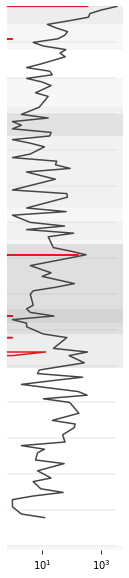

In [173]:
plt.figure(figsize=(10,10),facecolor='w')
G = gridspec.GridSpec(1,6,hspace=0.0,wspace=0.03,width_ratios=[0.03,0.9,0.3,0.09,0.055,0.04])

darkcol = '#a8a8a8'
lightcol = '#d9d9d9'

# ax1=plt.subplot(G[0,0])
# plt.gca().invert_yaxis()
# epochbase = 0
# for key,value in geol_time_dict.items():
#     ax1.bar(x = 0, height = value[1] - value[0], width = 2, bottom = epochbase, align = 'edge', edgecolor = '#7d7d7d', lw = 1, alpha = 1,
#                color = 'none', zorder = 100)
#     epochbase += value[1] - value[0]
# ------------------------------------ early cret to pleistocene extant
# ax3=plt.subplot(G[0,1])
# ax3.set_ylim(round(extant['mean_crown_plot'].max()),0);plt.gca().invert_yaxis()
# lineageplot(extant,ax=ax3,colby='sister_lineage_plot',colbydict=orcoldict,by='common_name',byorder=sorted(extant_span.keys()),unit='name', crown='mean_crown_plot',stem='mean_stem_plot',
#           width=1,bottom=0,xbase=0,offset=2.1,span='',tickrange=50,lw=0.3) # extant_span
# addshade(shades, holocene = '', ax = ax3, darkcol = darkcol, lightcol = lightcol)

# ------------------------------------ early cret to pleistocene fossil
ax4=plt.subplot(G[0,2])
# ax4.set_ylim(0,round(extant['mean_crown_plot'].max()));plt.gca().invert_yaxis()
# ax4.set_xlim(0,fossilclean.groupby(by='timebin')['index'].count().max()*1.05)
height = 1
bottom = 0.5

time = []
fossils = []
for timebin in sorted(fossilclean['timebin'].unique()):
    width = len(fossilclean[fossilclean['timebin'] == timebin])
    time.append(timebin)
    fossils.append(width)
#     ax4.barh(y = timebin, width = width, height = height, left = bottom, align = 'edge', color = 'w', edgecolor = '#a1a1a1', zorder = 100, lw = 0.8)
ax4.plot(fossils, time, linestyle='-', linewidth=1.5, color ='#454545',zorder = 100)

timeend = []
fossilsend = []
endemic = fossilclean[fossilclean['index'].isin(endemic_fossilrecords)]
for timebin in sorted(fossilclean['timebin'].unique()):
    width = len(endemic[endemic['timebin'] == timebin])
    timeend.append(timebin)
    fossilsend.append(width)
ax4.plot(fossilsend, timeend, linestyle='-', linewidth=1.5, color ='#e31a1c',zorder = 100)
    
# endemic = fossilclean[fossilclean['index'].isin(endemic_fossilrecords)]
# for timebin in endemic['timebin'].unique():
#     width = len(endemic[endemic['timebin'] == timebin])
#     ax4.barh(y = timebin, width = width, height = height, left = bottom, align = 'edge', color = '#e31a1c', edgecolor = '#a1a1a1', zorder = 100, lw = 0.8)
    
addshade(shades, holocene = '', ax = ax4, darkcol = darkcol, lightcol = lightcol)
ax4.hlines(y = [mya for mya in range(0,int(ax4.get_ylim()[0]),10)], xmin = ax4.get_xlim()[0], xmax = ax4.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
ax4.set_xscale('log')
ax4.set_yticks([])
[ax4.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
# ------------------------------------ volcanos
# ax5=plt.subplot(G[0,3])
# ax5.set_ylim(0,round(extant['mean_crown_plot'].max()));plt.gca().invert_yaxis()
# addvolcanos(volcanism, holocene = '', offset = 0.05, color = 'w', ax = ax5, levels = len(volcanism))
# addshade(shades, holocene = '', x = 0, lines = False, offset = 1, lw = 0.5, ax = ax5, darkcol = darkcol, lightcol = lightcol)
# ax5.hlines(y = [mya for mya in range(0,int(ax5.get_ylim()[0]),10)], xmin = ax5.get_xlim()[0], xmax = ax5.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)

# ------------------------------------ landscape
# ax6=plt.subplot(G[0,4])
# ax6.set_ylim(0,round(extant['mean_crown_plot'].max()));plt.gca().invert_yaxis()
# addvolcanos(landscape, holocene = '', offset = 0.05, color = 'w', ax = ax6, levels = len(landscape))
# addshade(shades, holocene = '', x = 0, lines = False, offset = 1, lw = 0.5, ax = ax6, darkcol = darkcol, lightcol = lightcol)
# ax6.hlines(y = [mya for mya in range(0,int(ax6.get_ylim()[0]),10)], xmin = ax6.get_xlim()[0], xmax = ax6.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)

# ------------------------------------ shades early cret to pleis
# ax7=plt.subplot(G[0,5])
# ax7.set_ylim(0,round(extant['mean_crown_plot'].max()));plt.gca().invert_yaxis()
# ax7.set_xlim(-0.5,len(shades))
# addshade(shades, holocene = '', x = 0, lines = True, offset = 1, lw = 0.8, ax = ax7, darkcol = darkcol, lightcol = lightcol)
# ax7.hlines(y = [mya for mya in range(0,int(ax7.get_ylim()[0]),10)], xmin = ax7.get_xlim()[0], xmax = ax7.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)

# for ax in [ax4]:
#     [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
# #     ax.set_xticks([])
#     if ax != ax4:
#         ax.set_yticks([])
#         ax.set_xticks([])
#     if ax != ax1:
#         lineevents(pointevents,holocene = False, lw = 1.5, ax = ax, color = '#bababa', ls = 'dotted')
# plt.savefig('./Fig2_20210314_fossilines.svg', dpi=200)
plt.show()
# no gray, make it white with dark background if you use the shades
# ax3.set_ylim(3,0);plt.gca().invert_yaxis()


In [144]:
extant['common_name'].unique()

array(['Arthopods', 'Bony fishes', 'Reptiles', 'Ferns',
       'Flowering plants', 'Amphibians', 'Flatworms', 'Mammals', 'Birds',
       'Molluscs'], dtype=object)

In [145]:
extant['sister_lineage_plot'].unique()

array(['Oceania', 'Multiple', 'Africa', 'Unknown', 'Asia', 'America',
       'Eurasia', 'Madagascar'], dtype=object)

Multiple 64.0625 0.0 35.9375 17.391304347826086


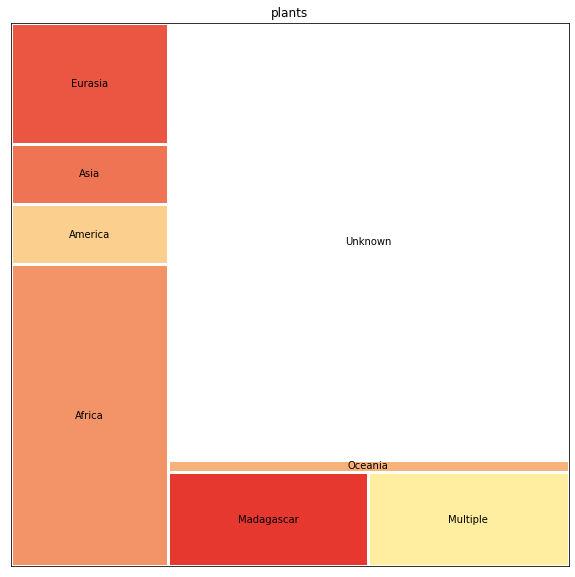

Multiple 42.30769230769231 33.333333333333336 57.692307692307686 43.333333333333336


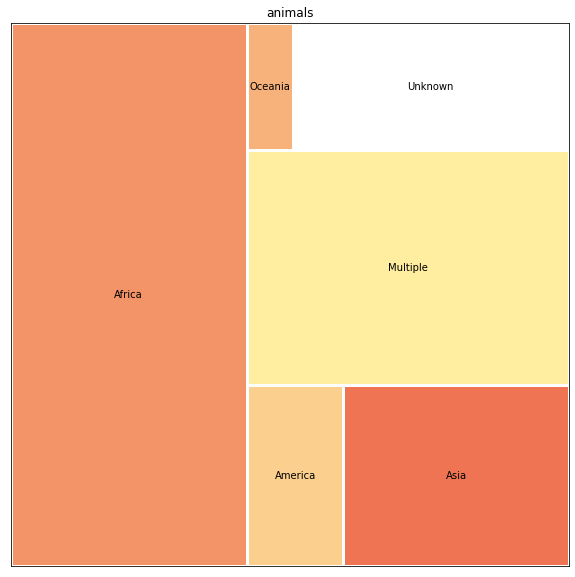

In [186]:
import squarify

# For plants
plants = ['Ferns','Flowering plants']
animals = ['Arthopods', 'Bony fishes', 'Reptiles', 'Amphibians', 'Flatworms', 'Mammals', 'Birds', 'Molluscs']

# treemap for number of records per origin
plantdf = extant[extant['common_name'].isin(plants)]
animalsdf = extant[extant['common_name'].isin(animals)]

for dataframe in [plantdf,animalsdf]:
    extantorigin = dataframe.groupby(by = 'sister_lineage_plot')['index'].count().reset_index()
    extantorigin['color'] = extantorigin['sister_lineage_plot'].map(orcoldict)
    extantorigin.sort_values(by = 'index', ascending = False).reset_index()
    
    fig,ax = plt.subplots(figsize = (10,10), facecolor = 'w')
    plt.title('plants' if dataframe is plantdf else 'animals')
    ax = squarify.plot(sizes = extantorigin['index'],label = extantorigin['sister_lineage_plot'], color = extantorigin['color'], pad = 0, bar_kwargs=dict(linewidth=3, edgecolor='w'))
    
    for rect,text in zip(ax.patches, ax.texts):
        x, y, w, h = rect.get_x(), rect.get_y(), rect.get_width(), rect.get_height()
        t = text.get_text()
        if t == 'Multiple':
            print(t,x,y,w,h)
    
    # [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_yticks([])
    ax.set_xticks([])
    plt.savefig('./%s_origins.svg'%('plants' if dataframe is plantdf else 'animals'), dpi = 300)
    plt.show()

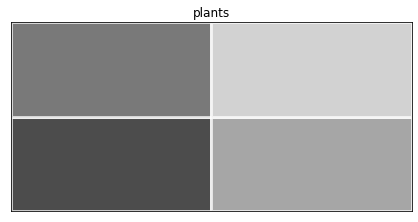

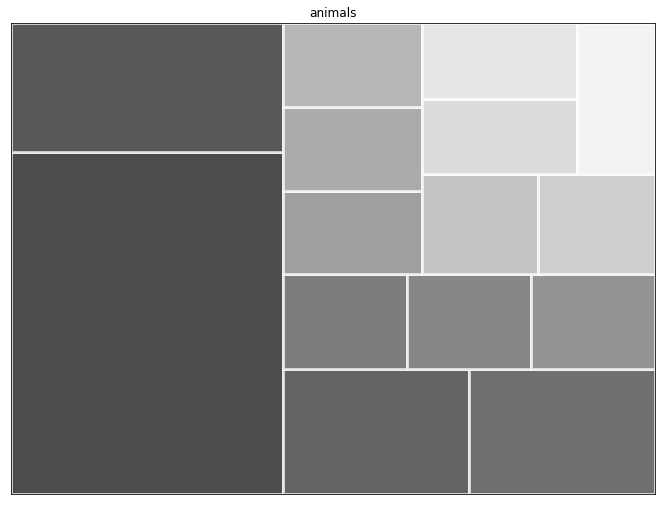

In [185]:
for dataframe in [plantdf,animalsdf]:
    extantmulti = dataframe[dataframe['sister_lineage_plot'] == 'Multiple']
    multipleorigin = extantmulti.groupby(by = 'sister_lineage_list')['index'].count().reset_index()
    multipleorigin = multipleorigin.sort_values(by = 'index', ascending = False).reset_index()

    multiplecol = colourDict(multipleorigin['sister_lineage_list'].unique(),cmap=mpl.cm.gray,sort=False)
    multiplecol['color'] = multipleorigin['sister_lineage_list'].map(multiplecol)

    normx = 35.9375 if dataframe is plantdf else 57.692307692307686
    normy = 17.391304347826086 if dataframe is plantdf else 43.333333333333336
    
    fig,ax = plt.subplots(figsize = (normx*0.2,normy*0.2), facecolor = 'w')
    plt.title('plants' if dataframe is plantdf else 'animals')
    
    squarify.plot(sizes = multipleorigin['index'], color = multiplecol['color'], alpha = 0.7, ax = ax, pad = 0, bar_kwargs=dict(linewidth=3, edgecolor='w')) # label = multipleorigin['sister_lineage_list']
    ax.set_yticks([])
    ax.set_xticks([])
    plt.savefig('./%s_origins_multiple.svg'%('plants' if dataframe is plantdf else 'animals'), dpi = 300)
    plt.show()

In [ ]:
from matplotlib_venn import venn3, venn3_circles

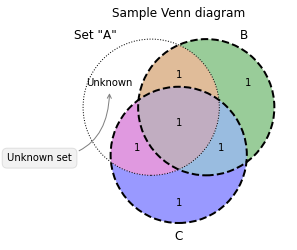

In [30]:
plt.figure(figsize=(4,4))
v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels = ('A', 'B', 'C'))
v.get_patch_by_id('100').set_alpha(1.0)
v.get_patch_by_id('100').set_color('white')
v.get_label_by_id('100').set_text('Unknown')
v.get_label_by_id('A').set_text('Set "A"')
c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='dashed')
c[0].set_lw(1.0)
c[0].set_ls('dotted')
plt.title("Sample Venn diagram")
plt.annotate('Unknown set', xy=v.get_label_by_id('100').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.show()

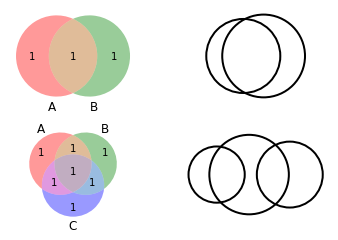

In [31]:
from matplotlib_venn import venn2, venn2_circles
figure, axes = plt.subplots(2, 2)
venn2(subsets={'10': 1, '01': 1, '11': 1}, set_labels = ('A', 'B'), ax=axes[0][0])
venn2_circles((1, 2, 3), ax=axes[0][1])
venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels = ('A', 'B', 'C'), ax=axes[1][0])
venn3_circles({'001': 10, '100': 20, '010': 21, '110': 13, '011': 14}, ax=axes[1][1])
plt.show()

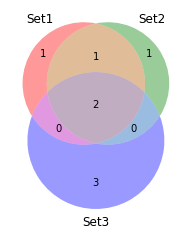

In [32]:
set1 = set(['A', 'B', 'C', 'D'])
set2 = set(['B', 'C', 'D', 'E'])
set3 = set(['C', 'D',' E', 'F', 'G'])

venn3([set1, set2, set3], ('Set1', 'Set2', 'Set3'))
plt.show()

plants


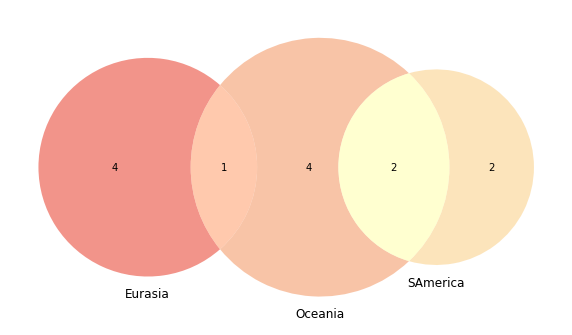

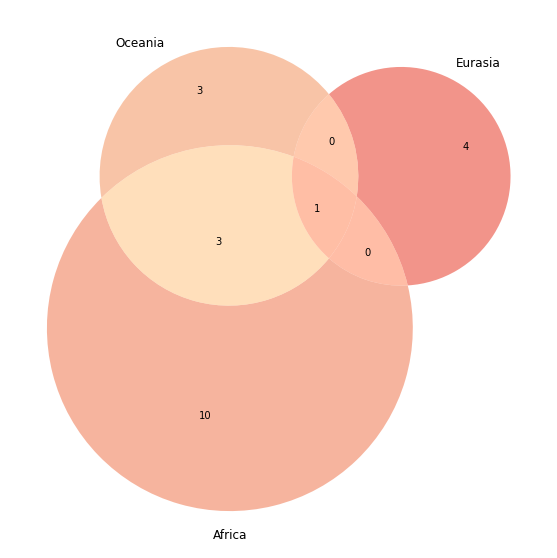

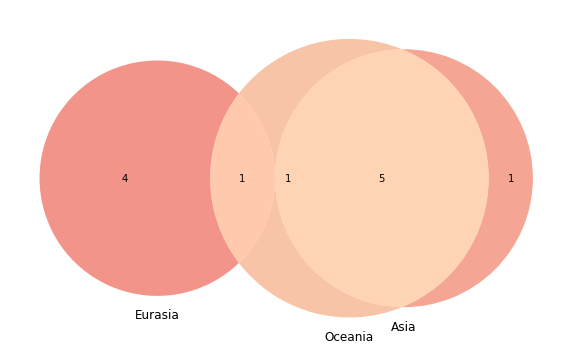

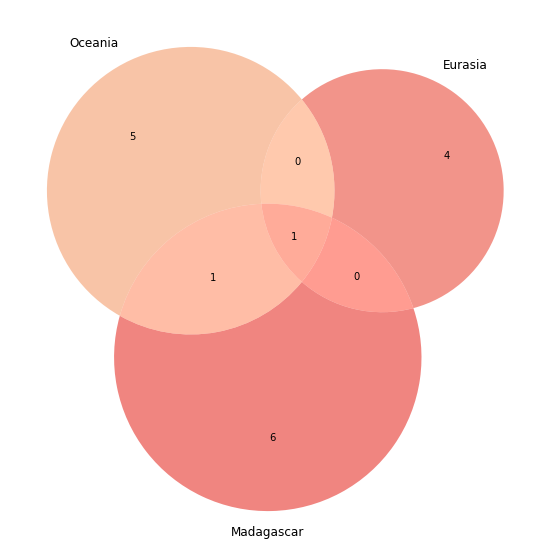

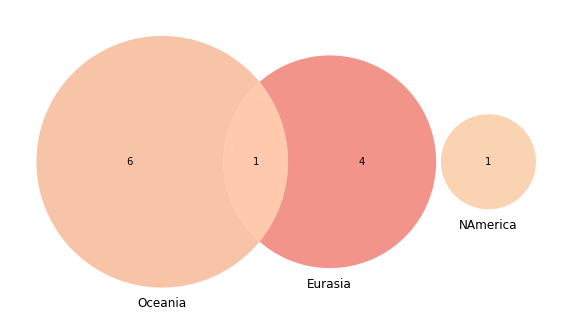

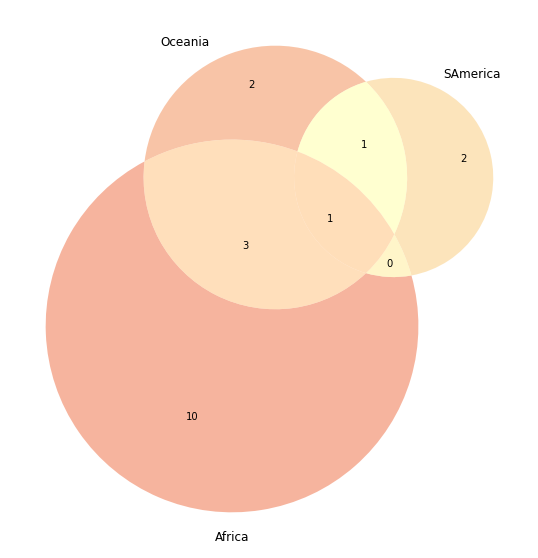

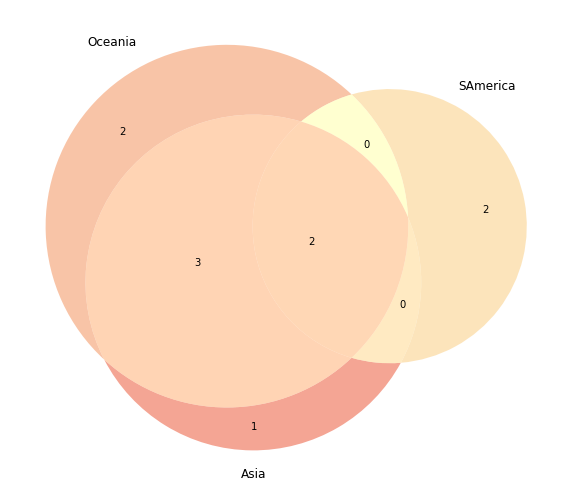

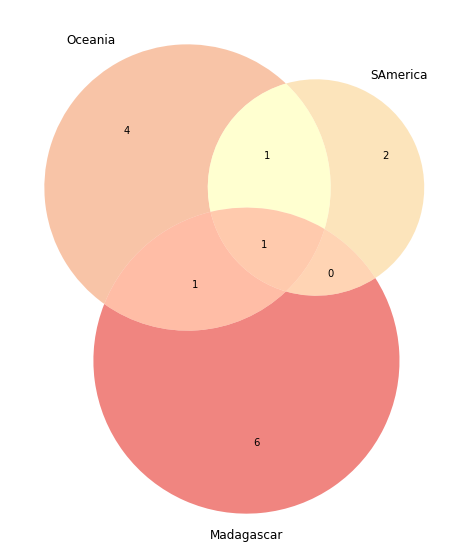

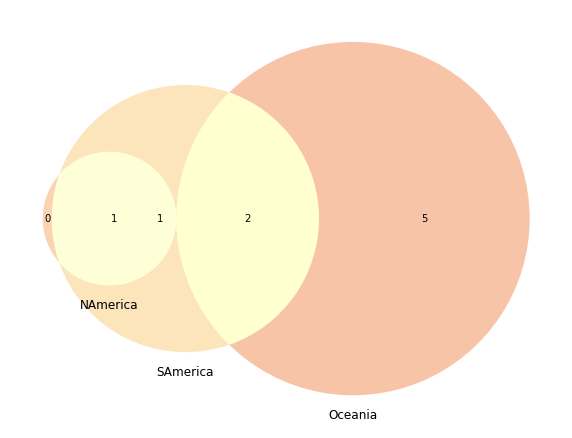

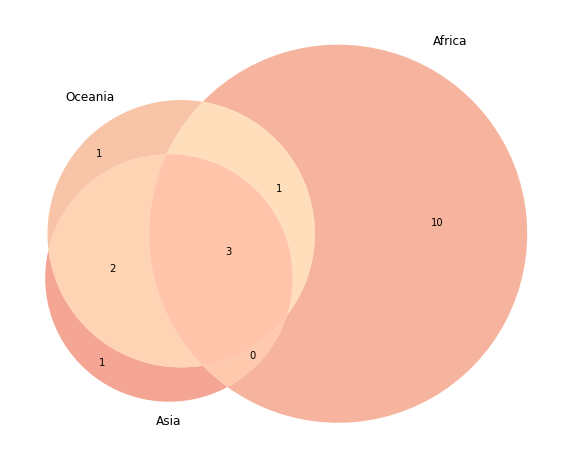

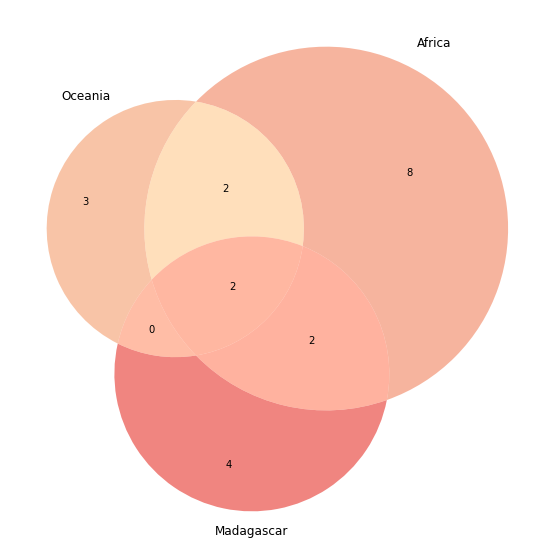

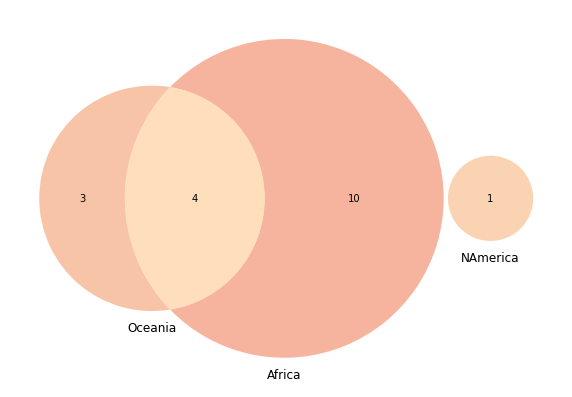

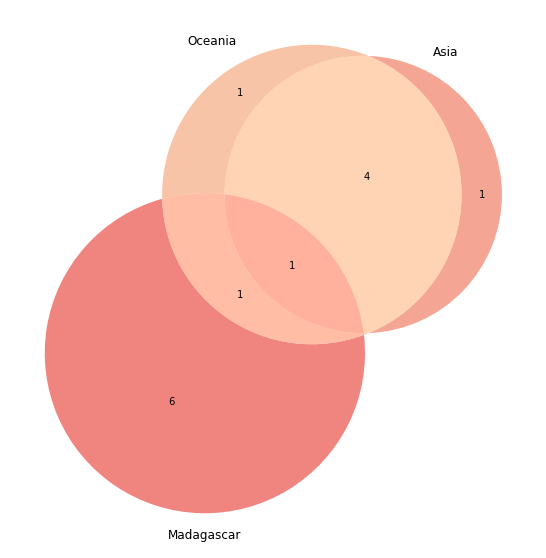

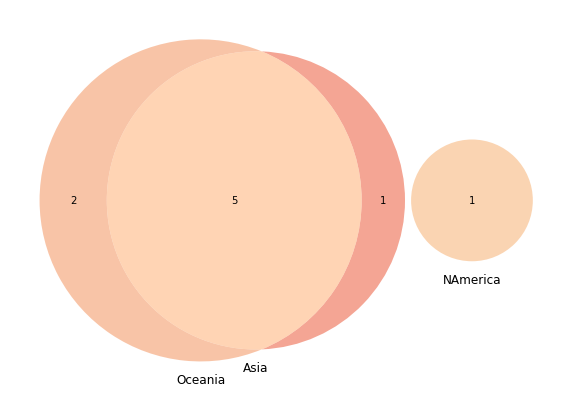

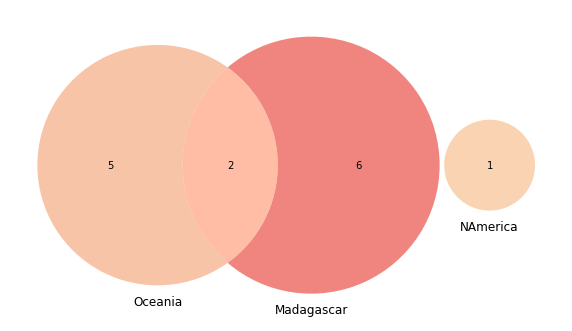

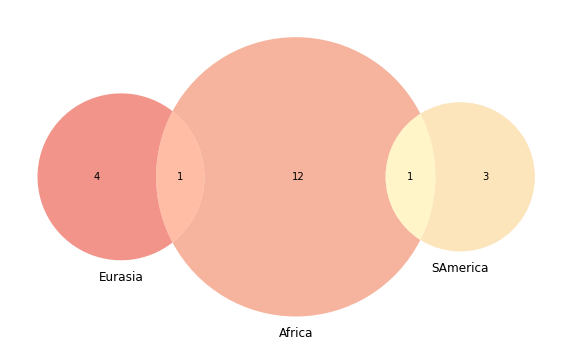

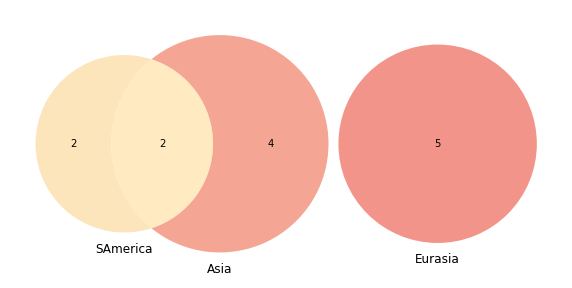

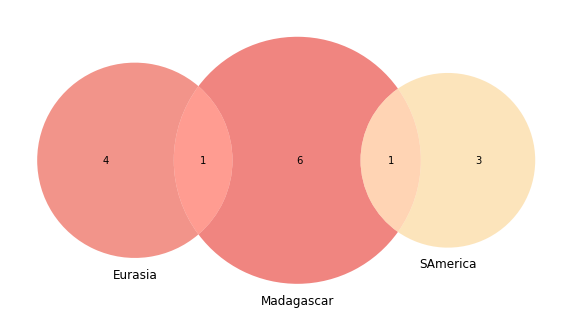

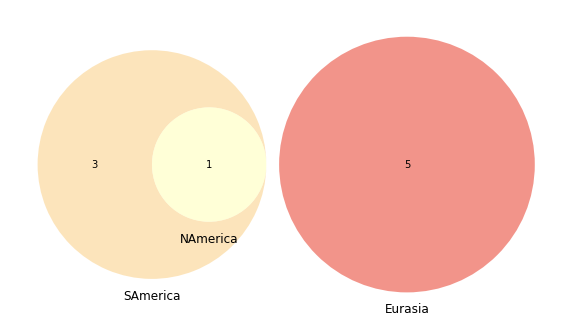

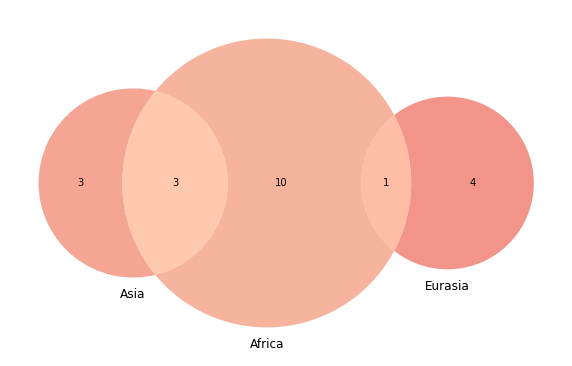

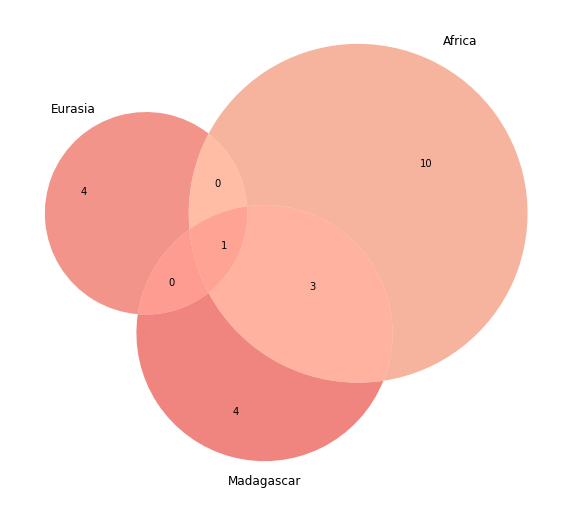

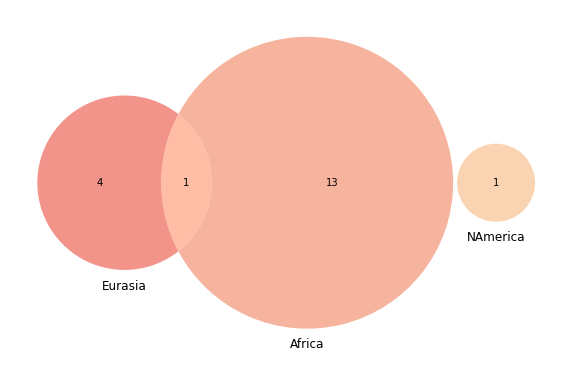

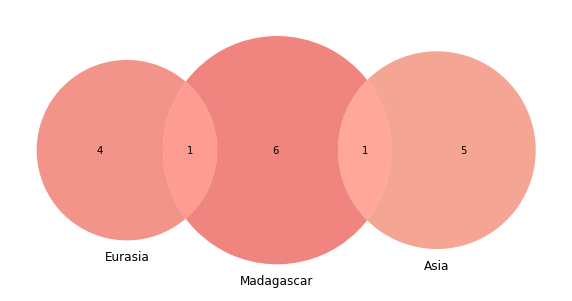

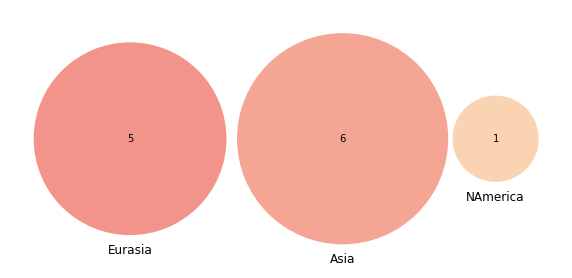

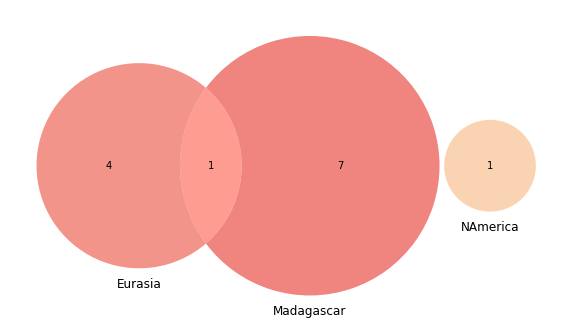

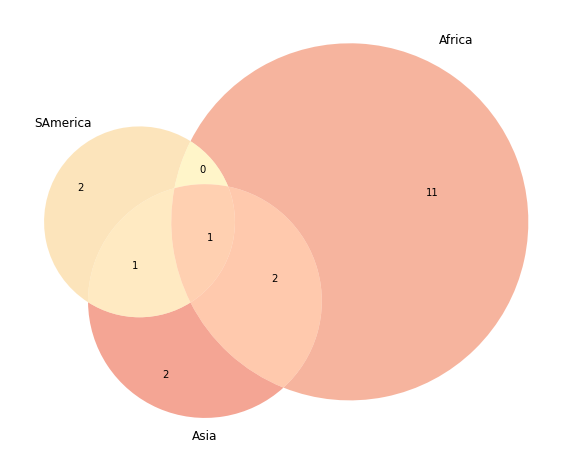

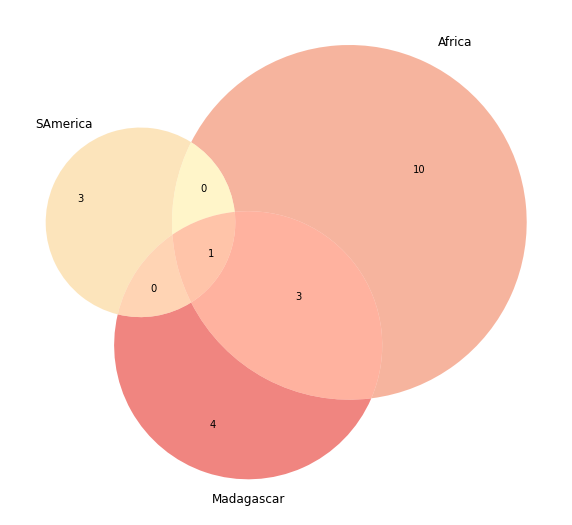

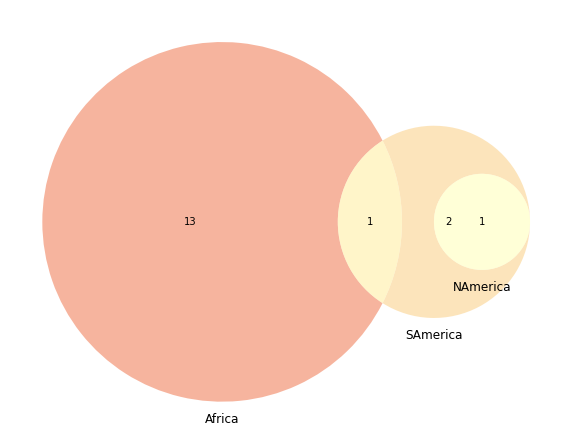

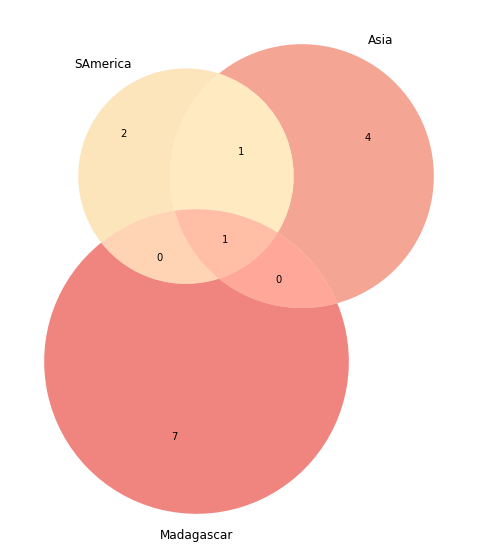

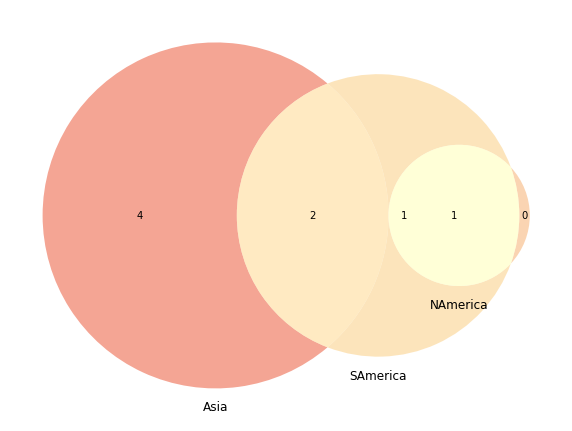

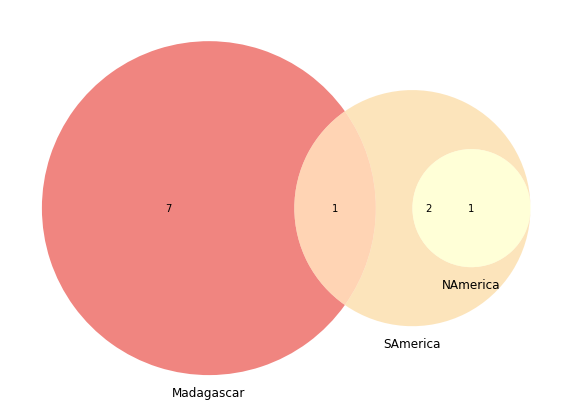

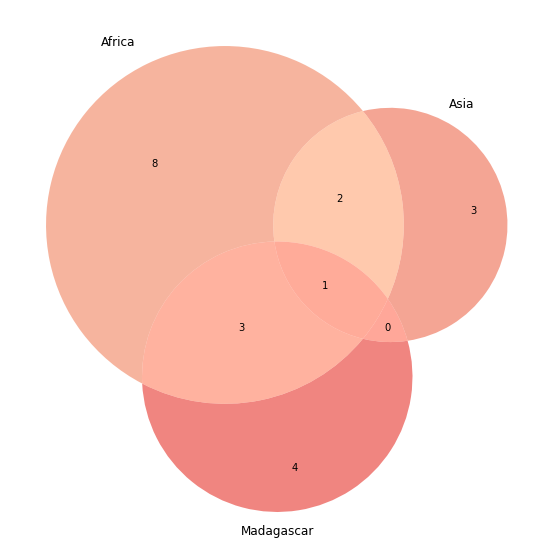

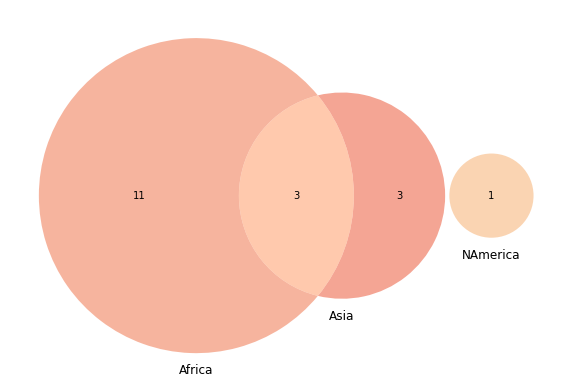

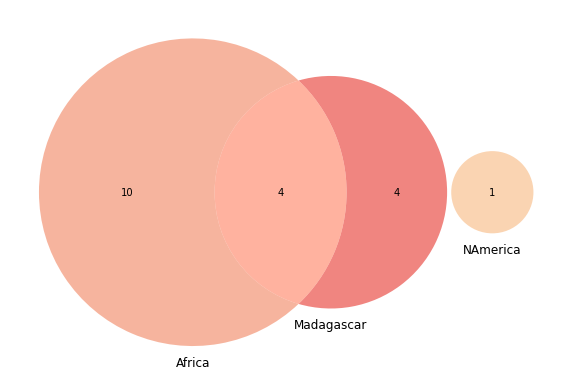

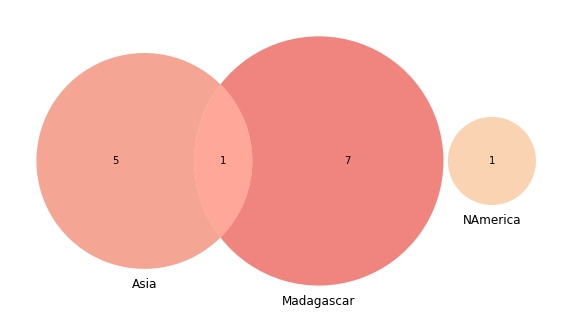

animals


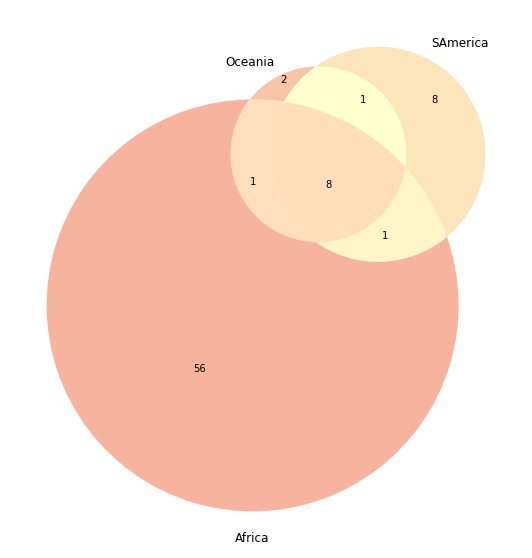

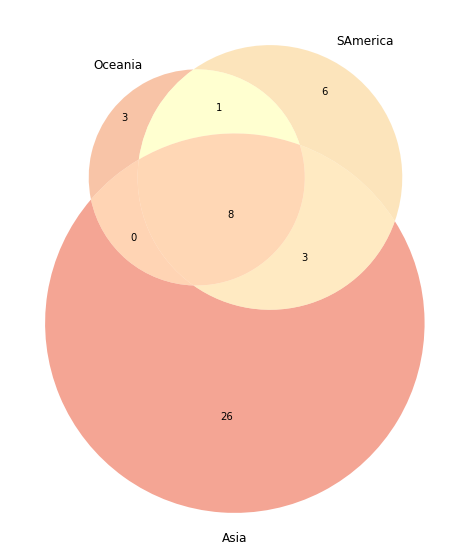

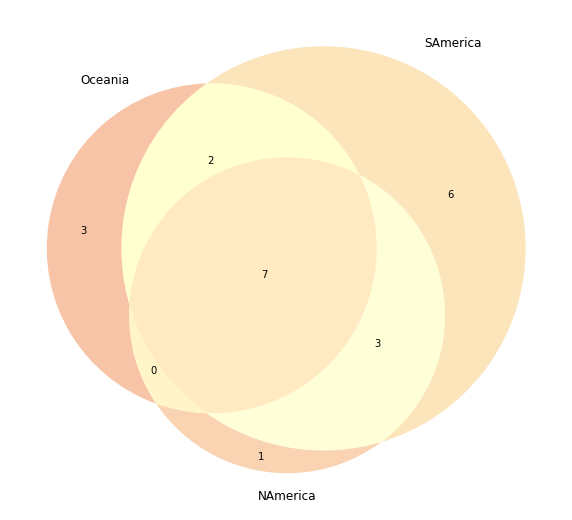

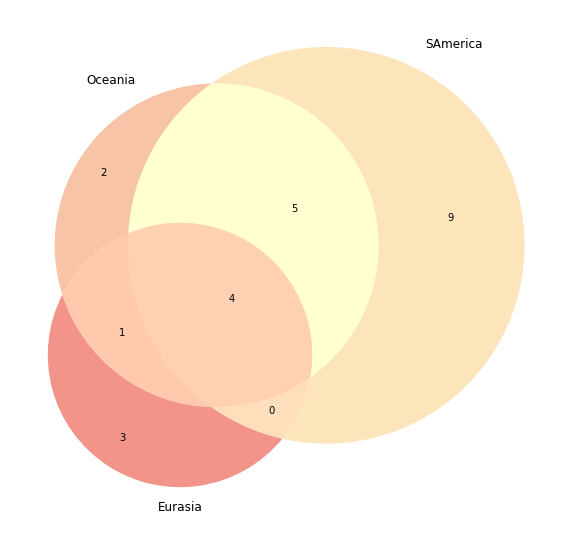

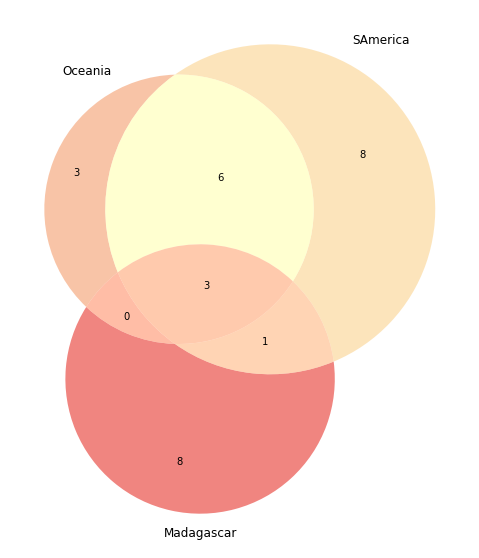

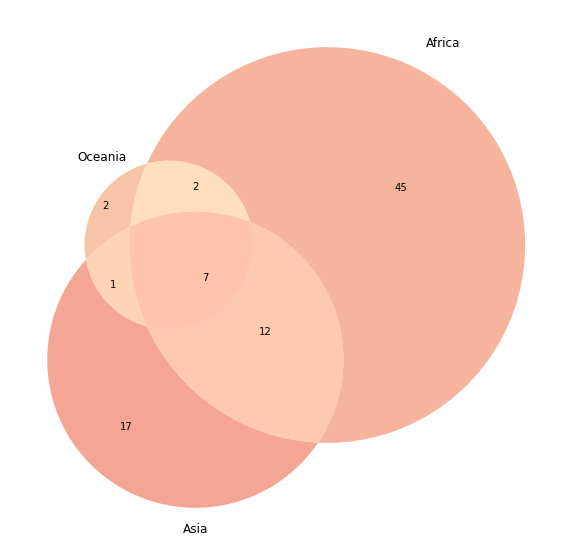

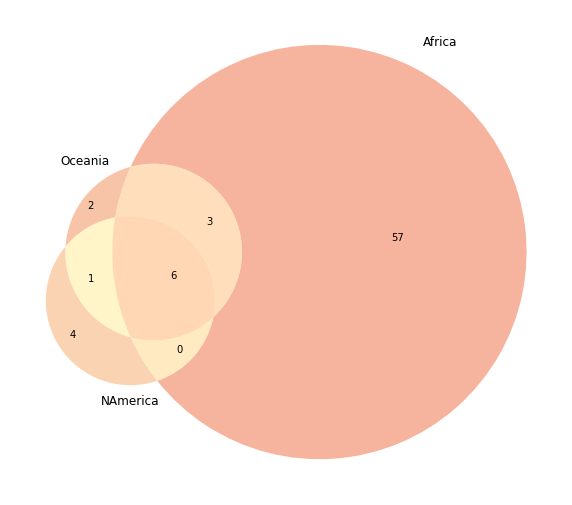

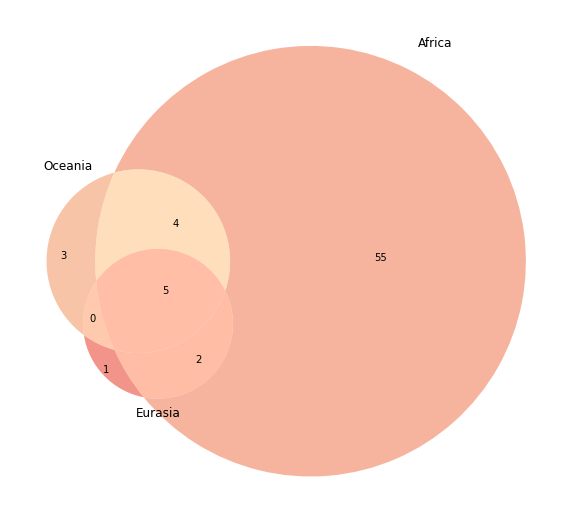

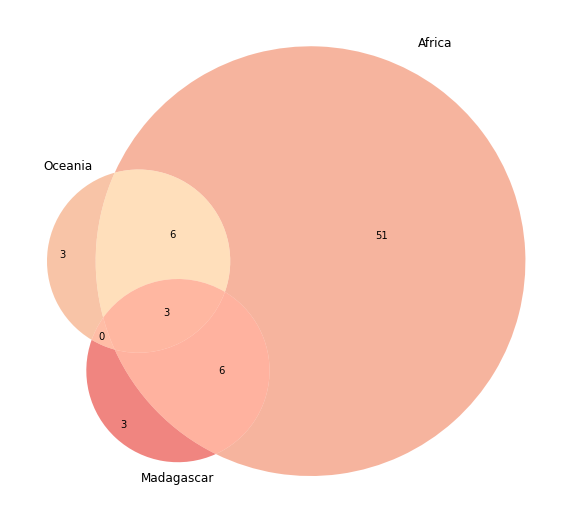

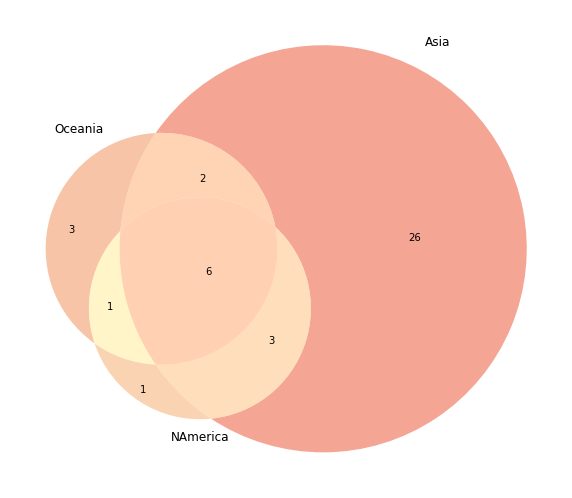

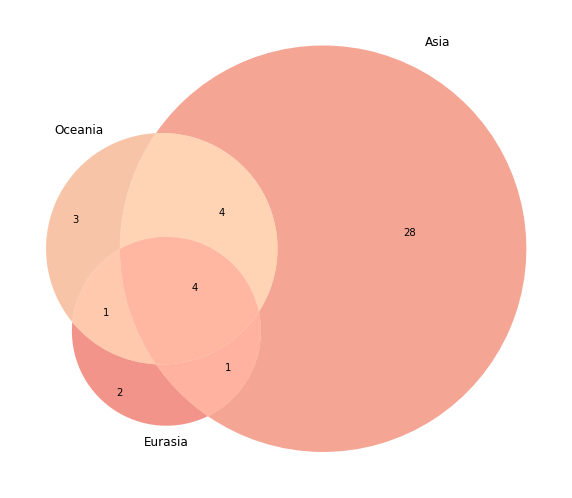

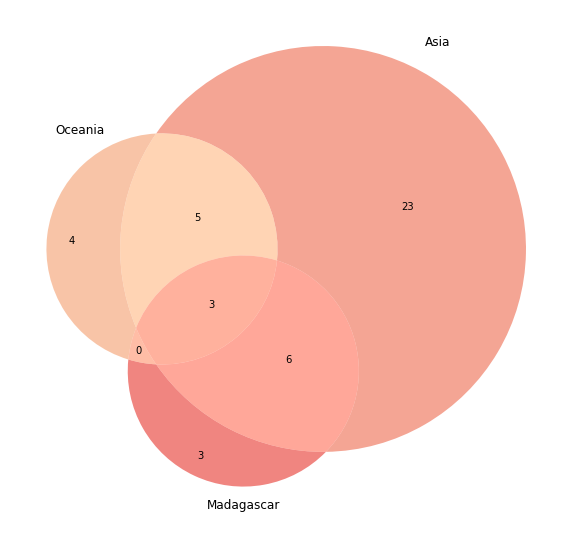

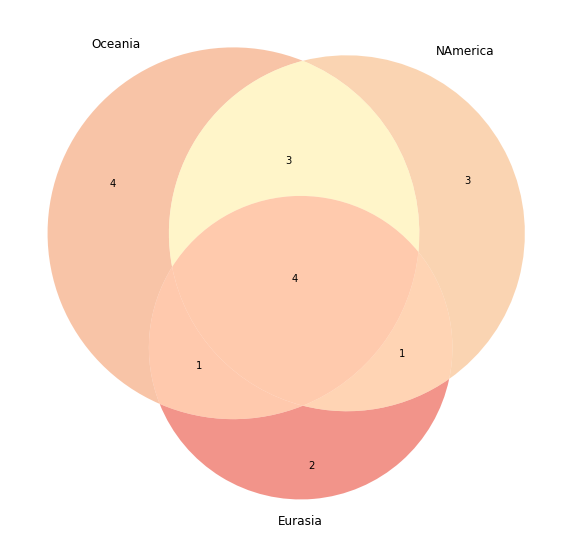

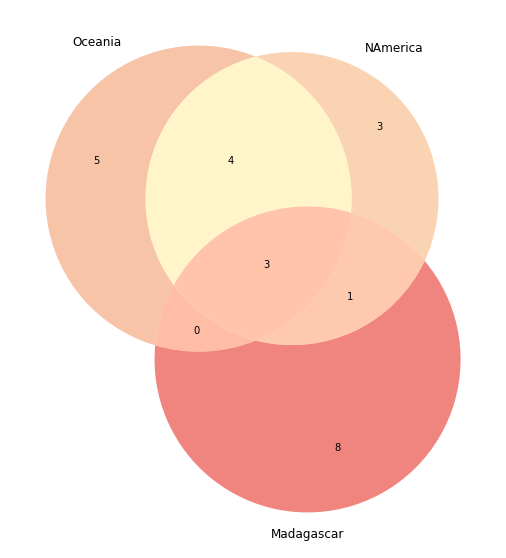

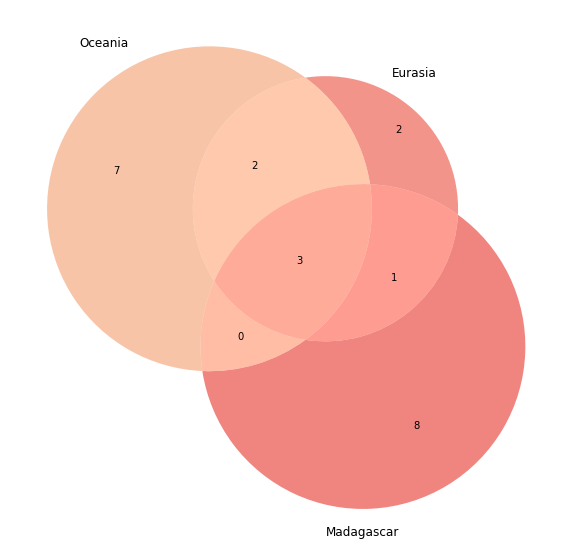

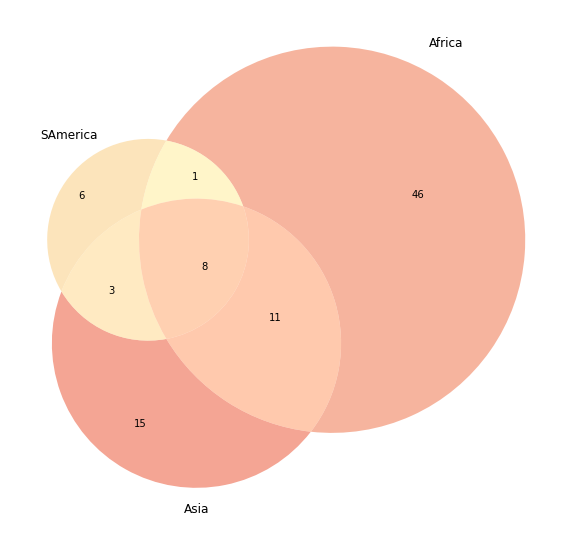

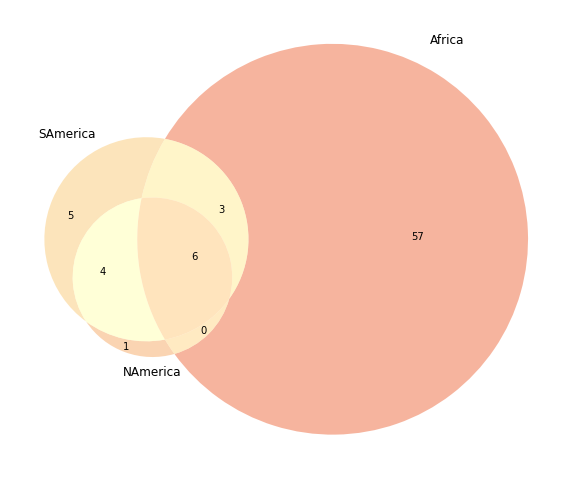

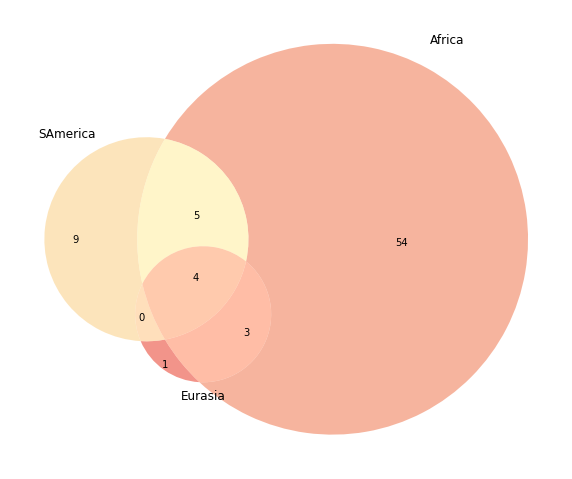

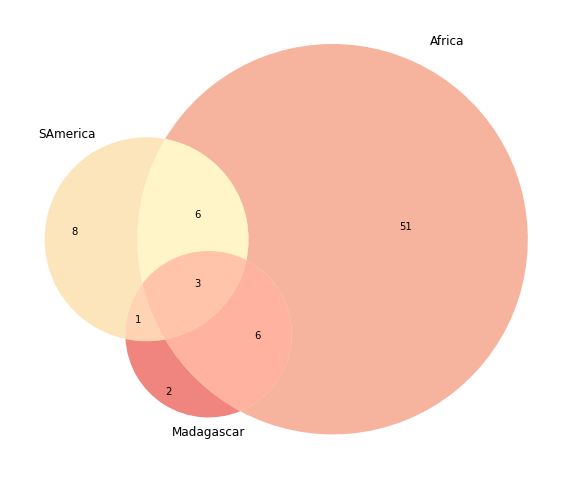

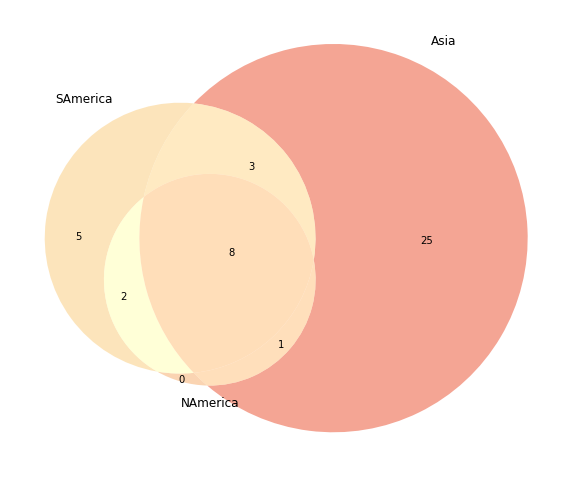

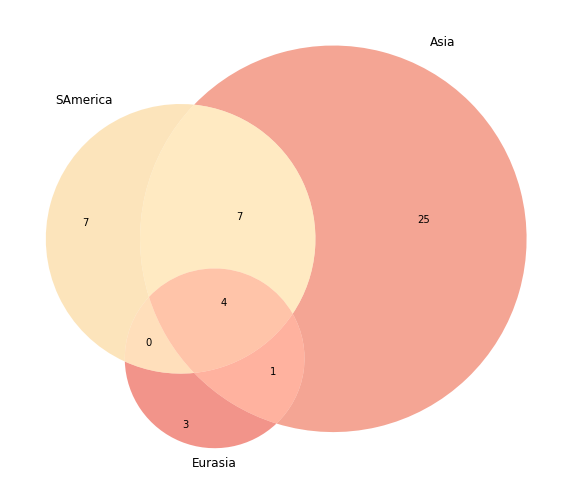

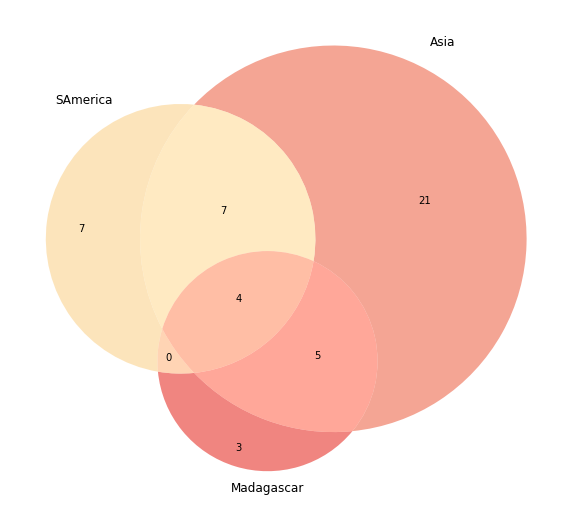

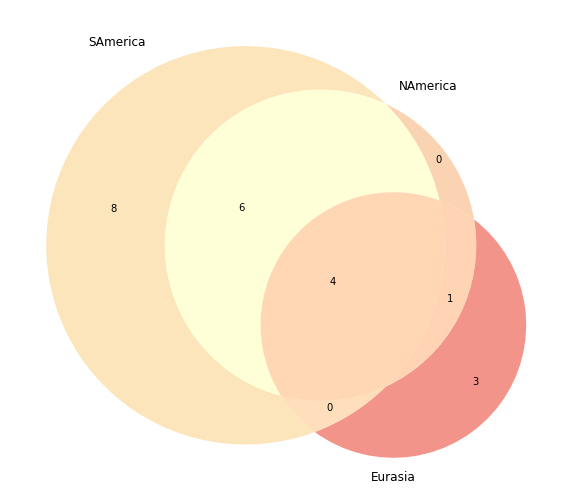

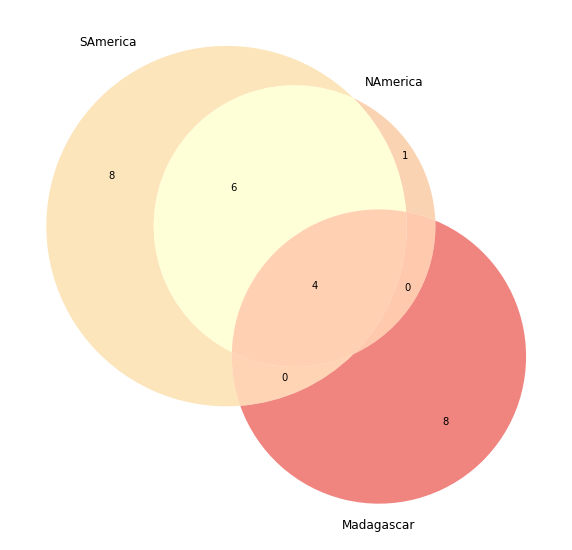

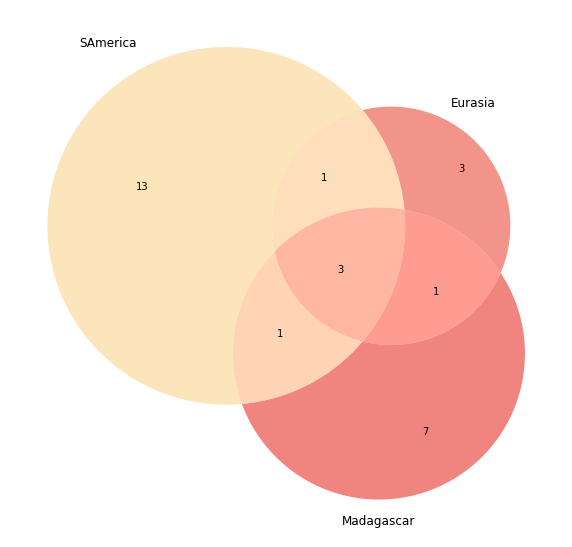

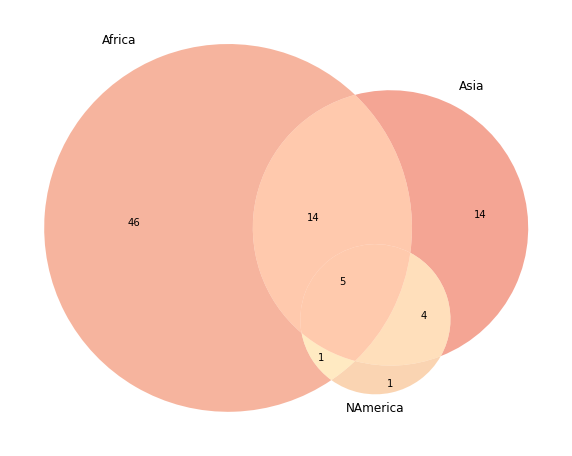

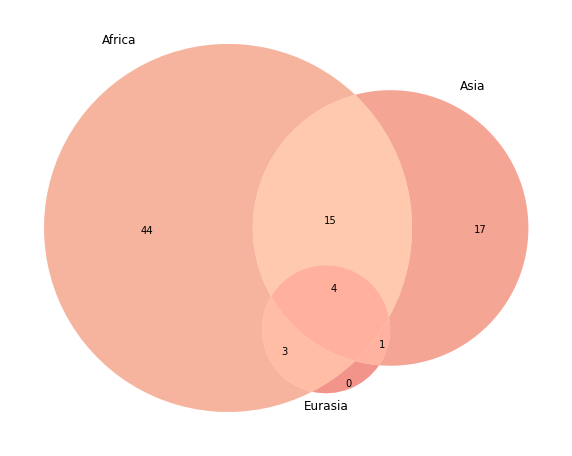

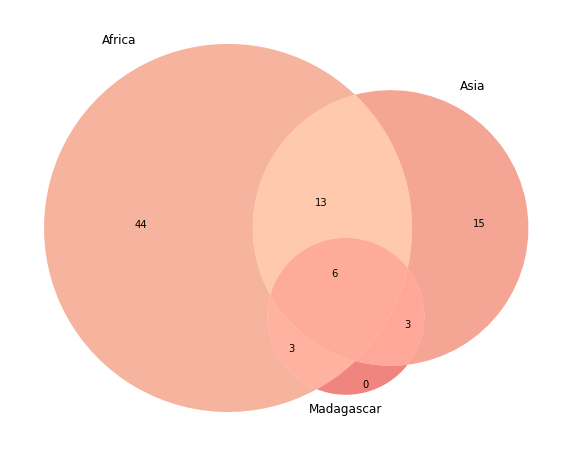

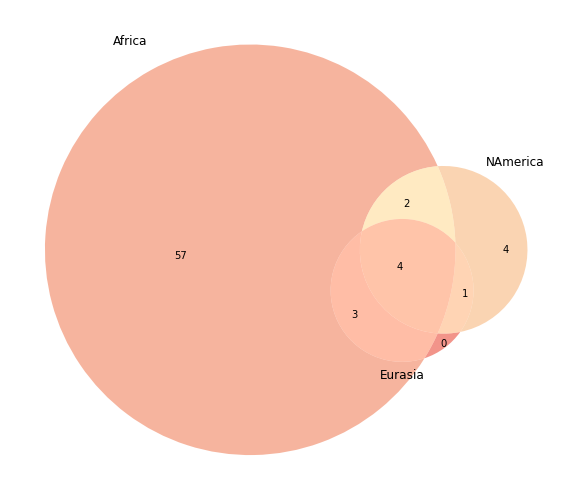

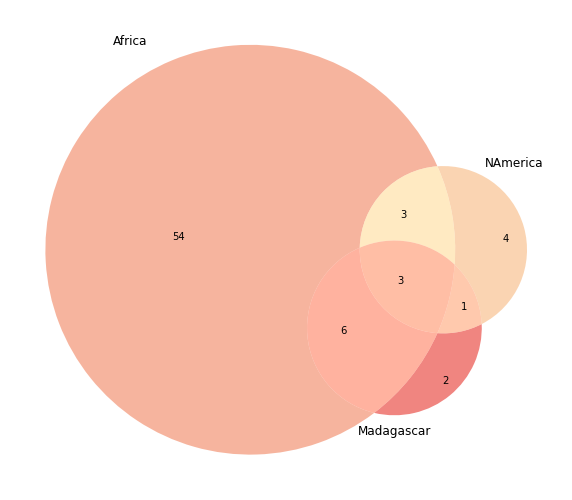

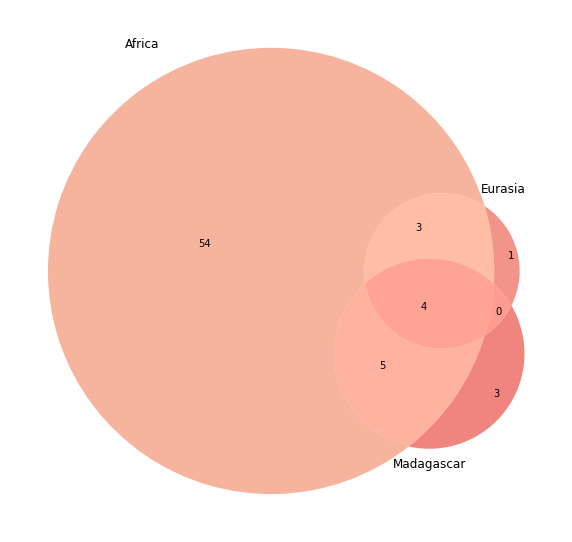

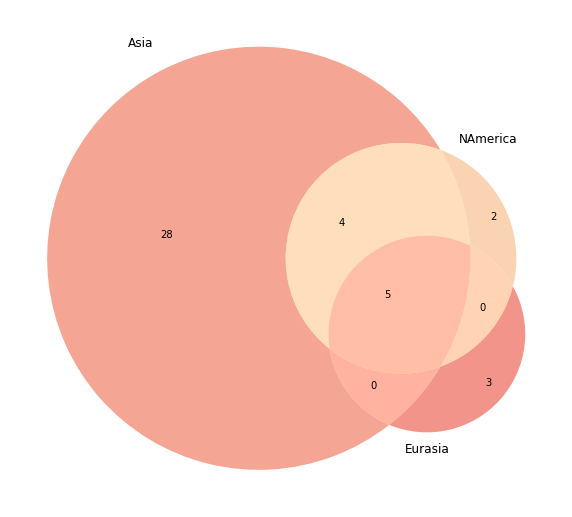

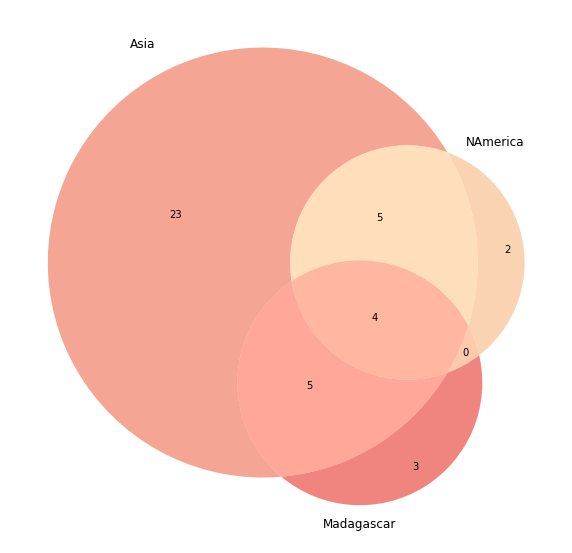

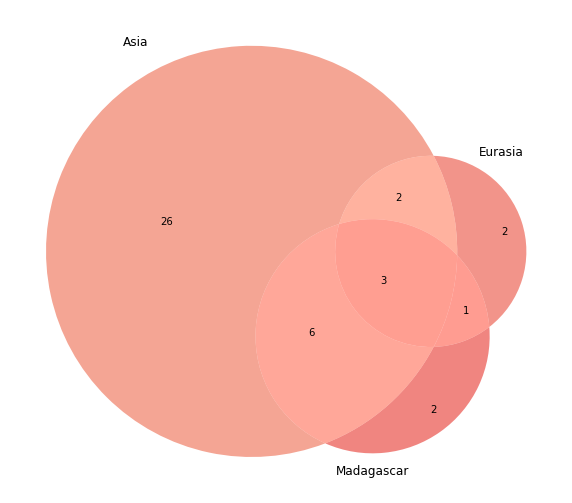

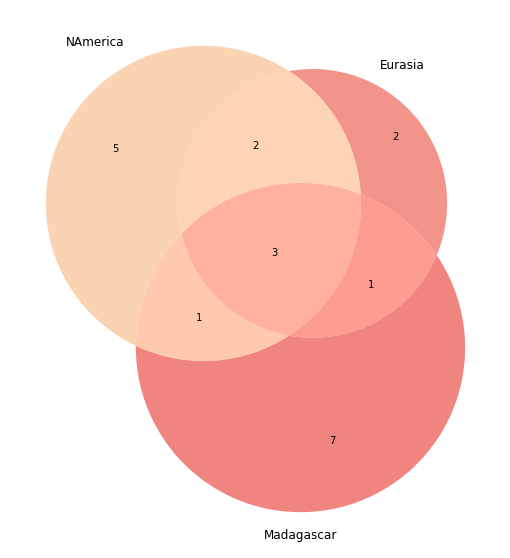

In [147]:
from venn import venn
from venn import pseudovenn
from itertools import combinations

# For plants
plants = ['Ferns','Flowering plants']
animals = ['Arthopods', 'Bony fishes', 'Reptiles', 'Amphibians', 'Flatworms', 'Mammals', 'Birds', 'Molluscs']

# treemap for number of records per origin
plantdf = extant[extant['common_name'].isin(plants)]
animalsdf = extant[extant['common_name'].isin(animals)]

# animalsdf.groupby('sister_lineage_list')['index'].count().sort_values('index', ascending = False)
for dataframe in [plantdf,animalsdf]:
    print('plants' if dataframe is plantdf else 'animals')
    sites_list=[]
    for row in dataframe.itertuples():
        for site in row.sister_lineage_list.split('_'):
            if site not in sites_list and site not in ['Unknown']:
                sites_list.append(site)
    sites_list

#     venn_dict={}
    for comb in combinations(sites_list,3):
#         print(comb)
        setlist = []
        labellist = []
        colorlist = []
        for site in comb:
            templist = []
            for row in dataframe.itertuples():
                if site in row.sister_lineage_list.split('_'):
                    templist.append(row.index)
    # #                 print(site, row.index)
    #         venn_dict[site] = set(templist)
            setlist.append(set(templist))
            labellist.append(site)
            colorlist.append(orlistcoldict[site])
    #     print(venn_dict)
    
        fig,ax = plt.subplots(figsize = (10,10))
    #     pseudovenn(venn_dict, cmap = mpl.cm.viridis, alpha = 0.5, ax = ax)
    # #     venn(venn_dict, cmap = mpl.cm.viridis, alpha = 0.5, ax = ax,)
        venn3(setlist,labellist,colorlist,alpha = 0.6)
        plt.savefig('./%s_%s-%s-%s.svg'%('plants' if dataframe is plantdf else 'animals',comb[0],comb[1],comb[2]))
        plt.show()

plants


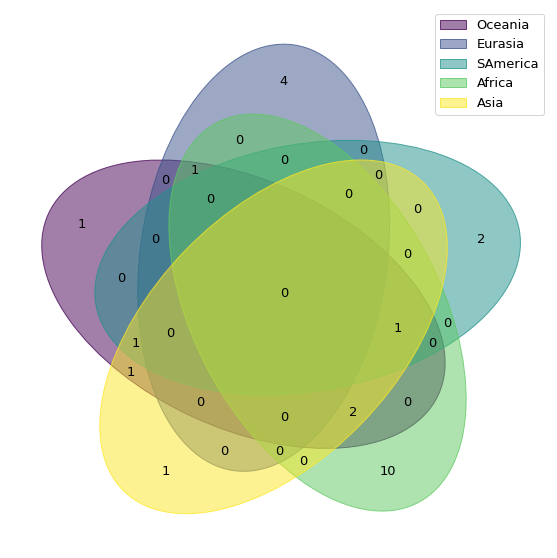

animals


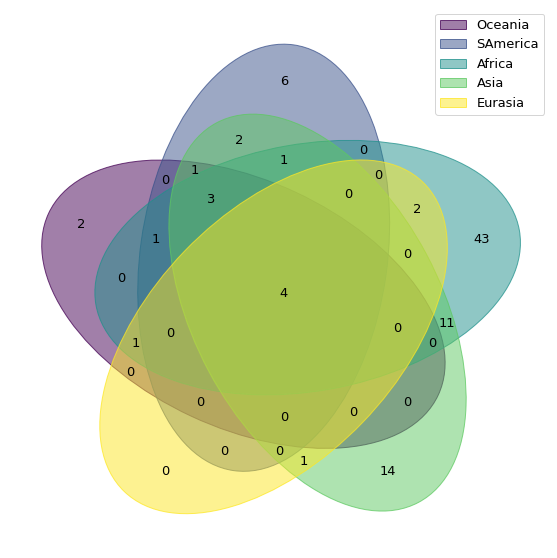

In [201]:
# animalsdf.groupby('sister_lineage_list')['index'].count().sort_values('index', ascending = False)
for dataframe in [plantdf,animalsdf]:
    print('plants' if dataframe is plantdf else 'animals')
    sites_list=[]
    for row in dataframe.itertuples():
        for site in row.sister_lineage_list.split('_'):
            if site not in sites_list and site not in ['Unknown']:
                sites_list.append(site)
    sites_list

    venn_dict={}
    for site in sites_list:
        if site not in ['Unknown','Madagascar','NAmerica']:
            templist = []
            for row in dataframe.itertuples():
                if site in row.sister_lineage_list.split('_'):
                    templist.append(row.index)
    # #                 print(site, row.index)
            venn_dict[site] = set(templist)
#     print(venn_dict)
    
    fig,ax = plt.subplots(figsize = (10,10))
#     pseudovenn(venn_dict, cmap = mpl.cm.viridis, alpha = 0.5, ax = ax)
    venn(venn_dict, cmap = mpl.cm.viridis, alpha = 0.5, ax = ax,)
#         venn3(setlist,labellist,colorlist,alpha = 0.6)
#         plt.savefig('./fullvenns_%s_%s-%s-%s.svg'%('plants' if dataframe is plantdf else 'animals',comb[0],comb[1],comb[2]))
    plt.show()

In [ ]:
# animalsdf.groupby('sister_lineage_list')['index'].count().sort_values('index', ascending = False)
for dataframe in [plantdf,animalsdf]:
    print('plants' if dataframe is plantdf else 'animals')
    sites_list=[]
    for row in dataframe.itertuples():
        for site in row.sister_lineage_list.split('_'):
            if site not in sites_list and site not in ['Unknown']:
                sites_list.append(site)
    sites_list

    venn_dict={}
    for site in sites_list:
        templist = []
        for row in dataframe.itertuples():
            if site in row.sister_lineage_list.split('_'):
                templist.append(row.index)
        venn_dict[site] = set(templist)
    
    fig,ax = plt.subplots(figsize = (10,10))

    plt.show()

Time periods Climate  
Late Pleistocene : 36000-20000 Relatively wet and humid period  
Late Pleistocene : 20000- 15000 Drier conditions  
Late Pleistocene : 15000- early Holocene Warm and humid period # late pleistocene is 0.129.. is this 0.129 to 0.015? what is early holocene? 0.0117 to 0.0082?  
Mid-Holocene Wetter conditions is this Northgrippian?? 0.008 to 0.0042?  
Late Holocene : 3500- to the present time Increasing occurrence of drought  

Time periods Vegetation  
Late Pleistocene : 20000- 15000 Mosaic landscape  
Late Pleistocene : 15000- early Holocene Mosaic landscape  
Mid-Holocene Mosaic landscape  
1200-950 BP towards the present time Opening of ecosystem  

In [182]:
# climate_periods={'wet_humid':[0.020,0.036],
#                 'drier':[0.015,0.020],
#                 'warm_humid':[0.0082,0.015],
#                 'wetter':[0.0042,0.008],
#                 'more_droughts':[0,0.0035]}
climate_periods=[(0.020,0.036),(0.015,0.020),(0.0082,0.015),(0.0042,0.008),(0,0.0035)]

# vegetation_periods={'mosaic_landscape':[0.015,0.020],
#                    'early_mosaic_lands':[0.0082,0.015],
#                    'mosaic':[0.0042,0.008],
#                    'opening_ecosystem':[0,0.0012]}
vegetation_periods=[(0.015,0.020),(0.0082,0.015),(0.0042,0.008),(0,0.0012)]

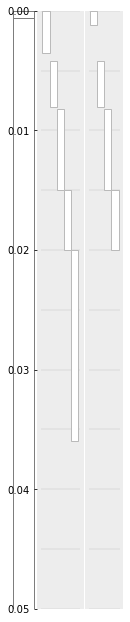

In [252]:
plt.figure(figsize=(2,11),facecolor='w')
G = gridspec.GridSpec(1,3,hspace=0.0,wspace=0.03,width_ratios=[0.2,0.4,0.32]) #,0.4,0.4,0.1])

darkcol = '#a8a8a8'
lightcol = '#d9d9d9'

ax1=plt.subplot(G[0,0])
ax1.set_ylim(1,0)#;plt.gca().invert_yaxis()
epochbase = 0
for key,value in geol_time_dict.items():
    if key in ['Holocene','Pleistocene','Pliocene']:
        ax1.bar(x = 0, height = value[1] - value[0], width = 2, bottom = epochbase, align = 'edge', edgecolor = '#7d7d7d', lw = 1, alpha = 1,
                   color = 'none', zorder = 100)
        epochbase += value[1] - value[0]
        
# ------------------------------------ climate periods
ax2=plt.subplot(G[0,1])
ax2.set_ylim(0.05,0)#;plt.gca().invert_yaxis()
addvolcanos(climate_periods[::-1], holocene = '', offset = 0.05, color = 'w', ax = ax2, levels = len(climate_periods))
addshade(shades, holocene = '', x = 0, lines = False, offset = 1, lw = 0.5, ax = ax2, darkcol = darkcol, lightcol = lightcol)
ax2.hlines(y = [mya for mya in np.linspace(0,0.05,11)], xmin = ax2.get_xlim()[0], xmax = ax2.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)

# ------------------------------------ vegetation periods
ax3=plt.subplot(G[0,2])
ax3.set_ylim(0.05,0)#;plt.gca().invert_yaxis()
addvolcanos(vegetation_periods[::-1], holocene = '', offset = 0.05, color = 'w', ax = ax3, levels = len(vegetation_periods))
addshade(shades, holocene = '', x = 0, lines = False, offset = 1, lw = 0.5, ax = ax3, darkcol = darkcol, lightcol = lightcol)
ax3.hlines(y = [mya for mya in np.linspace(0,0.05,11)], xmin = ax3.get_xlim()[0], xmax = ax3.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)


# # ------------------------------------ volcanos
# ax5=plt.subplot(G[0,3])
# ax5.set_ylim(0.05,0);plt.gca().invert_yaxis()
# ax5.set_xlim(-2,2)
# addvolcanos(volcanism, holocene = '', offset = 1, color = 'w', ax = ax5, levels = len(volcanism))
# addshade(shades, holocene = '', x = 0, lines = False, offset = 1, lw = 0.5, ax = ax5, darkcol = darkcol, lightcol = lightcol)
# ax5.hlines(y = [mya for mya in np.linspace(0,0.05,20)], xmin = ax5.get_xlim()[0], xmax = ax5.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)

# # ------------------------------------ landscape
# ax6=plt.subplot(G[0,4])
# ax6.set_ylim(0.05,0);plt.gca().invert_yaxis()
# ax6.set_xlim(-2,4)
# addvolcanos(landscape, holocene = '', offset = 1, color = 'w', ax = ax6, levels = len(landscape))
# addshade(shades, holocene = '', x = 0, lines = False, offset = 1, lw = 0.5, ax = ax6, darkcol = darkcol, lightcol = lightcol)
# ax6.hlines(y = [mya for mya in np.linspace(0,0.05,20)], xmin = ax6.get_xlim()[0], xmax = ax6.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)

# # ------------------------------------ shades early cret to pleis
# ax7=plt.subplot(G[0,5])
# ax7.set_ylim(0.05,0);plt.gca().invert_yaxis()
# ax7.set_xlim(-0.5,len(shades))
# addshade(shades, holocene = '', x = 0, lines = True, offset = 1, lw = 2, ax = ax7, darkcol = darkcol, lightcol = lightcol)
# ax7.hlines(y = [mya for mya in np.linspace(0,0.05,20)], xmin = ax7.get_xlim()[0], xmax = ax7.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7]:
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_xticks([])
    if ax != ax2:
        ax.set_yticks([])
    if ax != ax1:
        lineevents(pointevents,holocene = False, lw = 2, ax = ax, color = '#bababa', ls = 'dotted')
plt.savefig('./Fig2_holo_20210314_2.svg', dpi=300)
plt.show()
# no gray, make it white with dark background if you use the shades
# ax3.set_ylim(3,0);plt.gca().invert_yaxis()


In [6]:
# get table. Row is unique taxon_name. Create column of elariest_seen and latest_seen across all records with that taxon name
fosbylineage=fossil.groupby(by=['class','taxon_name'])['occurrence_no'].count().reset_index()
fosbylineage['early_age']=fossil.groupby(by=['class','taxon_name'])['early_age'].max().reset_index()['early_age'] # maximum early age as we go back in time with higher being oldest
fosbylineage['late_age']=fossil.groupby(by=['class','taxon_name'])['late_age'].min().reset_index()['late_age'] # minimum late age as we go ahead in time with higher being oldest
fosbylineage

class                            taxon_name  occurrence_no  \
0    Actinopterygii                        Amiidae indet.              1   
1    Actinopterygii                            Cybium sp.              1   
2    Actinopterygii                         Lepidotes sp.              1   
3    Actinopterygii                       Lepisosteus sp.              2   
4    Actinopterygii                  Pycnodontidae indet.              1   
..              ...                                   ...            ...   
147      Saurischia                 Titanosauridae indet.              4   
148      Saurischia         Titanosaurus madagascariensis              1   
149      Saurischia  Titanosaurus madagascariensis n. sp.              2   
150      Saurischia                       Vahiny depereti              1   
151      Saurischia        Vahiny n. gen. depereti n. sp.              1   

     early_age  late_age  
0        89.80    83.600  
1        11.62     7.246  
2        72.10    66.000  
3        72.10    66.000  
4        72.10    66.000  
..         ...       ...  
147      72.10    66.000  
148      72.10    66.000  
149      72.10    66.000  
150      72.10    66.000  
151      72.10    66.000  

[152 rows x 5 columns]

----

# Extant endemic lineages

----

In [7]:
# for the crown and stem ages, I am using the oldest mean age when more than one is reported.. oldest might be the most conservative?
# preferred age is stem (especially because we are dealing with high taxonomic level lineages)
# if no stem age is given, then we take the crown age
print(extant.columns)

extant.dropna(subset=['mean_crown_plot','class'],inplace=True)
extant[['class','mean_crown_plot','mean_stem_plot','sister_lineage_plot']].describe()

Index(['dataset', 'class', 'name', 'sister_lineage_plot', 'sister_lineage',
       'mdg_spp', 'non_mdg_spp', 'mean_crown_plot', 'mean_crown_age',
       '95ci_crown_age', 'mean_stem_plot', 'mean_stem_age', '95ci_stem_age',
       'main_habitat', 'source_short', 'source_doi', 'source_url', 'notes',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29',
       'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33',
       'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36'],
      dtype='object')


mean_crown_plot  mean_stem_plot
count        58.000000       47.000000
mean         30.507069       44.305106
std          27.816973       31.578440
min           0.510000        2.040000
25%          12.050000       19.270000
50%          22.900000       41.130000
75%          43.255000       60.190000
max         135.000000      161.000000

In [8]:
extant['sister_lineage_plot'].unique()
fosbylineage['sister_lineage_plot']='Unknown'

In [9]:
# fosbylineage.to_csv('./fossil_handclassify_lineages.csv',sep='\t')

In [10]:
# I change things to be class in the column class
# also deleted repeated lineages with the same genus to leave one row per genera (since we are not counting spp inside lineages)
# added the deleteed rows to the count of occurences
# if row has family or above instead of species, I added it to the count of the same type of organisms (tribe or family)
fosbylineage=pd.read_csv('./fossil_handclassify_lineages_mod.csv',sep='\t')

In [11]:
# merge extant and fossil
# add until-date data == 0 to extant
fosbylineage[['class','occurrence_no','early_age','late_age']]
fosbylineage['stem_age']=0 # there will be no stem age for fossils. only crown to late age plotted as bar
fosbylineage['type']='fossil'

extant['late_age']=0 # late age is present, early age is crown age, stem age is stem age
extant.rename(columns={'class':'class','mdg_spp':'occurrence_no','mean_crown_plot':'early_age','late_age':'late_age','mean_stem_plot':'stem_age'},inplace=True)
extant['type']='extant'
extant[['class','occurrence_no','early_age','late_age']] # check

alldata=pd.concat([fosbylineage[['type','class','occurrence_no','early_age','late_age','stem_age','sister_lineage_plot']],
                   extant[['type','class','occurrence_no','early_age','late_age','stem_age','sister_lineage_plot']]])
alldata

type           class occurrence_no  early_age  late_age  stem_age  \
0   fossil  Actinopterygii             1      89.80    83.600      0.00   
1   fossil  Actinopterygii             1      11.62     7.246      0.00   
2   fossil  Actinopterygii             1      72.10    66.000      0.00   
3   fossil  Actinopterygii             2      72.10    66.000      0.00   
4   fossil  Actinopterygii             1      72.10    66.000      0.00   
..     ...             ...           ...        ...       ...       ...   
65  extant        Reptilia             4      12.50     0.000     61.00   
66  extant        Reptilia            63      44.17     0.000     52.98   
67  extant        Reptilia            15      25.07     0.000     28.76   
68  extant        Reptilia            19      69.69     0.000     97.15   
69  extant        Reptilia            19      34.63     0.000     59.68   

   sister_lineage_plot  
0              Unknown  
1              Unknown  
2              Unknown  
3              Unknown  
4              Unknown  
..                 ...  
65              Africa  
66              Africa  
67              Africa  
68              Africa  
69              Africa  

[170 rows x 7 columns]

In [12]:
alldata['early_age']=alldata['early_age'].astype('float')
alldata['late_age']=alldata['late_age'].astype('float')
alldata.sort_values(by=['class','early_age','type'],ascending=[True,False,True],inplace=True)
alldata.reset_index(inplace=True)
alldata

index    type           class occurrence_no  early_age  late_age  \
0        0  fossil  Actinopterygii             1     89.800   83.6000   
1        2  fossil  Actinopterygii             1     72.100   66.0000   
2        3  fossil  Actinopterygii             2     72.100   66.0000   
3        4  fossil  Actinopterygii             1     72.100   66.0000   
4        2  extant  Actinopterygii            28     16.500    0.0000   
..     ...     ...             ...           ...        ...       ...   
165     64  extant        Reptilia            81     22.500    0.0000   
166     65  extant        Reptilia             4     12.500    0.0000   
167     63  extant        Reptilia             2      2.000    0.0000   
168     67  fossil        Reptilia             2      0.126    0.0117   
169    111  fossil        Reptilia             2      0.126    0.0117   

     stem_age sister_lineage_plot  
0         0.0             Unknown  
1         0.0             Unknown  
2         0.0             Unknown  
3         0.0             Unknown  
4        44.5                Asia  
..        ...                 ...  
165      25.0              Africa  
166      61.0              Africa  
167      16.0              Africa  
168       0.0             Unknown  
169       0.0             Unknown  

[170 rows x 8 columns]

In [14]:
alldata['class'].unique() # Angiosperms is Magnoliopsida... Actinopteri is Actinopterygii
                            # Archosauria is Reptilia
                           # Saurischia is Sauropsida
                            # Ornithischia Sauropsida
alldata['sister_lineage_plot'].unique()
alldata['sister_lineage_plot'].replace(np.nan,'Unknown',inplace=True)
alldata['sister_lineage_plot'].unique()

array(['Unknown', 'Asia', 'Multiple', 'Africa', 'Australia',
       'South America'], dtype=object)

In [15]:
# remove holocene lineages, they are invisible anyway
alldataplot=alldata[alldata['early_age']>geol_time_dict['Pleistocene'][1]] # 0.011700)
# early_age and stem_age within the time limits
for row in alldataplot.itertuples():
    if row.early_age > geol_time_dict['Early Cretaceous'][1]:
        alldataplot.loc[row.Index,'early_age']=geol_time_dict['Early Cretaceous'][1]
    if row.stem_age > geol_time_dict['Early Cretaceous'][1]:
        alldataplot.loc[row.Index,'stem_age']=geol_time_dict['Early Cretaceous'][1]
    if row.late_age > geol_time_dict['Early Cretaceous'][1]:
        alldataplot.loc[row.Index,'late_age']=geol_time_dict['Early Cretaceous'][1]
    
for row in events.itertuples():
    if row.time_Ma_from > geol_time_dict['Early Cretaceous'][1]:
        events.loc[row.Index,'time_Ma_from']=geol_time_dict['Early Cretaceous'][1]
# alldataplot

C:\Users\xtorrm\Documents\Python3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [94]:
class_dict=colourDict(sorted(alldata['class'].unique()),mpl.cm.Set2)
# origin_dict=colourDict(sorted(alldata['sister_lineage_plot'].unique()),mpl.cm.Set2)
# print(origin_dict)
print(sorted(alldata['class'].unique()))

# new dictionary for events:
# events.groupby(['location'])['index'].count()
# site_dict_col={'whole island':'#D9F0A3', # 17
#                'north':'#ADDD8E', #7
#                'centre':'#78C679', #5
#                'north-west':'#ADDD8E', # 2 will merge with north
#                'west':'#31A354', # 1
#                'east':'#006837'} # 1

origin_dict={'Asia':'#E08214', # north
             'Australia':'#B35806', # east very far
             'Africa':'#B2ABD2', #  close west
             'South America':'#8073AC', # distant west
             'Multiple':'#FFEB6D', # medium color
             'Unknown':'#bababa'}

plantclist=[(0.0,'#00441b'),(1.0,'#ccece6')] # greens
insectclist=[(0.0,'#49006a'),(1.0,'#fcc5c0')] # purples
vertebrateclist=[(0.0,'#800026'),(1.0,'#fed976')] # reds

plantcmap=mpl.colors.LinearSegmentedColormap.from_list('plantcmap',plantclist)
insectcmap=mpl.colors.LinearSegmentedColormap.from_list('insectcmap',insectclist)
vertebratecmap=mpl.colors.LinearSegmentedColormap.from_list('vertebratecmap',vertebrateclist)
# create spaced coordinates for each origin category

plantcoldict=colourDict(['Unknown','South America','Asia','Africa','Australia','Multiple'],cmap=plantcmap)
insectcoldict=colourDict(['Unknown','South America','Asia','Africa','Australia','Multiple'],cmap=insectcmap)
vertebratecoldict=colourDict(['Unknown','South America','Asia','Africa','Australia','Multiple'],cmap=vertebratecmap)

['Actinopterygii', 'Amphibia', 'Angiosperms', 'Arachnida', 'Aves', 'Chondrichthyes', 'Coelacanthimorpha', 'Ginkgoopsida', 'Insecta', 'Magnoliopsida', 'Mammalia', 'Osteichthyes', 'Polypodiopsida', 'Reptilia']


In [144]:
collist=[]
for row in alldataplot.itertuples():
    collist.append(phylummcmpdict[row._3][row.sister_lineage_plot])
alldataplot['colcolumn']=collist
for row in alldataplot.itertuples():
    if row.type == 'fossil':
        alldataplot.loc[row.Index,'colcolumn']='#bababa'
alldataplot

C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


index    type           class  occurrence_no  early_age  late_age  \
0        0  fossil  Actinopterygii              1      89.80      83.6   
1        2  fossil  Actinopterygii              1      72.10      66.0   
2        3  fossil  Actinopterygii              2      72.10      66.0   
3        4  fossil  Actinopterygii              1      72.10      66.0   
4        2  extant  Actinopterygii             28      16.50       0.0   
..     ...     ...             ...            ...        ...       ...   
162     51  extant        Reptilia  7 (2 extinct)      28.72       0.0   
163     67  extant        Reptilia             15      25.07       0.0   
164     60  extant        Reptilia              8      23.46       0.0   
165     64  extant        Reptilia             81      22.50       0.0   
166     65  extant        Reptilia              4      12.50       0.0   

     stem_age sister_lineage_plot  \
0        0.00             Unknown   
1        0.00             Unknown   
2        0.00             Unknown   
3        0.00             Unknown   
4       44.50                Asia   
..        ...                 ...   
162     35.15            Multiple   
163     28.76              Africa   
164     71.31       South America   
165     25.00              Africa   
166     61.00              Africa   

                                             colcolumn  
0                                              #bababa  
1                                              #bababa  
2                                              #bababa  
3                                              #bababa  
4    (0.6666666666666666, 0.28366013071895424, 0.25...  
..                                                 ...  
162  (0.9146943483275664, 0.7108189158016147, 0.411...  
163  (0.7499884659746252, 0.4271587850826605, 0.306...  
164  (0.5833448673587082, 0.14016147635524798, 0.20...  
165  (0.7499884659746252, 0.4271587850826605, 0.306...  
166  (0.7499884659746252, 0.4271587850826605, 0.306...  

[149 rows x 9 columns]

In [220]:
#### icons
path='./taxa/'
filePref='*.png'

taxaicons={}
for filename in glob.glob(os.path.join(path,'%s'%(filePref))):
    name=filename.split('\\')[-1].split('.')[0]
    taxaicons[name]=mpimg.imread(filename)
print(taxaicons.keys())
#### icons
path='./events/'
filePref='*.png'

eventicons={}
for filename in glob.glob(os.path.join(path,'%s'%(filePref))):
    name=filename.split('\\')[-1].split('.')[0]
    eventicons[name]=mpimg.imread(filename)
print(eventicons.keys())

dict_keys(['Actinopterygii', 'Amphibia', 'Angiosperms', 'Arachnida', 'Aves', 'Chondrichthyes', 'Coelacanthimorpha', 'Ginkgoopsida', 'Insecta', 'Magnoliopsida', 'Mammalia', 'Osteichthyes', 'Polypodiopsida', 'Reptilia'])
dict_keys(['biota', 'climate', 'dispersal', 'landscape', 'tectonics', 'topography', 'volcanism'])


<function matplotlib.pyplot.show(*args, **kw)>

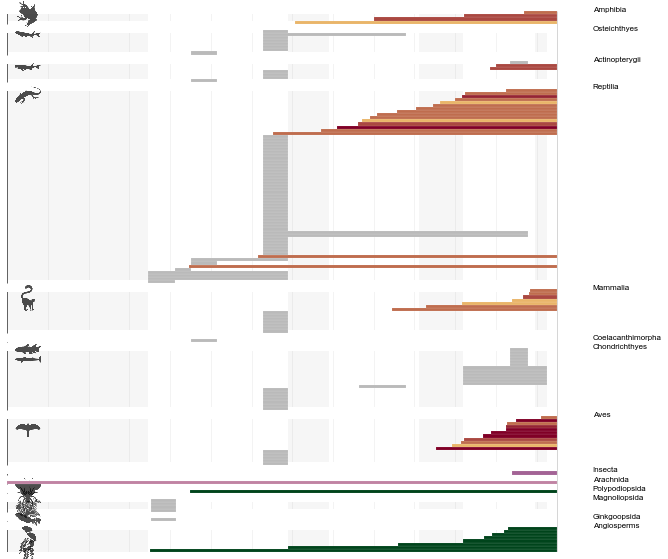

In [213]:
fig,ax=plt.subplots(figsize=(10,10))
# dictfunc=lambda x: phylummcmpdict[x.loc[row.Index,colorby]]
# [phylummcmpdict['Angiosperms'][x] for x in alldataplot['sister_lineage_plot']]
hbars(alldataplot,ax,colorby='colcolumn',color='',by='class',tmin='early_age',tmax='late_age',fading='pleistocene',labels=True,order=phylummcmpdict.keys())
# print(phylummcmpdict.keys())

ybase=ax.get_ylim()[1]-2
for clas in list(phylummcmpdict.keys())[::-1]:
    height=len(alldataplot[alldataplot['class']==clas])
    imagebox=OffsetImage(taxaicons[clas],zoom=0.2,cmap=plt.cm.gray_r,alpha=0.7)
    ab=AnnotationBbox(imagebox,(ax.get_xlim()[0]+5,ybase),frameon=False)
    ax.add_artist(ab)
    ybase-=height+2.5

plt.show

In [271]:
def hbars(dataset,ax,color=origin_dict,colorby='sister_lineage_plot',by='class',tmin='early_age',tmax='late_age',stem='',
          widht=1,ybase=1,ascending=True,fossil=False,fading='pleistocene',labels=True,order=''):
    """
    Plots horizontal bar plots from data with three dimmensions of data: time, category, source
    order is a list to set the desired order of the items 
    """
    ybase = ybase-ybase # starts from zero
    max_time = dataset[tmin].max()
    ax.set_facecolor('none')
    claslist=dataset[by].unique() if order == '' else order
    for clas in claslist:# just to get the space between classes
        temp = dataset[dataset[by]==clas]
        for row in temp.itertuples():
            tminval=dataset.loc[row.Index,tmin]
            tmaxval=dataset.loc[row.Index,tmax]
            bar_height = tminval-tmaxval
            widht = widht
            bottom = max_time-tminval if ascending == True else tminval # row.late_age # bottom of the bars
            ax.barh(y = ybase,left = bottom,width = bar_height,height = widht,
#                     color=color[dataset.loc[row.Index,colorby]] if color != '' and isinstance(color,dict) == True else dataset.loc[row.Index,colorby],
                    color=dataset.loc[row.Index,colorby] if color == '' else color[dataset.loc[row.Index,colorby]],
                   align='edge',edgecolor='#ffffff',alpha=1,linewidth=0.1,hatch='/' if fossil == True and tmaxval != 0 else '',zorder=1000)
            if stem != '':
                if tmaxval == 0:
                    stem_age=dataset.loc[row.Index,stem]
                    ax.hlines(y=ybase+widht/2,xmin=max_time-stem_age,xmax=max_time-tminval,color='k',lw=0.6,zorder=100)
                    ax.scatter(max_time-stem_age,ybase+widht/2,color='k',s=8,zorder=100)
            ybase+=widht
        ax.vlines(x=0,ymin=ybase-len(temp),ymax=ybase,lw=1,color='#636363') ## line for each class section
        ybase+=1
        ax.hlines(y=ybase,xmin=0,xmax=max_time,lw=12,color='w') ## line splitting classes
        ybase+=1
        ax.vlines(x=max_time,ymin=0,ymax=ybase-2,lw=1,color='#d6d6d6') ## line at the max time
        
        if labels == True:
            ax.text(ax.get_xlim()[0]+ax.get_xlim()[1]*0.2,ybase-2.7,clas,fontsize=10,fontname='Arial',ha='left')
        
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    
    plt.xticks([]);plt.yticks([])
    plt.ylim(0,ybase-1);plt.xlim(0,max_time+2)

    if fading == 'holocene':
        for key,value in hol_time_dict.items(): # epoch shading
            ax.axvspan(xmin=max_time-value[0],xmax=max_time-value[1],ymin=0,ymax=ybase-2,facecolor=hol_col_dict[key][0],alpha=0.2,zorder=1)
        for x in range(0,int(hol_time_dict['Pleistocene'][1]),10): # lines every 10 years
            ax.vlines(x=x,ymin=0,ymax=ybase-1.5,lw=1,ls='-',color='#bababa',alpha=0.2,zorder=1)
    if fading == 'pleistocene':
        for key,value in geol_time_dict.items(): # epoch shading
            ax.axvspan(xmin=max_time-value[0],xmax=max_time-value[1],ymin=0,ymax=ybase-2,facecolor=geol_col_dict[key][0],alpha=0.2,zorder=1)
        for x in range(0,int(geol_time_dict['Early Cretaceous'][1]),10): # lines every 10 years
            ax.vlines(x=x,ymin=0,ymax=ybase-1.5,lw=1,ls='-',color='#bababa',alpha=0.2,zorder=1)
    return ax

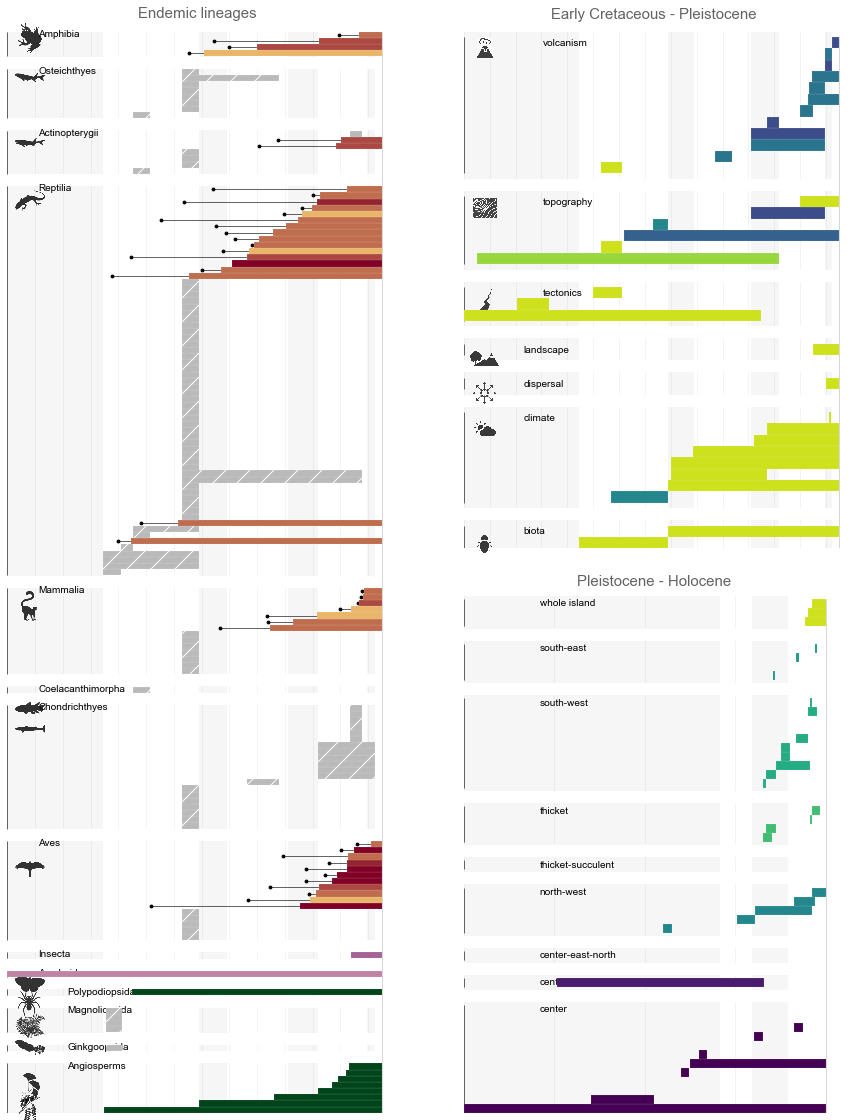

In [272]:
plt.figure(figsize=(15,20),facecolor='w')
G = gridspec.GridSpec(2,2,hspace=0.08,wspace=0.2,height_ratios=[1,1]) # second pannel empty
# #---------------------------------------------------------------------------------------------------------------------------------columns
ax=plt.subplot(G[:,0])

hbars(alldataplot,ax,by='class',color='',colorby='colcolumn',tmin='early_age',tmax='late_age',stem='stem_age',fossil=True,fading='pleistocene',labels=True,order=phylummcmpdict.keys())
ax.text(x=ax.get_xlim()[1]/2,y=ax.get_ylim()[1]+2,s='Endemic lineages',color='#636363',fontsize=15,ha='center',va='center',fontname='Arial',rotation=0) ## line for tittle
ybase=ax.get_ylim()[1]-2
for clas in list(phylummcmpdict.keys())[::-1]:
    height=len(alldataplot[alldataplot['class']==clas])
    imagebox=OffsetImage(taxaicons[clas],zoom=0.23,cmap=plt.cm.gray_r,alpha=0.8)
    ab=AnnotationBbox(imagebox,(ax.get_xlim()[0]+8,ybase),frameon=False)
    ax.add_artist(ab)
    ybase-=height+2.5

#--------------------------------------------------------------------------------------------------------------------------------- events
ax=plt.subplot(G[0,1])

hbars(events,ax,by='type',color=site_dict_col,colorby='location',tmin='time_Ma_from',tmax='time_Ma_to',fading='pleistocene',labels=True)
ax.text(x=ax.get_xlim()[1]/2,y=ax.get_ylim()[1]+1,s='Early Cretaceous - Pleistocene',color='#636363',fontsize=15,ha='center',va='center',fontname='Arial') ## line for tittle

ybase=ax.get_ylim()[1]-2
for event in list(events['type'].unique())[::-1]:
    height=len(events[events['type']==event])
    imagebox=OffsetImage(eventicons[event],zoom=0.05,cmap=plt.cm.gray_r,alpha=0.8)
    ab=AnnotationBbox(imagebox,(ax.get_xlim()[0]+8,ybase),frameon=False)
    ax.add_artist(ab)
    ybase-=height+2.1

# #--------------------------------------------------------------------------------------------------------------------------------- holocene
ax=plt.subplot(G[1,1])
hbars(data,ax,color=site_dict_col,by='ecosystem_affected_plot',colorby='ecosystem_affected_plot',tmin='early_age',tmax='late_age',fading='holocene',labels=True)
ax.text(ax.get_xlim()[1]/2,y=ax.get_ylim()[1]+1,s='Pleistocene - Holocene',color='#636363',fontsize=15,ha='center',va='center',fontname='Arial',rotation=0) ## line for tittle

# plt.savefig('./fig_1_20201206.pdf',dpi=300)
plt.show()

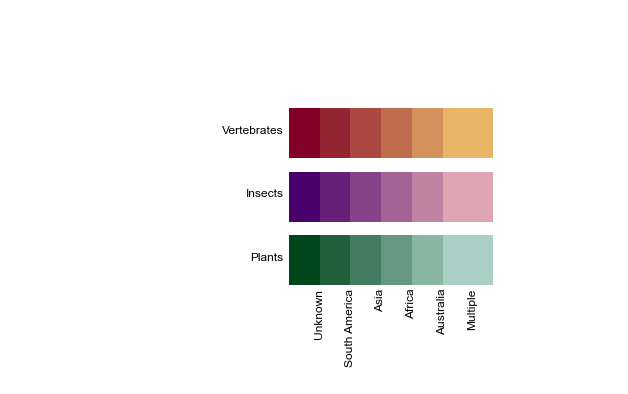

In [320]:
# legend
plantcoldict=colourDict(['Unknown','South America','Asia','Africa','Australia','Multiple'],cmap=plantcmap)
insectcoldict=colourDict(['Unknown','South America','Asia','Africa','Australia','Multiple'],cmap=insectcmap)
vertebratecoldict=colourDict(['Unknown','South America','Asia','Africa','Australia','Multiple'],cmap=vertebratecmap)

fig,ax=plt.subplots(figsize=(11,7))

# for index,code in enumerate(product([plantcoldict,insectcoldict,vertebratecoldict],['Unknown','South America','Asia','Africa','Australia','Multiple'])):
#     print(index,code)
labels=['Plants','Insects','Vertebrates']
origins=['Unknown','South America','Asia','Africa','Australia','Multiple']
y=0
for index,dic in enumerate([plantcoldict,insectcoldict,vertebratecoldict]):
    x=0
    ax.text(x=-0.1,y=y,s='%s'%(labels[index]),fontname='Arial',fontsize=12,ha='right')
    for i,loc in enumerate(['Unknown','South America','Asia','Africa','Australia','Multiple']):
        ax.scatter(x=x,y=y,s=2500,marker='s',facecolor=dic[loc],edgecolor='none')
        if index == 2:
            ax.text(x=x,y=-0.0022,s='%s'%(origins[i]),fontname='Arial',fontsize=12,va='top',rotation=90)
        x+=0.1
    y+=0.005
[ax.spines[loc].set_visible(False) for loc in ax.spines]
plt.xticks([])
plt.yticks([])

ax.set_ylim(-0.01,0.02)
ax.set_xlim(-1,1)
plt.show()

In [ ]:

# imagebox=OffsetImage(event_icons_dict[event],zoom=0.02,cmap=plt.cm.gray_r,alpha=0.6)
# ab=AnnotationBbox(imagebox,(-5 if (ycontrol % 2)!=0 else-12,ybase-(len(temp)*0.5)),frameon=False) # icons position
# ax.add_artist(ab)
# ax.hlines(y=ybase-(len(temp)*0.6),xmin=-5 if (ycontrol % 2)!=0 else-12,xmax=0,lw=3,ls='--',color='#d6d6d6') # lines connecting icon to panel

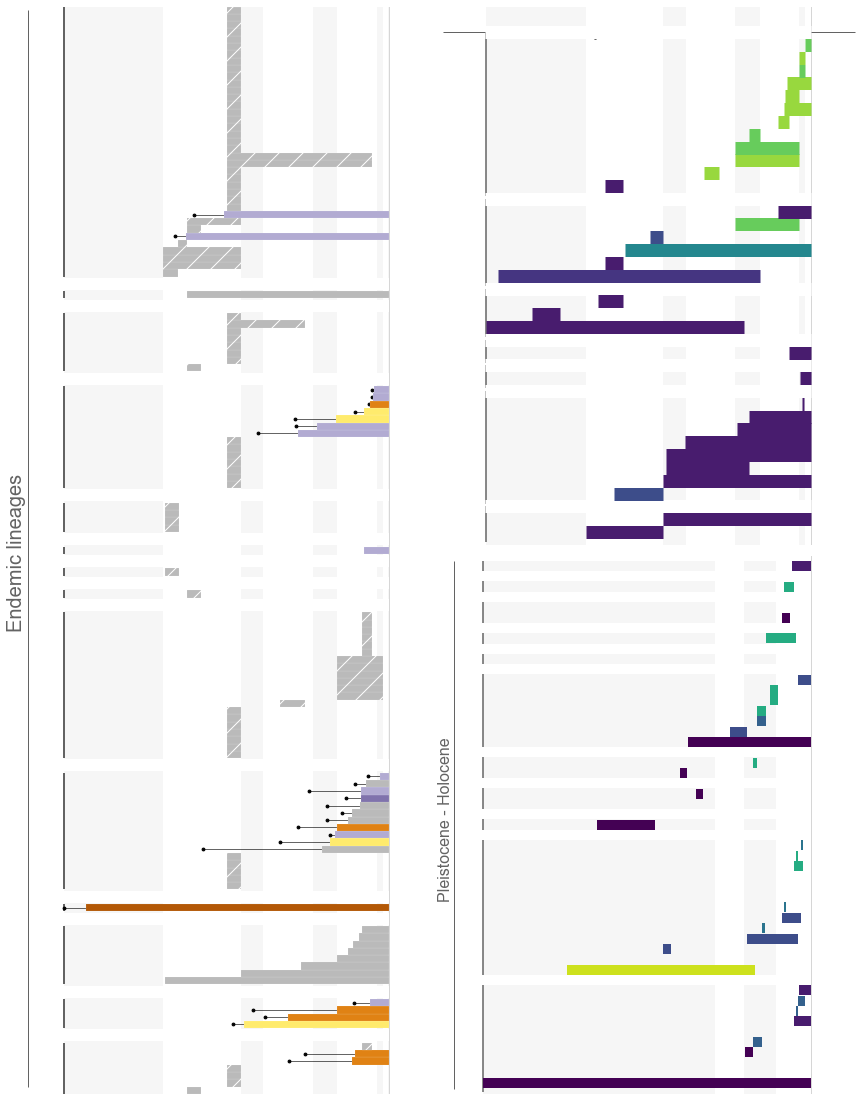

In [243]:
plt.figure(figsize=(15,20),facecolor='w')
G = gridspec.GridSpec(2,2,hspace=0.02,wspace=0.02,height_ratios=[1,1]) # second pannel empty

#----------------------------------------------------------- change things here, not the figure code ;)
barWidth=1
thick_col='#969696'
x_axisticks=math.ceil(geol_time_dict['Early Cretaceous'][1])
dataset=alldataplot # [['class','occurrence_no','early_age','late_age']]
plotxlimmin=-20
plotxlim=geol_time_dict['Early Cretaceous'][1]+20
max_time=geol_time_dict['Early Cretaceous'][1]

#--------------------------------------------------------------------------------------------------------------------------------- events
ax=plt.subplot(G[0,1])
lw=13
ybase=1
ycontrol=1
for event in events['type'].unique():# just to get the space between classes
    temp=events[events['type']==event]
    for row in temp.itertuples():
        ax.hlines(y=ybase,xmin=max_time-row.time_Ma_from,xmax=max_time-row.time_Ma_to,ls='-',lw=lw,color=site_dict_col[row.location],zorder=1000)
        ybase+=1
#     imagebox=OffsetImage(event_icons_dict[event],zoom=0.02,cmap=plt.cm.gray_r,alpha=0.6)
#     ab=AnnotationBbox(imagebox,(-5 if (ycontrol % 2)!=0 else-12,ybase-(len(temp)*0.5)),frameon=False) # icons position
#     ax.add_artist(ab)
#     ax.hlines(y=ybase-(len(temp)*0.6),xmin=-5 if (ycontrol % 2)!=0 else-12,xmax=0,lw=3,ls='--',color='#d6d6d6') # lines connecting icon to panel
    ax.vlines(x=0,ymin=ybase-len(temp)-0.8,ymax=ybase,lw=1.5,color='#636363',zorder=10) ## line for each little pannel
    ax.hlines(y=ybase,xmin=-0.5,xmax=max_time,lw=lw,color='w',zorder=100,alpha=1) # lines between event types
    ybase+=1
    ycontrol+=1 # to avoid nearby icons overlapping
    
plt.xticks([]);plt.yticks([]) # label format
plt.xlim(plotxlimmin,plotxlim);plt.ylim(0,ybase+1)
ax.vlines(x=max_time,ymin=0,ymax=plotxlim,lw=1,color='#d6d6d6') ## line at the max time
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

ax.hlines(y=ybase-1,xmin=plotxlimmin+0.5,xmax=plotxlim-0.5,lw=1,color='#636363') ## line for tittle
ax.text(x=(plotxlim-1)/2,y=ybase-1,s='Early Cretaceous - Pleistocene',color='#636363',fontsize=15,ha='center',va='center',fontname='Arial') ## line for tittle

for key,value in geol_time_dict.items(): # epoch shading
    ax.axvspan(xmin=max_time-value[0],xmax=max_time-value[1],ymin=0,ymax=ybase-1,facecolor=geol_col_dict[key][0],alpha=0.2,zorder=1)
# #---------------------------------------------------------------------------------------------------------------------------------columns
ax=plt.subplot(G[:,0])
plt.xlim(plotxlimmin,plotxlim);plt.ylim(0,len(dataset))

ybase=0 #  [['class','occurrence_no','early_age','late_age']] alldata.sort_values(by=['class','early_age'],ascending=[True,False],inplace=True)
for clas in dataset['class'].unique():# just to get the space between classes
    temp=dataset[dataset['class']==clas]
    for row in temp.itertuples():
        bar_height=row.early_age-row.late_age
        widht=1
        bottom=max_time-row.early_age# row.late_age # bottom of the bars
        ax.barh(y=ybase,left=bottom,width=bar_height,height=widht,color=origin_dict[row.sister_lineage_plot],
               align='edge',edgecolor='#ffffff',alpha=1,linewidth=0.1,hatch='/' if row.late_age != 0 else '',zorder=1000)
        if row.type == 'extant':
            ax.hlines(y=ybase+widht/2,xmin=max_time-row.stem_age,xmax=max_time-row.early_age,color='k',lw=0.6,zorder=100)
            ax.scatter(max_time-row.stem_age,ybase+widht/2,color='k',s=8,zorder=100)
        ybase+=widht
    ax.vlines(x=0,ymin=ybase-len(temp),ymax=ybase,lw=2,color='#636363') ## line for each class section
    ybase+=1
    ax.hlines(y=ybase,xmin=plotxlimmin,xmax=max_time,lw=12,color='w') ## line splitting classes
    ybase+=1
ax.vlines(x=max_time,ymin=0,ymax=plotxlim,lw=1,color='#d6d6d6') ## line at the max time
ax.vlines(x=plotxlimmin+4,ymin=1,ymax=len(dataset)-0.5,lw=1,color='#636363') ## line for tittle
ax.text(y=(len(dataset)-0.5)/2,x=plotxlimmin-1,s='Endemic lineages',color='#636363',fontsize=20,ha='center',va='center',fontname='Arial',rotation=90) ## line for tittle
#     #----------------------------------------------------------- epoch shading
for key,value in geol_time_dict.items(): # epoch shading
    ax.axvspan(max_time-value[0],max_time-value[1],0,ax.get_ylim()[1],facecolor=geol_col_dict[key][0],alpha=0.2,zorder=1)
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.xticks([]); plt.yticks([])

# #--------------------------------------------------------------------------------------------------------------------------------- PANEL 2
# #--------------------------------------------------------------- holocene

ax=plt.subplot(G[1,1])
lw=10
ybase=1
ycontrol=1
max_time=data['early_age'].max()
for event in data['ecosystem_arising_plot'].unique():# just to get the space between classes
    temp=data[data['ecosystem_arising_plot']==event]
    for row in temp.itertuples():
        ax.hlines(y=ybase,xmin=max_time-row.early_age,xmax=max_time-row.late_age,ls='-',lw=lw,color=site_dict_col[row.ecosystem_affected_plot],zorder=1000)
#                   label='%s %s'%(row.type,row.location) if '%s %s'%(row.type,row.location) not in set_legend else '',zorder=100) # lw=site_dict[row.location][1]
        ybase+=1
#     imagebox=OffsetImage(event_icons_dict[event],zoom=0.17,cmap=plt.cm.gray_r,alpha=0.6)
#     ab=AnnotationBbox(imagebox,(-5 if (ycontrol % 2)!=0 else-12,ybase-(len(temp)*0.5)),frameon=False) # icons position
#     ax.add_artist(ab)
    
#     ax.hlines(y=ybase-(len(temp)*0.6),xmin=-5 if (ycontrol % 2)!=0 else-12,xmax=0,lw=3,ls='--',color='#d6d6d6') # lines connecting icon to panel
    ax.vlines(x=0,ymin=ybase-len(temp)-0.8,ymax=ybase,lw=1.5,color='#636363',zorder=10) ## line for each little pannel
    ax.hlines(y=ybase,xmin=-0.5,xmax=max_time,lw=lw,color='w',zorder=100,alpha=1) # lines between event types
    ybase+=1
    ycontrol+=1 # to avoid nearby icons overlapping
plt.xticks([]);plt.yticks([]) # label format
ax.vlines(x=max_time,ymin=0,ymax=plotxlim,lw=1,color='#d6d6d6') ## line at the max time
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
for key,value in hol_time_dict.items(): # epoch shading
    ax.axvspan(max_time-value[0],max_time-value[1],0,ax.get_ylim()[1],facecolor=hol_col_dict[key][0],alpha=0.2,zorder=1)
ax.vlines(x=-3.5,ymin=0.5,ymax=ybase-1.5,lw=1,color='#636363') ## line for tittle
ax.text(y=(ybase)/2,x=-4.5,s='Pleistocene - Holocene',color='#636363',fontsize=16,ha='center',va='center',fontname='Arial',rotation=90) ## line for tittle
plt.ylim(0,ybase-1);plt.xlim(-5,max_time+5.5)
# plt.savefig('./fig_1_20201206.pdf',dpi=300)
plt.show()

In [102]:
hol_col_dict
hol_time_dict

{'Meghalayan': (0, 42.0),
 'Northgrippian': (42.0, 82.0),
 'Greenlandian': (82.0, 117.0)}

# Feedback wanted:

* The Holocene is very short.. I'm not sure if I should delete the label? I pushed it to the right but it looks like is off ('cause it is)
* Units for the Holocene pannel on the right?
* do barplots instead of cummulative sums
* Split by genus or family or something.
